In [1]:
%run 00_analysis_config.ipynb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

# Figure save path prefix
savefig.fig_prefix = "plots/vertex2_"    # It's good to keep figures in a separate folder. Can also be set to None.
savefig.SAVE = True         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.

In [3]:
filename_pre = f"{DATA_DIR}/filereader_muon_M4000_P40000_N60000_fullvolume/20230611/192021/"
filenames = [f"{filename_pre}/stat_vertex_original.root",
             f"{filename_pre}/stat_seedmod.root",
             # f"{filename_pre}/stat0.root"]
             f"{filename_pre}/stat_vertexmod.root"]
filelables=["boost10fullvolume_original",
            "boost10fullvolume_fix",
           "boost10fullvolume_mod"]

# filenames = [f"{DATA_DIR}//XtoMuMu_P10GeV_manual/20230526/170751/stat_vertex_original.root",f"{DATA_DIR}//XtoMuMu_P10GeV_manual/20230526/170751/stat_vertexmod.root"]

In [4]:
def read_raw_vertex(filename):
    """
    Return:
    [[x, y, z, px, py, pz],[x, y, z, px, py, pz],...]
    """
    vertices = []
    with open(filename, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break
            if "#" in line:
                continue
            else:
                line = line.split()
                if len(line)>0 and line[0] == "n":
                    while True:
                        line2 = f.readline()
                        if "#" in line2:
                            continue                           
                        line2 = line2.split()
                        if len(line2)>0:
                            break
                    vertex = [float(line2[1]), float(line2[2]), float(line2[3]), float(line[6]), float(line[7]), float(line[8])] # x, y, z, px, py, pz
                    vertices.append(vertex)
                else:
                    continue
    return np.array(vertices)

In [5]:
filename_raw = "scripts/filereader_muon_M4000_P40000_N60000_fullvolume.txt"
# filename_raw = "scripts/file_reader_example_particle_parameter.txt"
vertex_raw = read_raw_vertex(filename_raw)
vertex_raw_eta = np.arctanh(vertex_raw[:,3]/np.linalg.norm(vertex_raw[:,3:6],axis=1))
vertex_raw_phi = np.arctan(-vertex_raw[:,4]/vertex_raw[:,5])

Number of events 52917
['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_track_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'G4KLong_code', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_cov_t_x', 'Vertex_k_m_cov_t_y', 'Vertex_k_m_cov_t_z', 'Vertex_k_m_cov_x_y', 'Vertex_k_m_cov_x_z', 'Vertex_k_m_cov_y_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
  0%|          | 0/52917 [00:00<?, ?it/s]/tmp/ipykernel_27240/3814740875.py:219: RuntimeWarning: invalid value encountered in sqrt
  results_fit["tracks_recon_error"].append(np.sqrt(tracks_recon_error))
100%|██████████| 52917/52917 [07:59<00:00, 110.26it/s]


dict_keys(['Entry', 'ndigi', 'Digi_track_id', 'mask_recon_success_track', 'mask_recon_success_vertex', 'mask_reconstructible_vertex', 'mask_reconstructible2_vertex', 'tracks_truth', 'tracks_truth_n', 'tracks_truth_nlayer', 'tracks_truth_pdgids', 'tracks_recon', 'tracks_recon_n', 'tracks_recon_error', 'tracks_ndigi', 'tracks_ndigi_false', 'tracks_purity', 'tracks_pdgids', 'tracks_chi2', 'vertices_truth', 'vertices_ntrack', 'vertices_ntrack_truth', 'vertices_recon', 'vertices_recon_n', 'vertices_recon_error', 'vertices_recon_cov', 'vertices_chi2'])


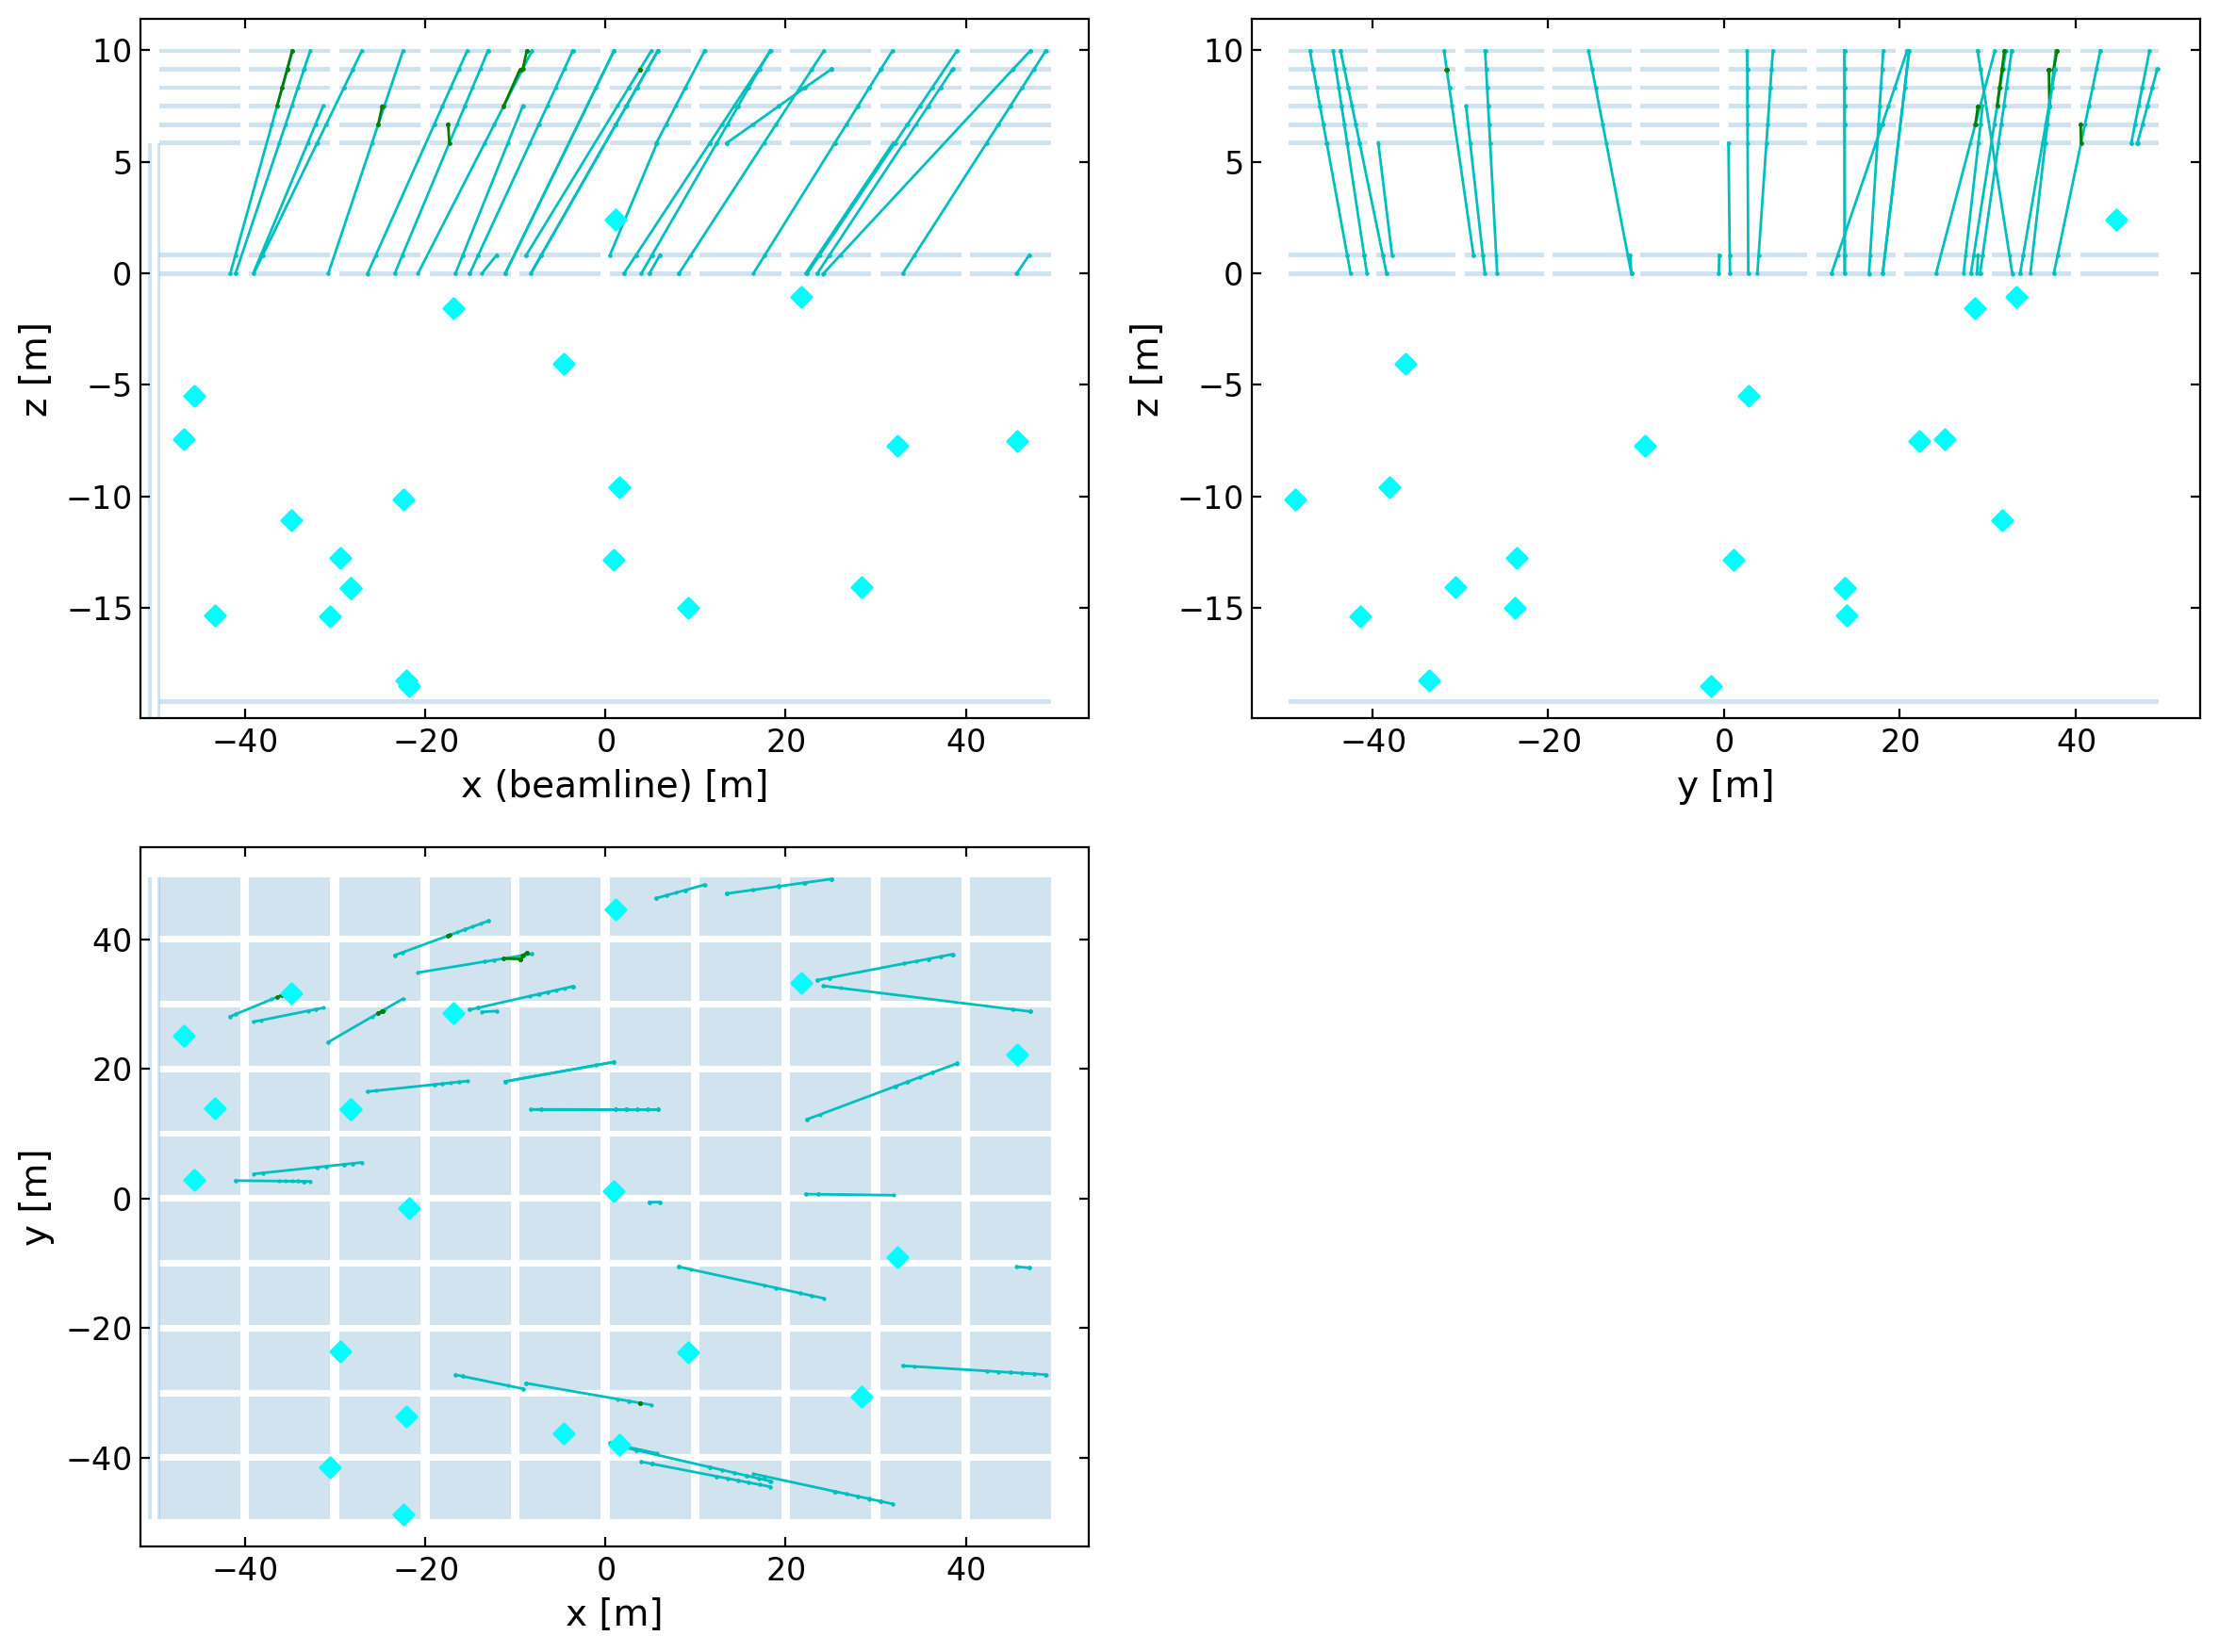

In [6]:
ifile=2

filename_recon = filenames[ifile]
n_original=60_000;


# filename_recon = os.path.dirname(filename)+"/stat_seedmod.root"
tfile = root.TFile.Open(filename_recon)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
ev = event.Event(filename_recon, 0, tree_name=tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)
print(branch_list)

# Draw 20 events
ev = event.Event(filename_recon, 0, tree_name=tree_name)
fig,axs=plt.subplots(2,2,figsize=(12,9))
for i in range(20):
    ev.EventNumber=i
    # Plot truth
    fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False,make_legend=False);
fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_vertex=False, disp_first_hit=False,make_legend=False);

# Load data
data = get_km_alltracks_old(filename_recon, nevents=-1)
print(data.keys())

In [7]:
# -------
# Cuts
mask_vertex_recon = data["vertices_recon_n"]>=1
mask_track_recon = data["mask_recon_success_track"]
mask = mask_vertex_recon
# mask_reconstructible = np.array([(len(i)>1 and min(i)>=4) for i in data["tracks_truth_nlayer"]])
mask_reconstructible = np.array(data["mask_reconstructible_vertex"])
k_reconstructible = sum(mask_reconstructible)/n_original
print("Total events:",len(mask_reconstructible),". Total simulated:",n_original)
print("k_reconstructible: ",k_reconstructible)

# -----------
# Variables

Entry = np.array(util.appcut(data["Entry"], mask))
Entry_failed = np.array(util.appcut(data["Entry"], ~mask))
Vertices = util.appcut(data["vertices_recon"],mask)
Vertices = np.array([v[0] for v in Vertices])
Vertices_err = util.appcut(data["vertices_recon_error"],mask)
Vertices_err = np.array([v[0] for v in Vertices_err])
Vertices_cov = util.appcut(data["vertices_recon_cov"],mask)
Vertices_cov = np.array([v[0] for v in Vertices_cov])
Vertices_chi2 = np.array([v[0] for v in util.appcut(data["vertices_chi2"],mask)])
Vertices_tracklayers = util.appcut(data["tracks_truth_nlayer"], mask)
Vertices_tracklayers_failed = util.appcut(data["tracks_truth_nlayer"], ~mask)


# The following truth values should have the same length as total enetries
Vertices_truth_xyz=[]
Vertices_truth=[]
Vertices_truth_direction_unit=[]
Vertices_track1_truth = []
Vertices_track2_truth = []
Vertices_track1_truth_vunit=[]
Vertices_track2_truth_vunit=[]
Vertices_opening_angle=[]
Vertices_plane_angle=[]


for i in tqdm(range(nevents)):
    Tree.GetEntry(i)
    g4ids = util.c2list(Tree.Hit_G4ParentTrackId)
    HAS_TWO_TRACKs = (1 in g4ids) and (2 in g4ids)
    if HAS_TWO_TRACKs:
        vertex=[Tree.GenParticle_x[1]/10, Tree.GenParticle_y[1]/10, Tree.GenParticle_z[1]/10]
        Vertices_truth_xyz.append([Tree.GenParticle_x[1]/10, Tree.GenParticle_y[1]/10, Tree.GenParticle_z[1]/10])
        Vertices_truth.append([vertex[1], -vertex[2]+85.47*100, vertex[0], 0])
        Vertices_truth_direction_unit.append(Vertices_truth[-1][:3]/np.linalg.norm(Vertices_truth[-1][:3]))
        Vertices_track1_truth.append(get_track_param_truth_p(Tree, 1))
        Vertices_track2_truth.append(get_track_param_truth_p(Tree, 2))
        Vertices_track1_truth_vunit.append(Vertices_track1_truth[-1][3:6]/np.linalg.norm(Vertices_track1_truth[-1][3:6]))
        Vertices_track2_truth_vunit.append(Vertices_track2_truth[-1][3:6]/np.linalg.norm(Vertices_track2_truth[-1][3:6]))
        Vertices_opening_angle.append(np.arccos(np.dot(Vertices_track1_truth_vunit[-1],Vertices_track2_truth_vunit[-1])))
        vertex_truth_direction_xy = np.array([Vertices_truth_direction_unit[-1][2],0,-Vertices_truth_direction_unit[-1][0]])
        vertex_truth_direction_xy = vertex_truth_direction_xy/np.linalg.norm(vertex_truth_direction_xy)
        vertex_plane_direction = np.cross(Vertices_track1_truth_vunit[-1],Vertices_track2_truth_vunit[-1])
        vertex_plane_direction = vertex_plane_direction/np.linalg.norm(vertex_plane_direction)
        Vertices_plane_angle.append(np.arccos(np.dot(vertex_truth_direction_xy,vertex_plane_direction)))
    else:
        Vertices_truth_xyz.append([-999,-999,-999])
        Vertices_truth.append([-999,-999,-999,-999])
        Vertices_truth_direction_unit.append([-999,-999,-999])
        Vertices_track1_truth.append([-999,-999,-999,-999,-999,-999,-999])
        Vertices_track2_truth.append([-999,-999,-999,-999,-999,-999,-999])
        Vertices_track1_truth_vunit.append([-999,-999,-999])
        Vertices_track2_truth_vunit.append([-999,-999,-999])
        Vertices_opening_angle.append(-999)
        Vertices_plane_angle.append(-999)

    
Vertices_truth=np.array(Vertices_truth)
Vertices_truth_xyz=np.array(Vertices_truth_xyz)
Vertices_truth_masked = Vertices_truth[mask]    
Vertices_truth=np.array(Vertices_truth)
Vertices_truth_direction_unit=np.array(Vertices_truth_direction_unit)
Vertices_track1_truth=np.array(Vertices_track1_truth)
Vertices_track2_truth=np.array(Vertices_track2_truth)
Vertices_track1_truth_vunit=np.array(Vertices_track1_truth_vunit)
Vertices_track2_truth_vunit=np.array(Vertices_track2_truth_vunit)
Vertices_opening_angle=np.array(Vertices_opening_angle)
Vertices_plane_angle=np.array(Vertices_plane_angle)  
    
Vertices_truth_eta = np.arctanh(Vertices_truth[:,2]/np.linalg.norm(Vertices_truth[:,:3],axis=1))
Vertices_truth_phi = np.arctan(Vertices_truth[:,0]/Vertices_truth[:,1])

# Residual: each entry is [dx, dy, dz, dt]
residual = (Vertices - Vertices_truth[mask])
Vertices_truth_direction_unit_masked = Vertices_truth_direction_unit[mask]

# Total position residual
residual_r = np.linalg.norm(residual[:,:3],axis=1)
residual_axial  = np.array([np.dot(residual[i][:3],Vertices_truth_direction_unit_masked[i]) for i in range(len(residual))])    
residual_radial = np.array([np.linalg.norm(np.cross(residual[i][:3],Vertices_truth_direction_unit_masked[i])) for i in range(len(residual))])

Total events: 52917 . Total simulated: 60000
k_reconstructible:  0.4882


  3%|▎         | 1323/52917 [00:01<00:49, 1039.11it/s]/tmp/ipykernel_27240/1263514425.py:57: RuntimeWarning: invalid value encountered in true_divide
  vertex_plane_direction = vertex_plane_direction/np.linalg.norm(vertex_plane_direction)
  3%|▎         | 1433/52917 [00:01<00:48, 1055.15it/s]/tmp/ipykernel_27240/1263514425.py:52: RuntimeWarning: invalid value encountered in true_divide
  Vertices_track2_truth_vunit.append(Vertices_track2_truth[-1][3:6]/np.linalg.norm(Vertices_track2_truth[-1][3:6]))
  8%|▊         | 4178/52917 [00:04<00:45, 1073.53it/s]/tmp/ipykernel_27240/1263514425.py:53: RuntimeWarning: invalid value encountered in arccos
  Vertices_opening_angle.append(np.arccos(np.dot(Vertices_track1_truth_vunit[-1],Vertices_track2_truth_vunit[-1])))
100%|██████████| 52917/52917 [00:49<00:00, 1058.43it/s]


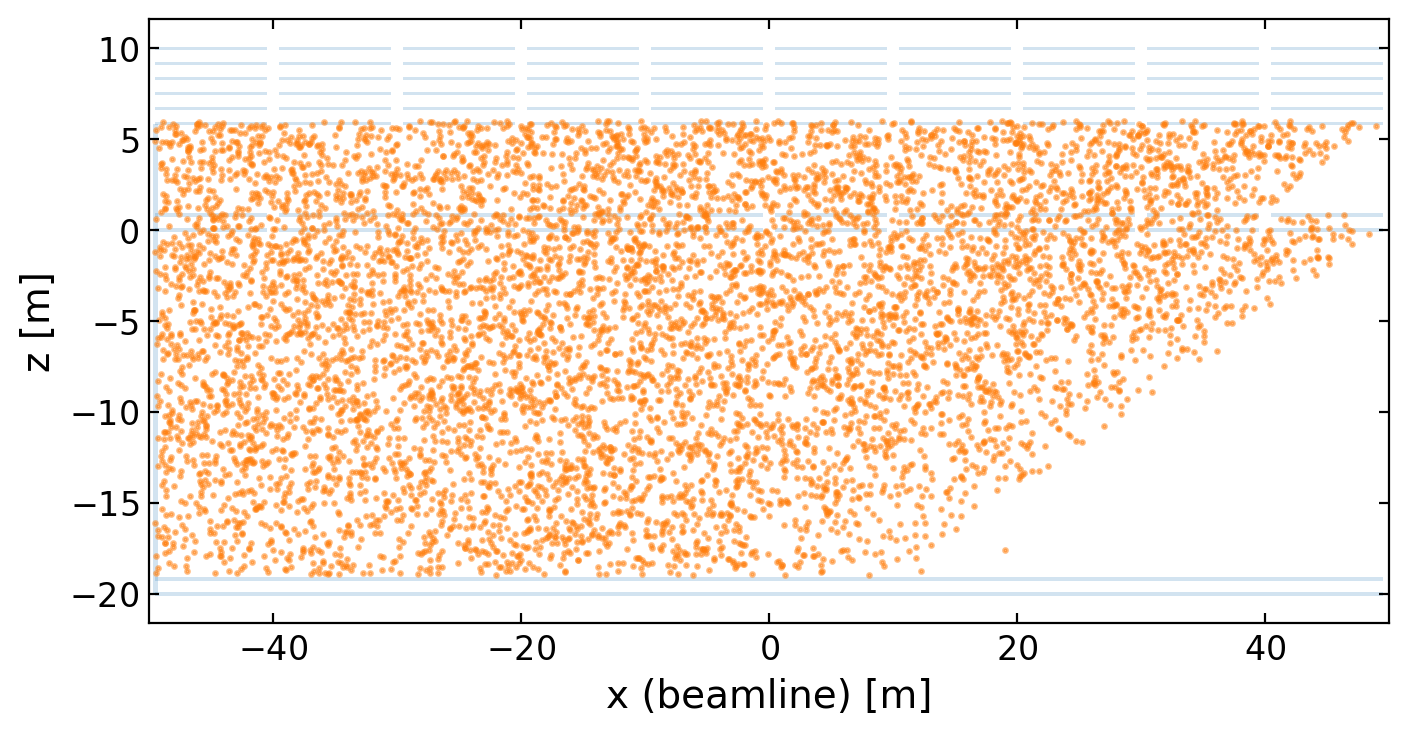

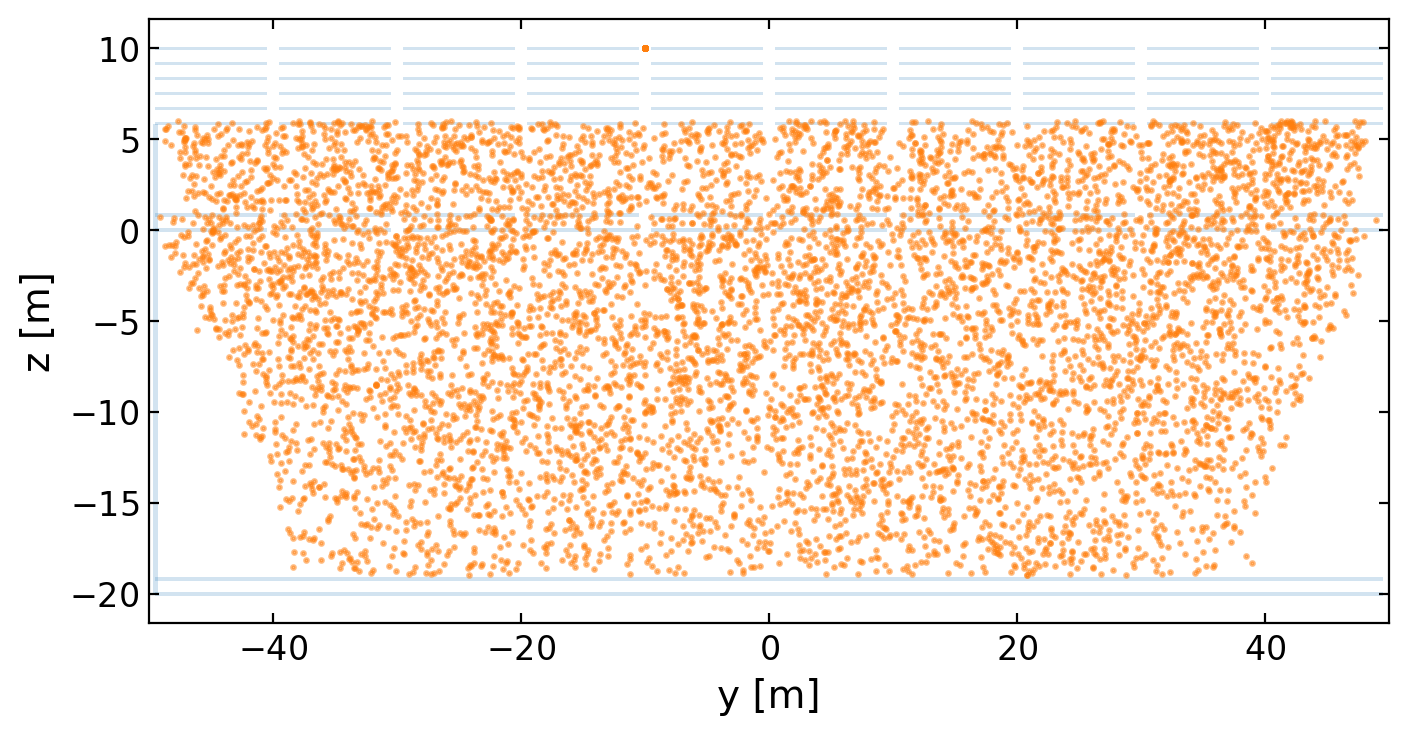

In [8]:
fig,ax=subplots(figsize=(8,4))
vis.drawdet_xz(alpha=0.2)
nplot=10000
scatter(Vertices_truth_xyz[:nplot,0]/100-70-49.5,-Vertices_truth_xyz[:nplot,2]/100,s=2,alpha=0.5,color="C1")
xlim(-50,50)
xlabel("x (beamline) [m]")
ylabel("z [m]")
savefig(f"{filelables[ifile]}_vertex_dist_xz")
show()

fig,ax=subplots(figsize=(8,4))
vis.drawdet_xz(alpha=0.2)
nplot=10000
scatter(Vertices_truth_xyz[:nplot,1]/100,-Vertices_truth_xyz[:nplot,2]/100,s=2,alpha=0.5,color="C1")
xlim(-50,50)
xlabel("y [m]")
ylabel("z [m]")
savefig(f"{filelables[ifile]}_vertex_dist_yz")
show()

Efficiency: 0.45
0.4598833333333333


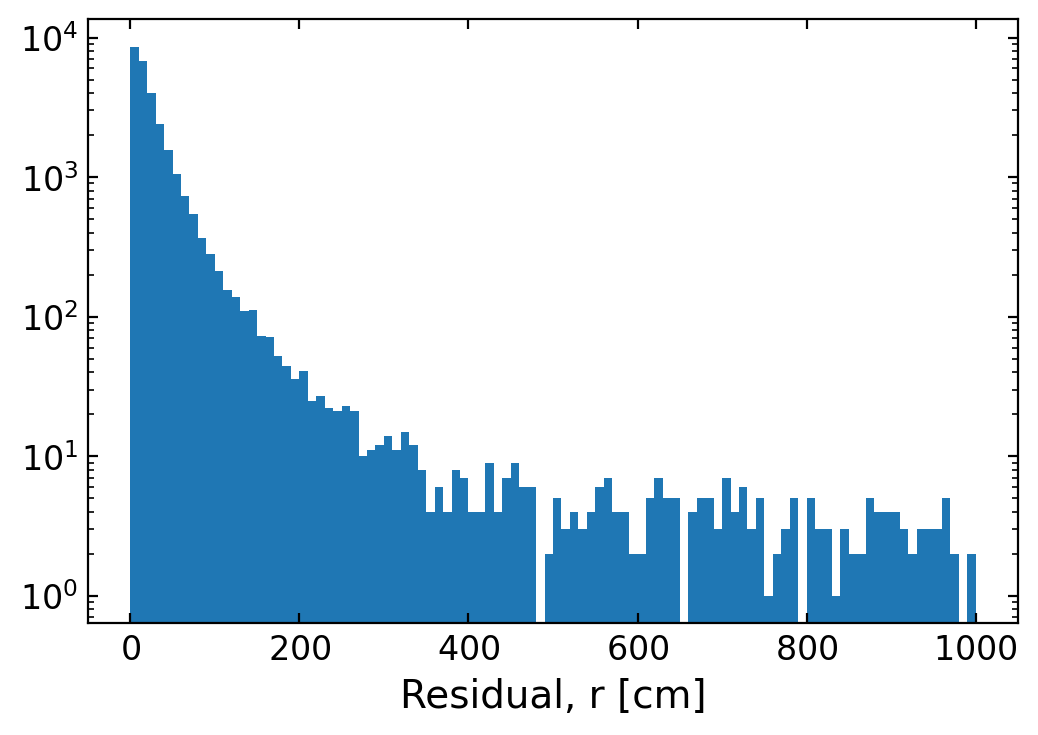

In [9]:
mask_residual = residual_r<200
hist(residual_r,log=1,range=(0,1e3));
efficiency = sum(mask_residual)/n_original
print("Efficiency:", f"{efficiency:.2f}")
xlabel("Residual, r [cm]")
print(sum(residual_r<400)/n_original)

### Efficiency vs x,y,z grid

[[0.53864169 0.65909091 0.67980296 0.6928934  0.62303665 0.58394161]
 [0.6027027  0.60628019 0.73504274 0.71291866 0.59657702 0.53527981]
 [0.56221198 0.62990196 0.73783784 0.7099768  0.70491803 0.53807107]
 [0.61139896 0.70074813 0.7622549  0.71287129 0.63703704 0.60051546]
 [0.53524804 0.69041769 0.71820449 0.72127139 0.66071429 0.53379953]
 [0.14854111 0.2200489  0.21410579 0.2109589  0.17906336 0.20551378]]


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


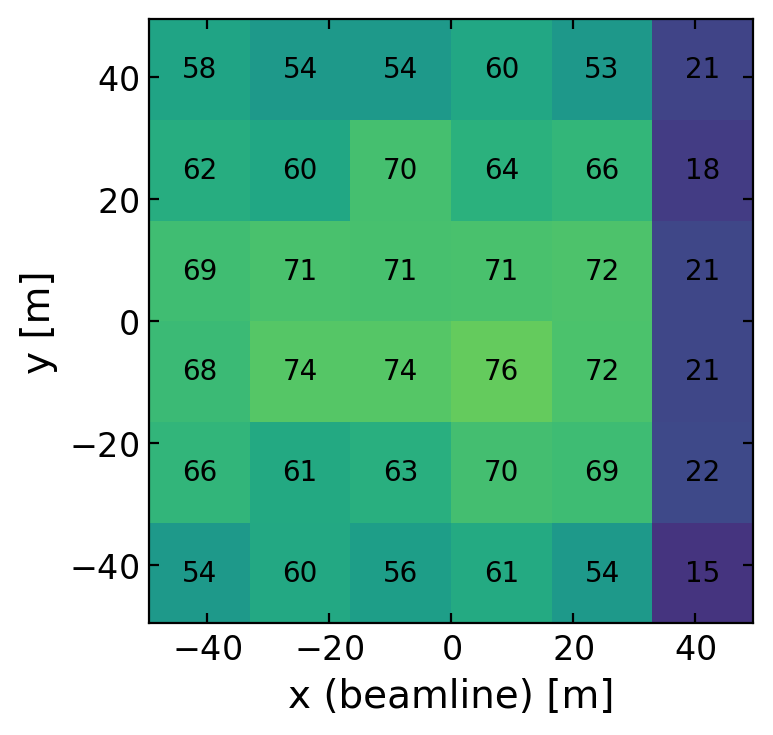

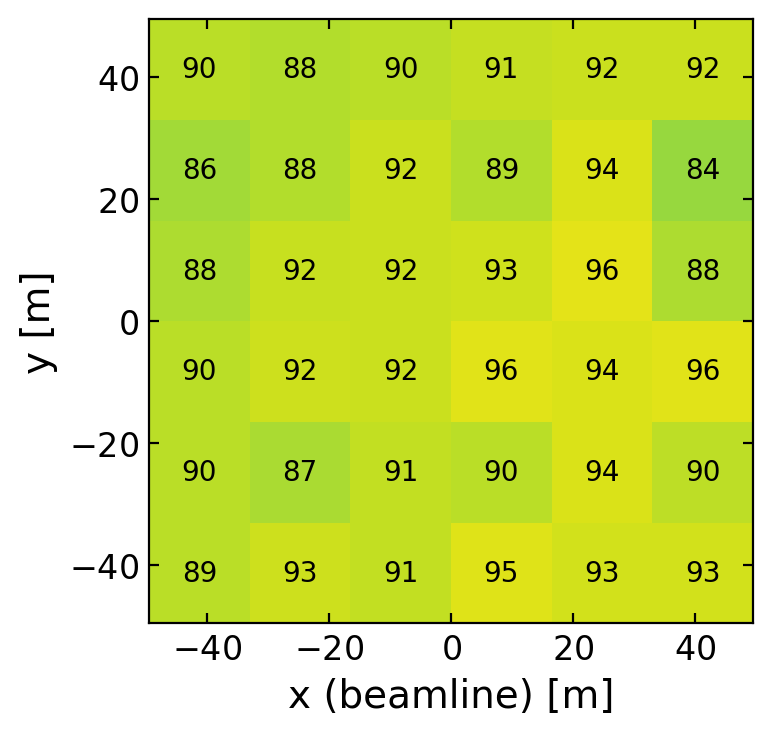

[[0.4398977  0.84149184 0.78589421 0.79818594 0.82460733 0.47409326]
 [0.48309179 0.78728606 0.76941748 0.8159204  0.8353222  0.46216216]
 [0.50617284 0.8115942  0.83333333 0.79800499 0.82962963 0.46788991]
 [0.49589041 0.81384248 0.76903553 0.74371859 0.82205514 0.48019802]
 [0.35194175 0.52142857 0.49004975 0.52997602 0.57800512 0.38684211]
 [0.00746269 0.01182033 0.01017812 0.01333333 0.00721154 0.00468384]]


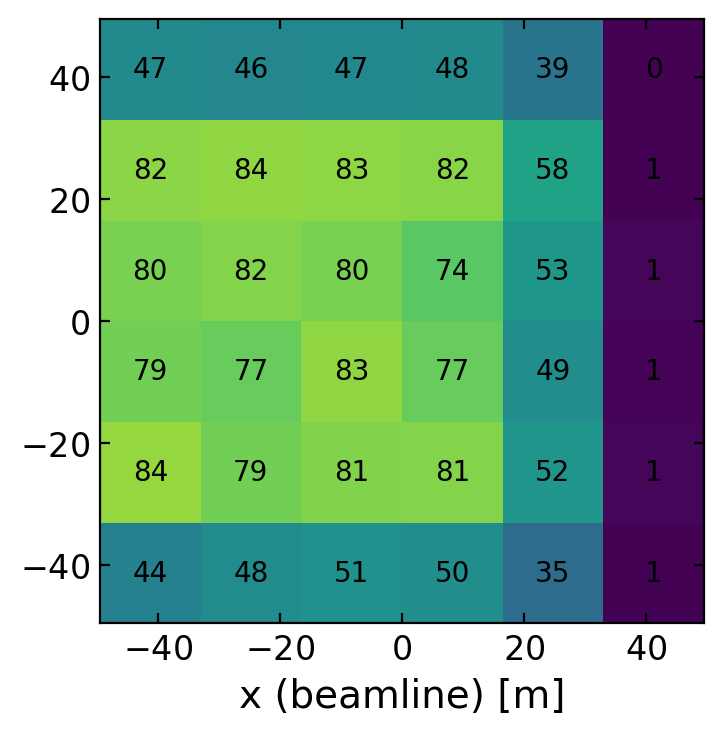

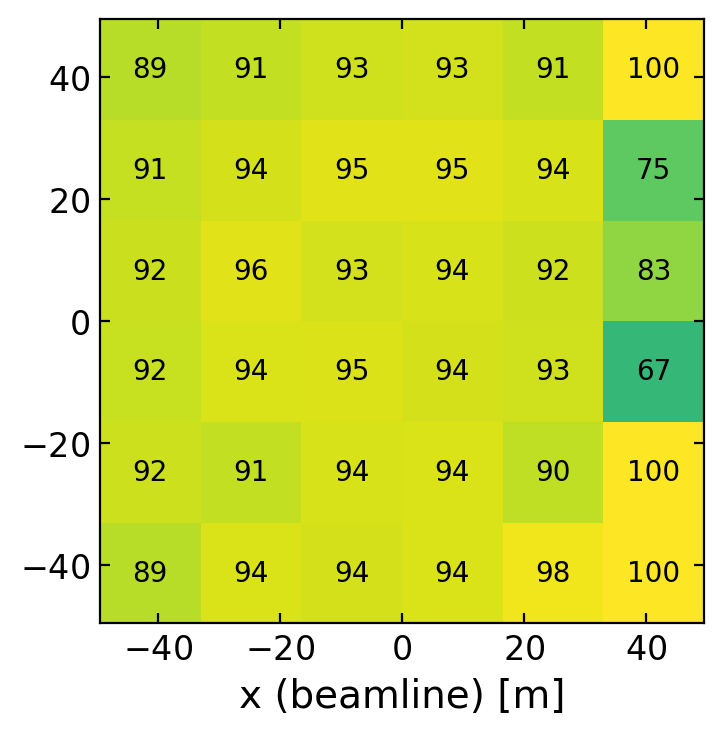

/tmp/ipykernel_27240/961552324.py:24: RuntimeWarning: invalid value encountered in long_scalars
  effs_ratio[ix][iy]=npass/ntotal_reconstructible


[[0.2793177  0.84199134 0.84458078 0.82135076 0.85232068 0.28923767]
 [0.28982301 0.82916667 0.80244399 0.82327586 0.83660131 0.31625835]
 [0.28820961 0.82822086 0.83187773 0.80513919 0.79872881 0.29723992]
 [0.24347826 0.6443418  0.63083164 0.61373391 0.69230769 0.24640657]
 [0.02801724 0.06557377 0.0741483  0.08314607 0.07346939 0.03153153]
 [0.         0.         0.         0.         0.         0.        ]]


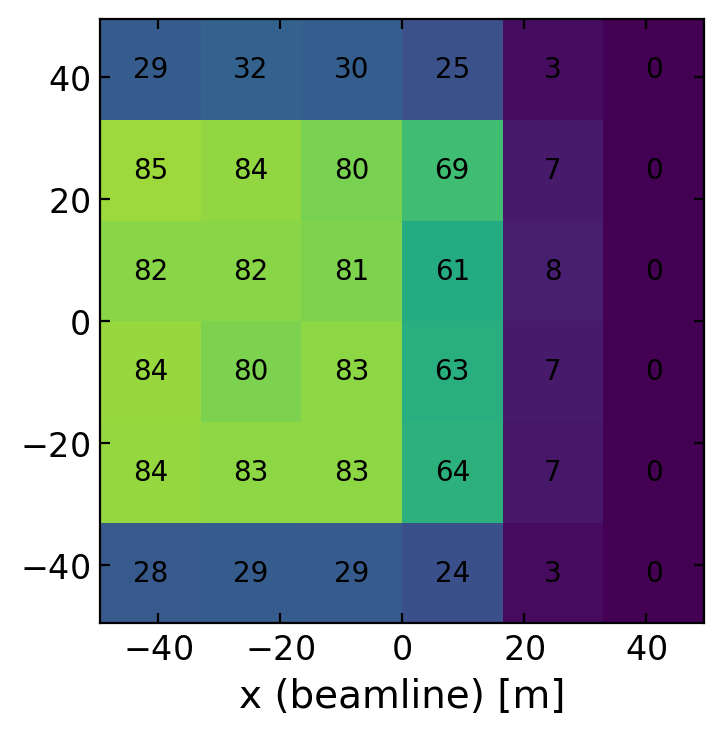

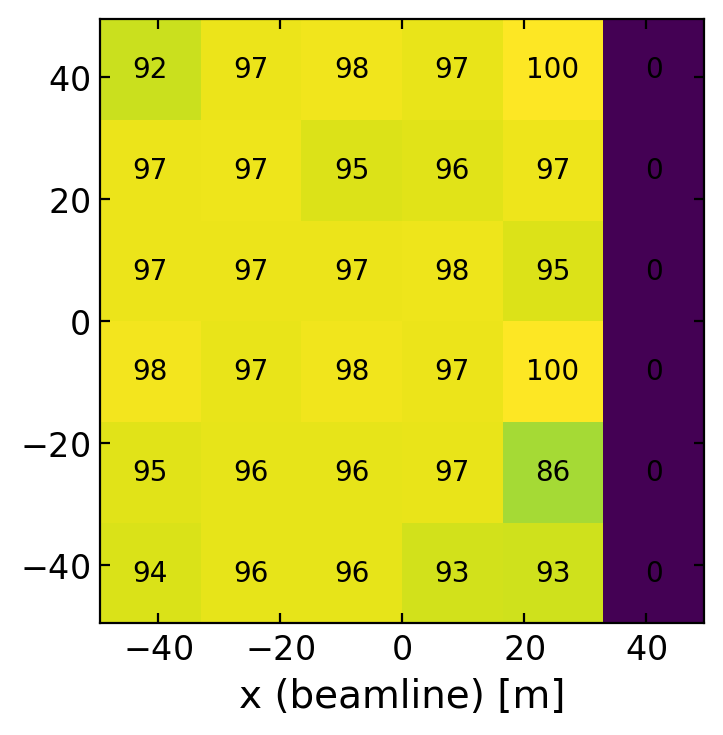

[[0.0795756  0.81151832 0.78820375 0.79032258 0.77808219 0.0879397 ]
 [0.1060241  0.79040404 0.73414634 0.76712329 0.82587065 0.08229426]
 [0.09002433 0.70588235 0.70725389 0.71052632 0.73781903 0.08355795]
 [0.03883495 0.14705882 0.18157895 0.16161616 0.18434343 0.03430079]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


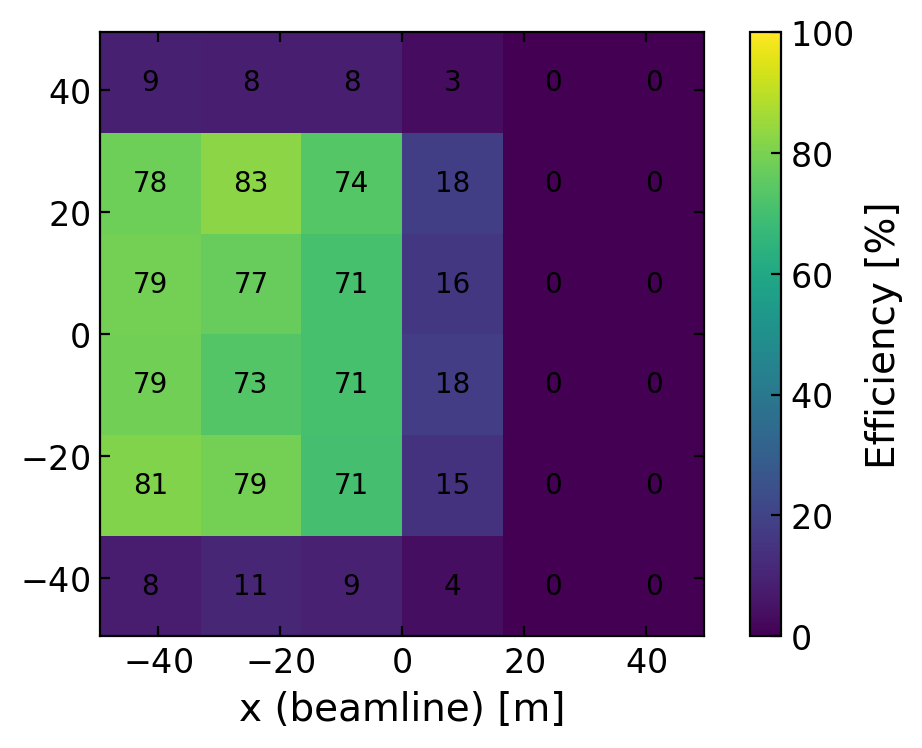

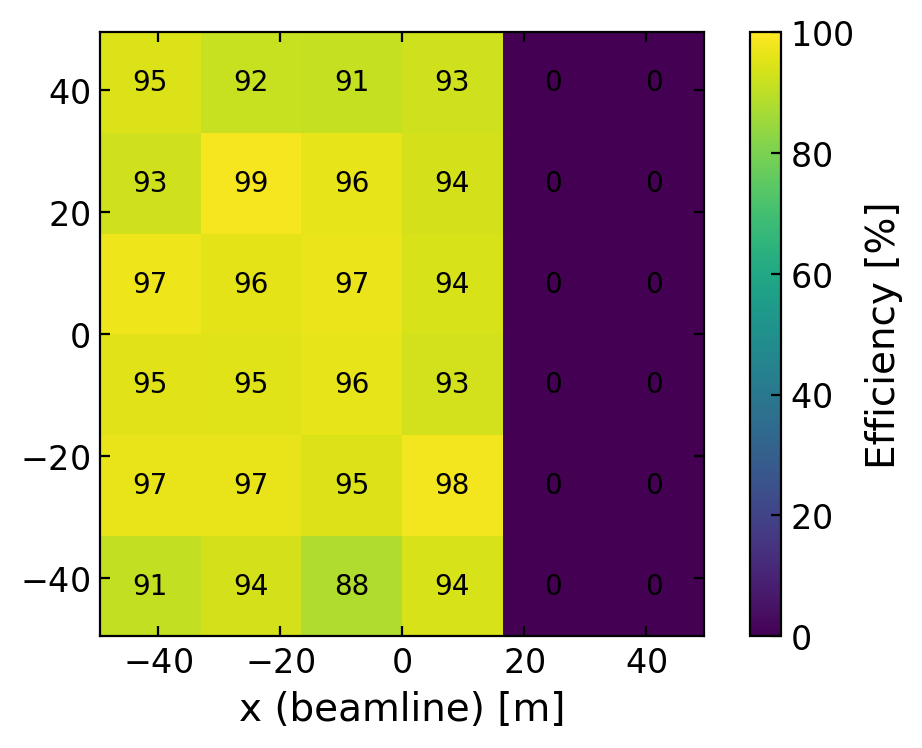

In [10]:
# Define grid
grid_n = 6
grid_x = np.linspace(70,70+99,grid_n+1)*100
grid_y = np.linspace(-99/2,99/2,grid_n+1)*100
grid_z = -np.array([-19,-13,-6,0,6])[::-1]*100

for iz in range(len(grid_z)-1):
    effs = np.zeros((grid_n,grid_n))
    effs_ratio = np.zeros((grid_n,grid_n))
    for ix in range(grid_n):
        for iy in range(grid_n):
            mask_temp = (Vertices_truth_xyz[:,0]>grid_x[ix])&(Vertices_truth_xyz[:,0]<grid_x[ix+1])&\
                        (Vertices_truth_xyz[:,1]>grid_y[iy])&(Vertices_truth_xyz[:,1]<grid_y[iy+1])&\
                        (Vertices_truth_xyz[:,2]>grid_z[iz])&(Vertices_truth_xyz[:,2]<grid_z[iz+1])
            
            mask_temp_raw = (vertex_raw[:,0]>grid_x[ix]*10)&(vertex_raw[:,0]<grid_x[ix+1]*10)&\
                        (vertex_raw[:,1]>grid_y[iy]*10)&(vertex_raw[:,1]<grid_y[iy+1]*10)&\
                        (vertex_raw[:,2]>grid_z[iz]*10)&(vertex_raw[:,2]<grid_z[iz+1]*10)
            
            npass = sum(mask_temp[mask][mask_residual])
            ntotal = sum(mask_temp_raw)
            ntotal_reconstructible = sum(mask_temp[mask_reconstructible])
            effs[ix][iy]=npass/ntotal
            effs_ratio[ix][iy]=npass/ntotal_reconstructible
            if ntotal==0:
                effs[ix][iy]=0
            if ntotal_reconstructible==0:
                effs_ratio[ix][iy]=0                
    print(effs)
    
    fig, ax = plt.subplots()
    img=ax.imshow(effs.T*100, cmap='viridis',vmin=0, vmax=100, extent=[-49.5,49.5,-49.5,49.5],origin="lower")
    xticks = np.linspace(-49.5,49.5, grid_n+1)
    xticks=.5*(xticks[1:]+xticks[:-1])
    yticks = np.linspace(-49.5,49.5, grid_n+1)
    yticks=.5*(yticks[1:]+yticks[:-1])
    
    for (i, j), z in np.ndenumerate(effs):
        ax.text(xticks[i],yticks[j], f'{z*100:.0f}', ha='center', va='center',fontsize=10)
        
    xlabel("x (beamline) [m]")
    
    if iz==0:
        ylabel("y [m]")
    
    if iz==len(grid_z)-2:
        colorbar(img,ax=ax,label="Efficiency [%]")
    savefig(f"{filelables[ifile]}_eff_xy_{iz}")
    plt.show()  
    

    # The second plot-----------------
    
    fig, ax = plt.subplots()
    img=ax.imshow(effs_ratio.T*100, cmap='viridis',vmin=0, vmax=100, extent=[-49.5,49.5,-49.5,49.5],origin="lower")
    xticks = np.linspace(-49.5,49.5, grid_n+1)
    xticks=.5*(xticks[1:]+xticks[:-1])
    yticks = np.linspace(-49.5,49.5, grid_n+1)
    yticks=.5*(yticks[1:]+yticks[:-1])
    
    for (i, j), z in np.ndenumerate(effs_ratio):
        ax.text(xticks[i],yticks[j], f'{z*100:.0f}', ha='center', va='center',fontsize=10)
        
    xlabel("x (beamline) [m]")
    
    if iz==0:
        ylabel("y [m]")
    
    if iz==len(grid_z)-2:
        colorbar(img,ax=ax,label="Efficiency [%]")
    savefig(f"{filelables[ifile]}_effratio_xy_{iz}")
    plt.show()      

### Efficiency vs eta-phi grid

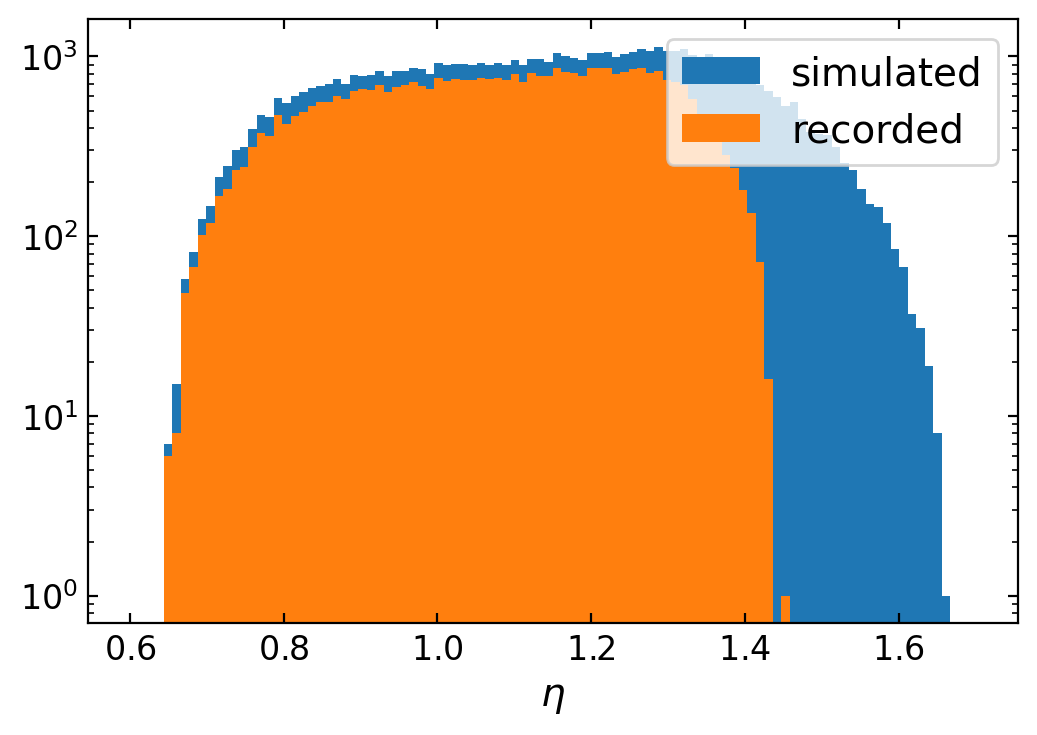

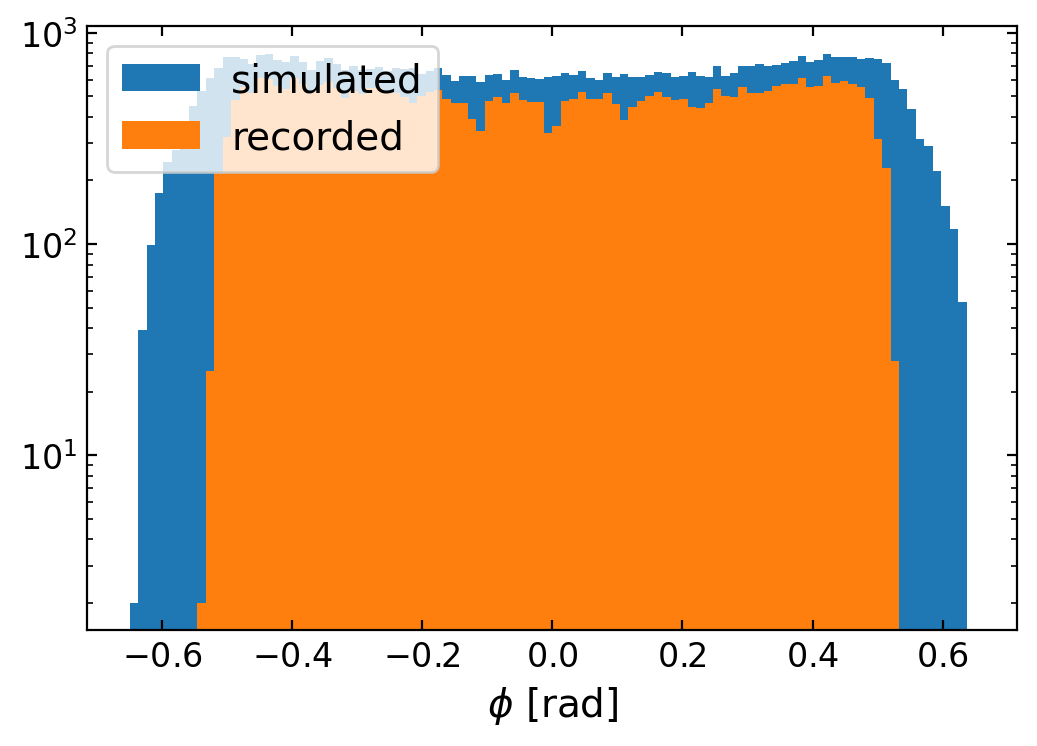

In [20]:
hist(vertex_raw_eta,log=1,label="simulated",range=(0.6,1.7));
hist(Vertices_truth_eta[Vertices_truth_eta>0],log=1,label="recorded",range=(0.6,1.7));
xlabel("$\eta$")
legend()
show()

hist(vertex_raw_phi,log=1,range=(-0.65,0.65),label="simulated");
hist(Vertices_truth_phi[Vertices_truth_eta>0],log=1,label="recorded",range=(-0.65,0.65));
xlabel("$\phi$ [rad]")
legend()
show()

In [11]:
grid_n = 6
theta_range = np.array([np.arctan((84.57+6)/70),np.arctan((84.57-19)/(70+99))])
eta_range = util.theta2eta(theta_range)
phi_range = np.array([-np.arctan(49.5/(85.47-19)),np.arctan(49.5/(85.47-19))])
print(eta_range,phi_range)

[0.71135302 1.67559871] [-0.64009845  0.64009845]


[0.71135302 1.67559871] [-0.64009845  0.64009845]


/tmp/ipykernel_27240/1968864957.py:23: RuntimeWarning: invalid value encountered in long_scalars
  effs_ratio[ix][iy]=npass/ntotal_reconstructible


[[0.0199637  0.75229358 0.71557971 0.69525959 0.72747748 0.69107143
  0.75771971 0.02420857]
 [0.0232859  0.75790285 0.7559633  0.74590164 0.76047904 0.75369004
  0.76367781 0.01976285]
 [0.02071346 0.76036866 0.76362241 0.76795096 0.7605753  0.77838684
  0.76979866 0.01849711]
 [0.01793722 0.74471937 0.78525868 0.77187244 0.75537435 0.76554307
  0.74082702 0.02362205]
 [0.01189296 0.43551913 0.6954282  0.71928571 0.69896194 0.695595
  0.46294307 0.00808081]
 [0.         0.         0.06511309 0.15123675 0.1602289  0.0530086
  0.00078927 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


/tmp/ipykernel_27240/1968864957.py:22: RuntimeWarning: invalid value encountered in long_scalars
  effs[ix][iy]=npass/ntotal


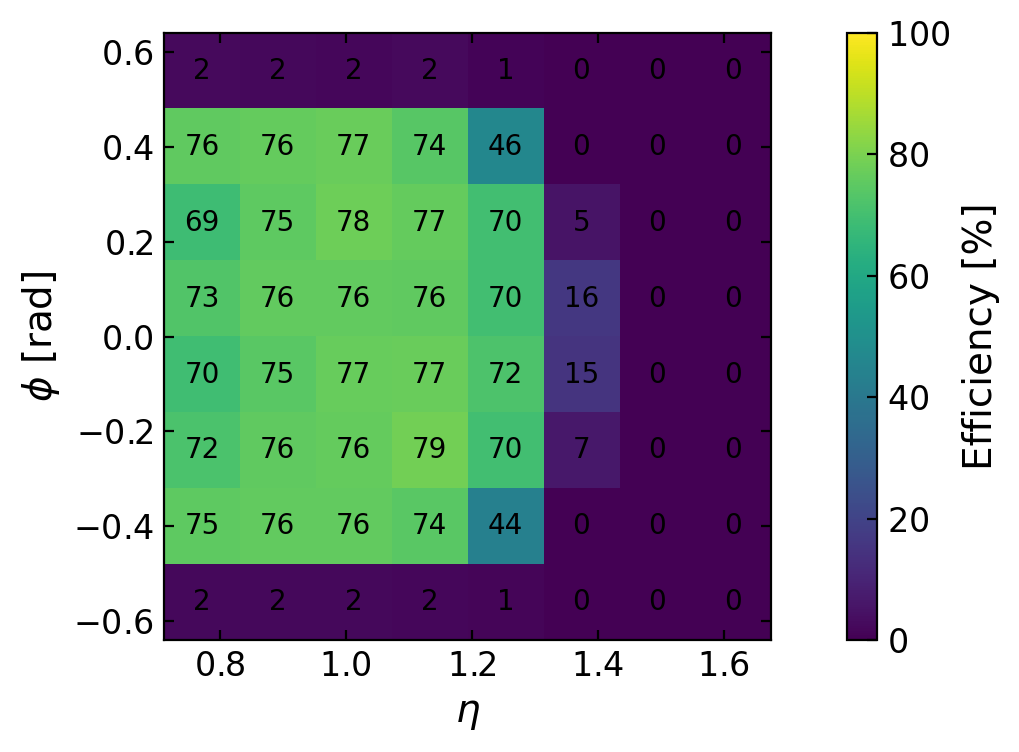

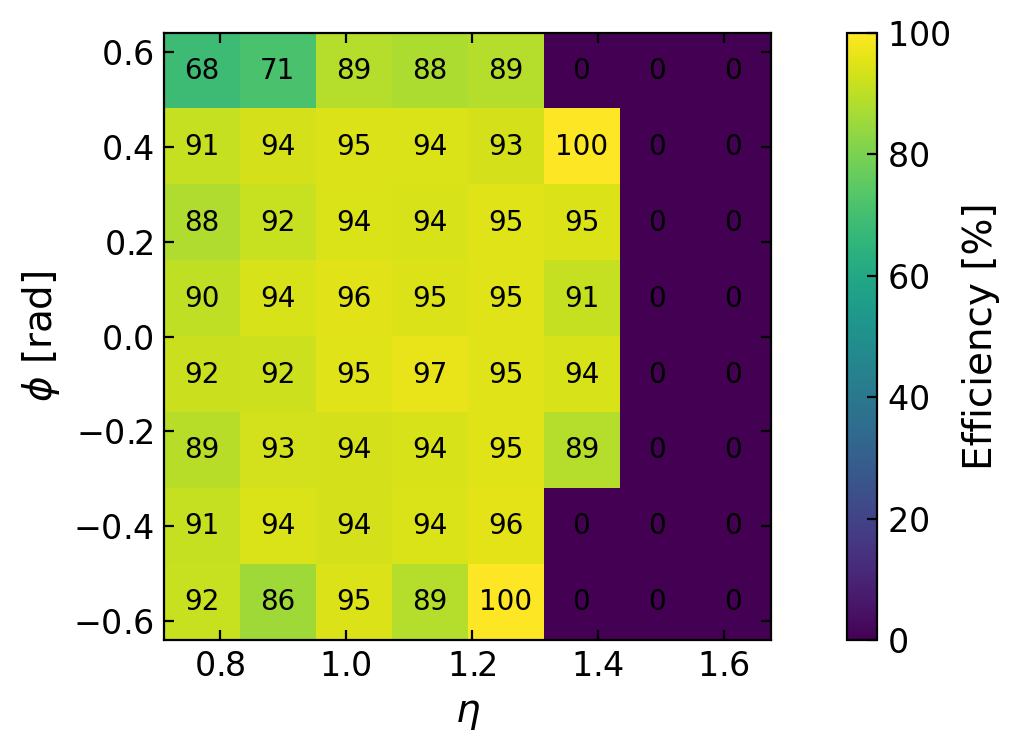

In [12]:
# Define grid
grid_n = 8
theta_range = np.array([np.arctan((84.57+6)/70),np.arctan((84.57-19)/(70+99))])
eta_range = util.theta2eta(theta_range)
phi_range = np.array([-np.arctan(49.5/(85.47-19)),np.arctan(49.5/(85.47-19))])
print(eta_range,phi_range)

grid_eta = np.linspace(eta_range[0],eta_range[1],grid_n+1)
grid_phi = np.linspace(phi_range[0],phi_range[1],grid_n+1)

effs = np.zeros((grid_n,grid_n))
effs_ratio = np.zeros((grid_n,grid_n))
for ix in range(grid_n):
    for iy in range(grid_n):
        mask_temp = (Vertices_truth_eta>grid_eta[ix])&(Vertices_truth_eta<grid_eta[ix+1])&\
                    (Vertices_truth_phi>grid_phi[iy])&(Vertices_truth_phi<grid_phi[iy+1])
        mask_temp_raw = (vertex_raw_eta>grid_eta[ix])&(vertex_raw_eta<grid_eta[ix+1])&\
                    (vertex_raw_phi>grid_phi[iy])&(vertex_raw_phi<grid_phi[iy+1])        
        npass = sum(mask_temp[mask][mask_residual])
        ntotal = sum(mask_temp_raw)
        ntotal_reconstructible = sum(mask_temp[mask_reconstructible])
        effs[ix][iy]=npass/ntotal
        effs_ratio[ix][iy]=npass/ntotal_reconstructible
        if ntotal==0:
            effs[ix][iy]=0
        if ntotal_reconstructible==0:
            effs_ratio[ix][iy]=0   
print(effs)



fig, ax = plt.subplots(figsize=(8,4))
img=ax.imshow(effs.T*100, cmap='viridis',vmin=0, vmax=100, extent=[*eta_range,*phi_range],aspect=(eta_range[1]-eta_range[0])/(phi_range[1]-phi_range[0]),origin="lower")
xticks = np.linspace(*eta_range, grid_n+1)
xticks=.5*(xticks[1:]+xticks[:-1])
yticks = np.linspace(*phi_range, grid_n+1)
yticks=.5*(yticks[1:]+yticks[:-1])

for (i, j), z in np.ndenumerate(effs):
    ax.text(xticks[i],yticks[j], f'{z*100:.0f}', ha='center', va='center',fontsize=10)

xlabel("$\eta$")
ylabel("$\phi$ [rad]")

colorbar(img,ax=ax,label="Efficiency [%]")
tight_layout()
savefig(f"{filelables[ifile]}_eff_eta_phi")
plt.show()   



fig, ax = plt.subplots(figsize=(8,4))
img=ax.imshow(effs_ratio.T*100, cmap='viridis',vmin=0, vmax=100, extent=[*eta_range,*phi_range],aspect=(eta_range[1]-eta_range[0])/(phi_range[1]-phi_range[0]),origin="lower")
xticks = np.linspace(*eta_range, grid_n+1)
xticks=.5*(xticks[1:]+xticks[:-1])
yticks = np.linspace(*phi_range, grid_n+1)
yticks=.5*(yticks[1:]+yticks[:-1])

for (i, j), z in np.ndenumerate(effs_ratio):
    ax.text(xticks[i],yticks[j], f'{z*100:.0f}', ha='center', va='center',fontsize=10)

xlabel("$\eta$")
ylabel("$\phi$ [rad]")

colorbar(img,ax=ax,label="Efficiency [%]")
tight_layout()
savefig(f"{filelables[ifile]}_effratio_eta_phi")
plt.show()    

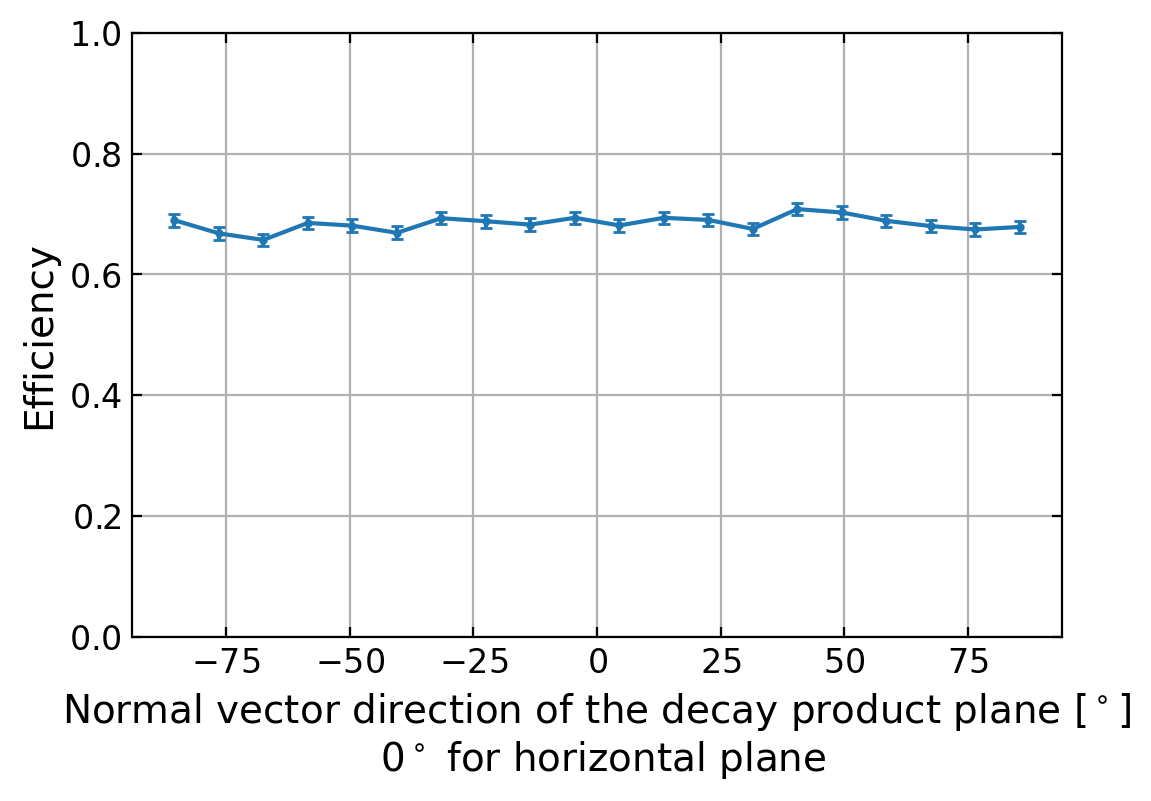

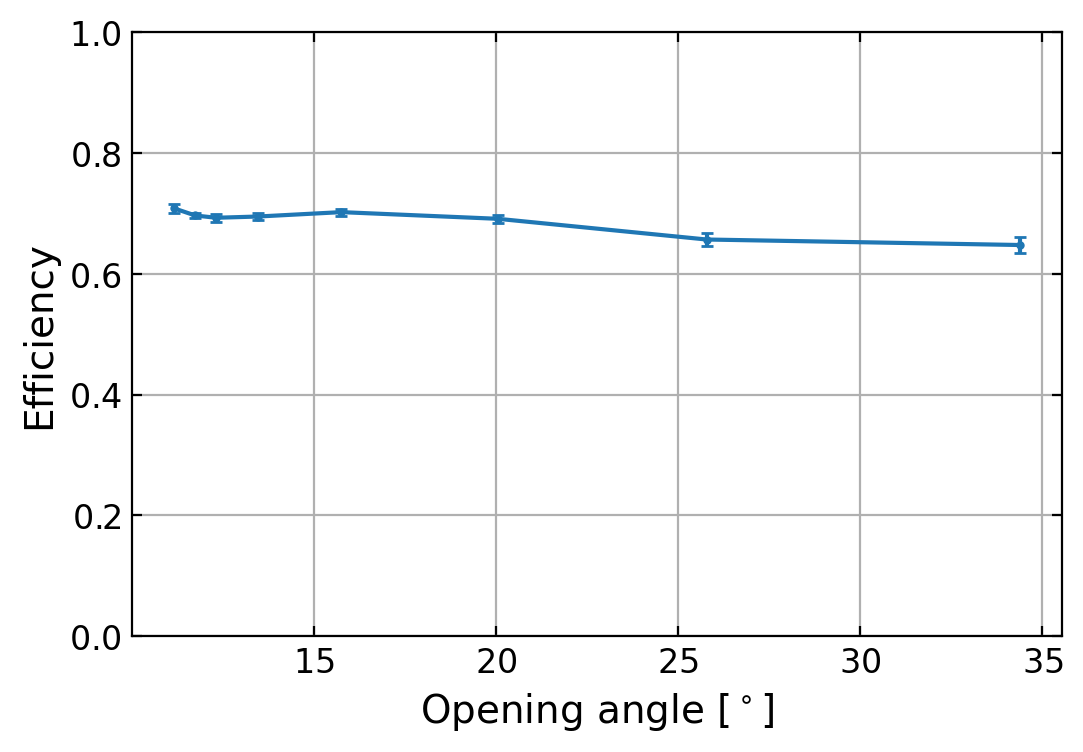

In [27]:
plane_angle_cuts_ranges = np.linspace(0,np.pi,21)
plane_angle_cuts_centers = util.Utils.center(plane_angle_cuts_ranges)
plane_angle_eff=[]
for i in range(len(plane_angle_cuts_centers)):
    mask_angle = (Vertices_plane_angle>plane_angle_cuts_ranges[i]) & (Vertices_plane_angle<plane_angle_cuts_ranges[i+1])
    
    n_pass = np.sum(mask_angle[mask][mask_residual])
    n_total = np.sum(mask_angle)
    eff_output = rt.BayesDivide([n_pass],[n_total])
    plane_angle_eff.append([eff_output[0][0],eff_output[1][0], eff_output[2][0]])
    
    
plane_angle_eff=np.array(plane_angle_eff)
errorbar(plane_angle_cuts_centers*180/np.pi-90,plane_angle_eff[:,0],yerr=[plane_angle_eff[:,1],plane_angle_eff[:,2]],fmt="o-",capsize=2,markersize=2);
ylim(0,1)   
xlabel(r"Normal vector direction of the decay product plane [$^\circ$]"+"\n $0^\circ$ for horizontal plane")
ylabel("Efficiency")
grid()
show()


open_angle_cuts_ranges = np.array([0.19,0.2,0.21,0.22,0.25,0.3,0.4, 0.5,0.7])
open_angle_cuts_centers = util.Utils.center(open_angle_cuts_ranges)
open_angle_eff=[]
for i in range(len(open_angle_cuts_centers)):
    mask_angle = (Vertices_opening_angle>open_angle_cuts_ranges[i]) & (Vertices_opening_angle<open_angle_cuts_ranges[i+1])
    
    n_pass = np.sum(mask_angle[mask][mask_residual])
    n_total = np.sum(mask_angle)
    eff_output = rt.BayesDivide([n_pass],[n_total])
    open_angle_eff.append([eff_output[0][0], eff_output[1][0], eff_output[2][0]])
    
    
open_angle_eff=np.array(open_angle_eff)
errorbar(open_angle_cuts_centers*180/np.pi,open_angle_eff[:,0],yerr=[open_angle_eff[:,1],open_angle_eff[:,2]],fmt="o-",capsize=2,markersize=2);
ylim(0,1)   
xlabel("Opening angle [$^\circ$]")
ylabel("Efficiency")
grid()
show()

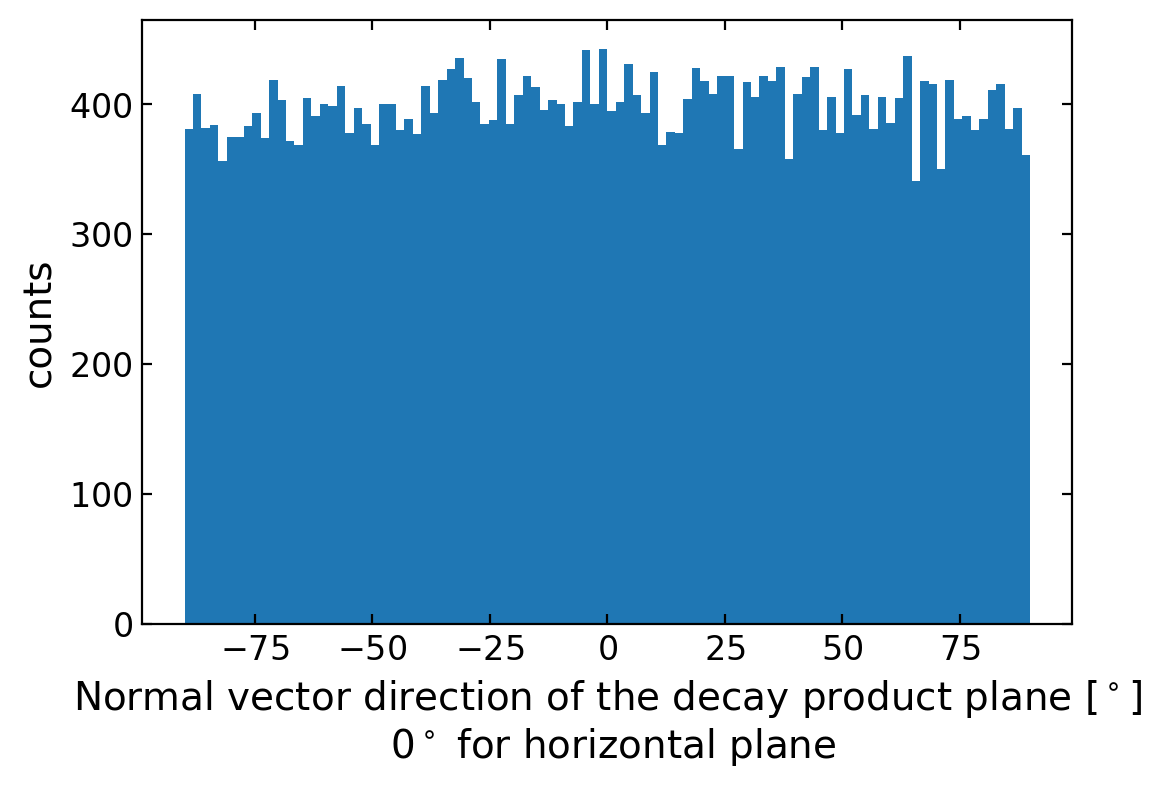

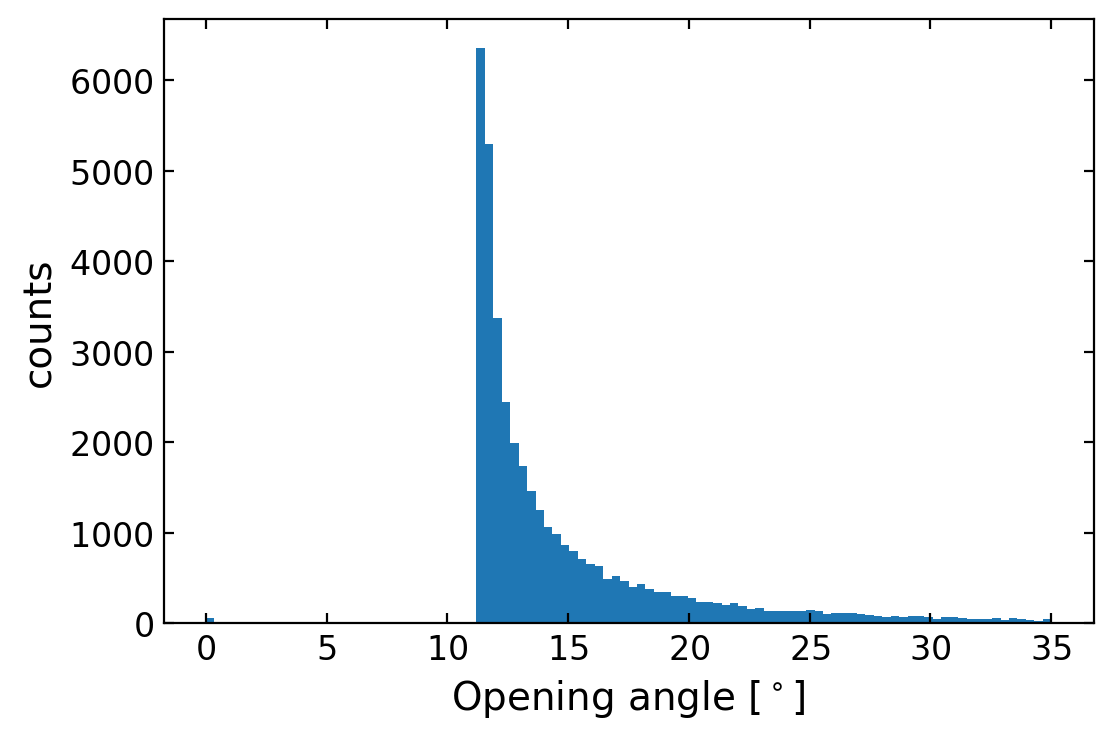

In [28]:
hist(Vertices_plane_angle*180/np.pi-90, range=(-90,90));
xlabel(r"Normal vector direction of the decay product plane [$^\circ$]"+"\n $0^\circ$ for horizontal plane")
ylabel("counts")
show()
hist(Vertices_opening_angle*180/np.pi, range=(0,35));
xlabel("Opening angle [$^\circ$]")
ylabel("counts")
show()

In [13]:
track_purity_1d = util.Utils.flatten1d(data["tracks_purity"])
track_purity_1d = track_purity_1d[track_purity_1d>0]              
track_purity_1d_avg = np.array([np.mean(i) for i in data["tracks_purity"]])
tracks_purity = util.appcut(data["tracks_purity"], mask )
tracks_purity = np.array([np.mean(i) for i in tracks_purity])
tracks_purity_nonvertex = util.appcut(data["tracks_purity"], (~mask)&mask_reconstructible)
tracks_purity_nonvertex = np.array([np.mean(i) for i in tracks_purity_nonvertex])


print("K_reconstructible,",sum(mask_reconstructible)/n_original)
print("  -reconstructed,",sum(mask)/len(mask))
print("Percentage of single track purity=1:",sum(track_purity_1d==1)/len(track_purity_1d))          
print("Percentage of event-averaged track purity=1:", sum(track_purity_1d_avg==1)/len(data["tracks_purity"]))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


K_reconstructible, 0.4882
  -reconstructed, 0.5373131507833021
Percentage of single track purity=1: 0.8794224558659541
Percentage of event-averaged track purity=1: 0.5015968403348641



### Check the seed cut threshold in processing

100%|██████████| 8269/8269 [00:05<00:00, 1597.88it/s]


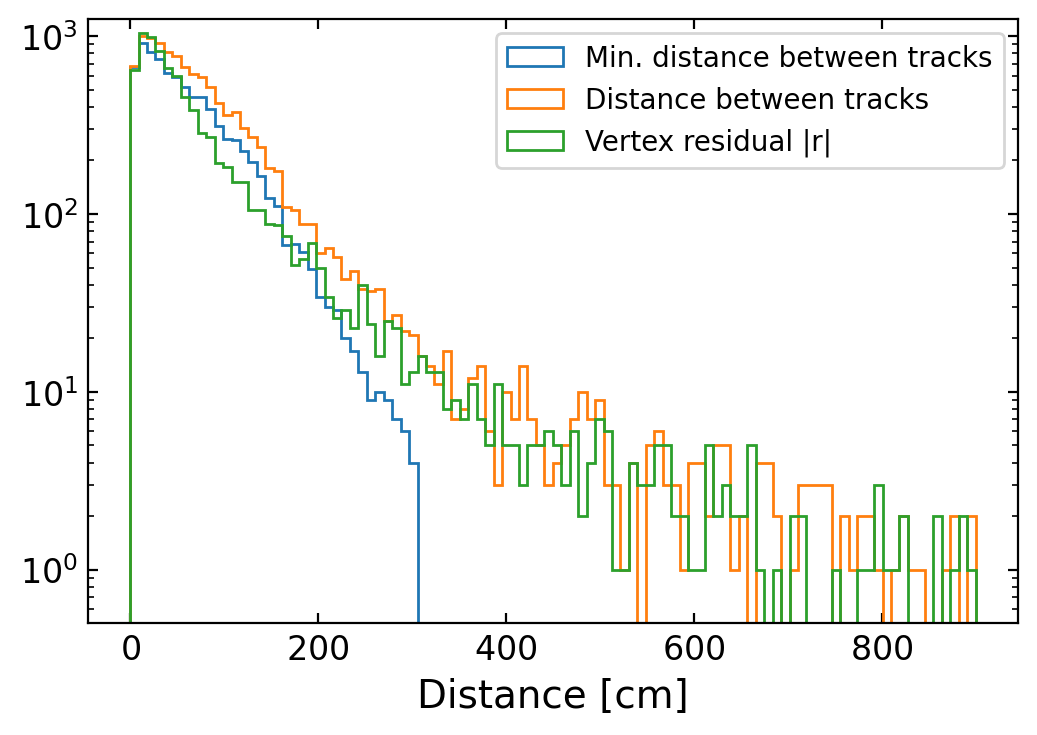

Events with seed 8269 
 All events 8269


In [21]:
# Use the analytical calcualation of the midpoint of two lines

dist_direct  = [] # The distance between two lines. Taking the minimum distance in each event
dist_direct_all  = [] # The distance between two lines. all line pairs
residual_direct  = [] # Distance from the midpoint to the vertex truth
for i in tqdm(Entry):
    Tree.GetEntry(i)
    if Tree.Track_k_m_x0.size()>=2:
        tracks = []
        for track_ind in range(Tree.Track_k_m_x0.size()):
            track_1 =np.array([Tree.Track_k_m_x0.at(track_ind), Tree.Track_k_m_y0.at(track_ind), Tree.Track_k_m_z0.at(track_ind),Tree.Track_k_m_velX.at(track_ind), Tree.Track_k_m_velY.at(track_ind), Tree.Track_k_m_velZ.at(track_ind), Tree.Track_k_m_t0.at(track_ind)])
            tracks.append(track_1)
            
        dists=[]
        residuals=[]
        for i in range(len(tracks)):
            for j in range(i+1, len(tracks)):
                position,t,dist = closest_approach_midpoint(tracks[i],tracks[j])
                residual_i = position-Vertices_truth[i][:3]
                residuals.append(np.linalg.norm(residual_i))
                dists.append(dist)
        dist_direct.append(min(dists))
        dist_direct_all.extend(dists)
        residual_direct.append(min(residuals))
dist_direct=np.array(dist_direct)
dist_direct_all=np.array(dist_direct_all)
residual_direct=np.array(residual_direct)


n,ibins,p=hist(dist_direct,range=(0,900),histtype="step",label="Min. distance between tracks");
n,ibins,p=hist(dist_direct_all,range=(0,900),histtype="step",label="Distance between tracks");
n,ibins,p=hist(residual_direct,range=(0,900),histtype="step",label="Vertex residual |r|");
# bincenters=0.5*(ibins[1:]+ibins[:-1])
# yerr=np.sqrt(n);yerr[yerr==0]=1
# popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
# print(popt[2],'[cm]')
# plot(bincenters, util.Utils.Gauss(bincenters,*popt),color="C0")
yscale("log")
xlabel("Distance [cm]")
legend(fontsize=10,loc="upper right")
ylim(bottom=0.5,top=max([max(n)])*1.2)
show()

print("Events with seed", sum(dist_direct<500),"\n All events",len(dist_direct))
        

19.744880559661073 [cm]
5.9293756049743465 [cm]


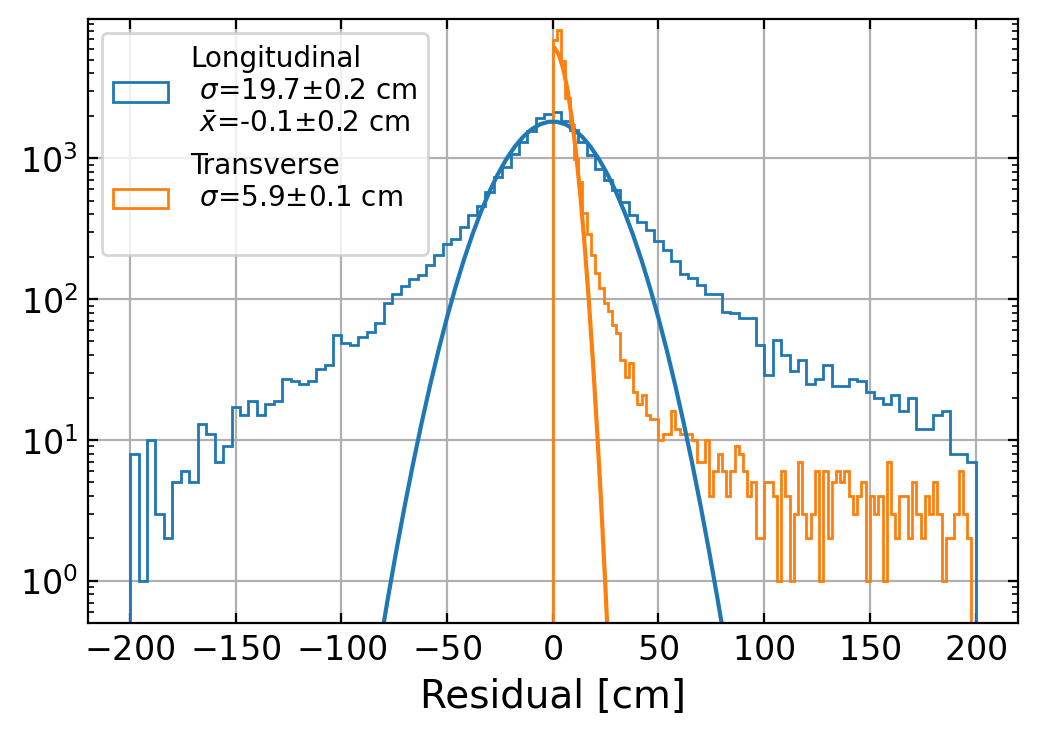

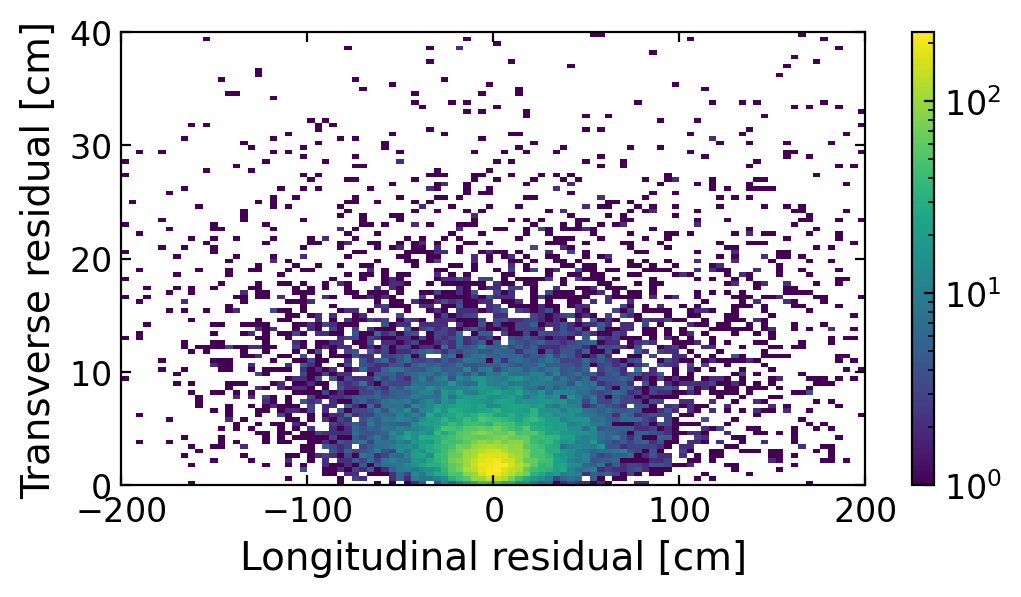

1.4266607294892297


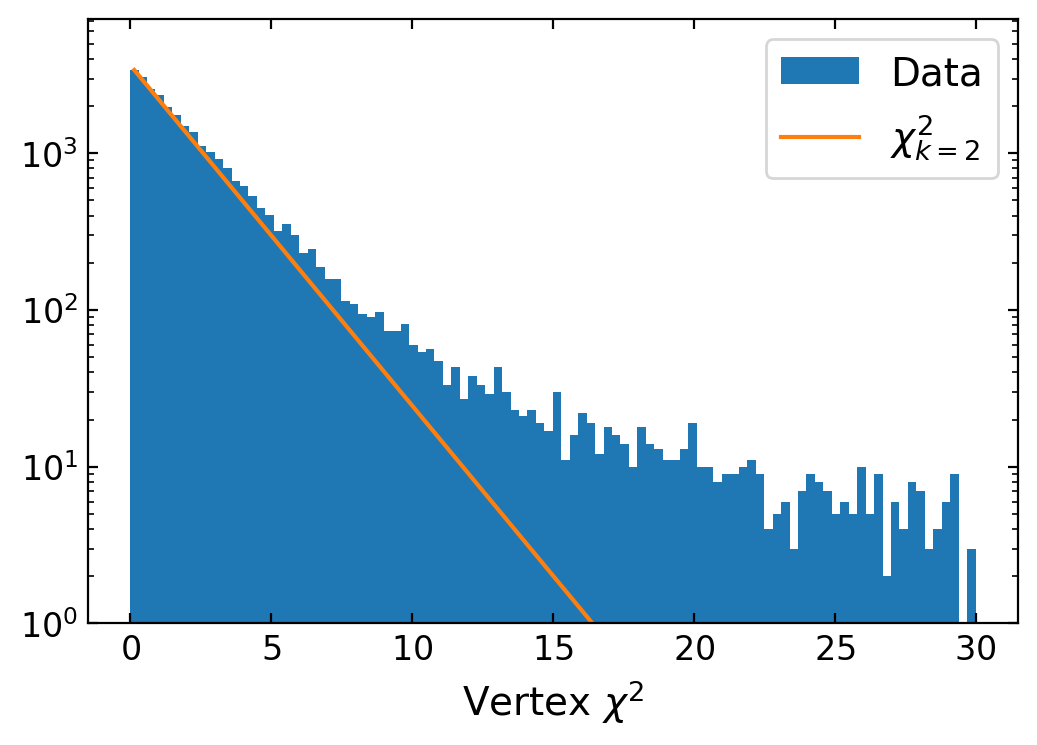

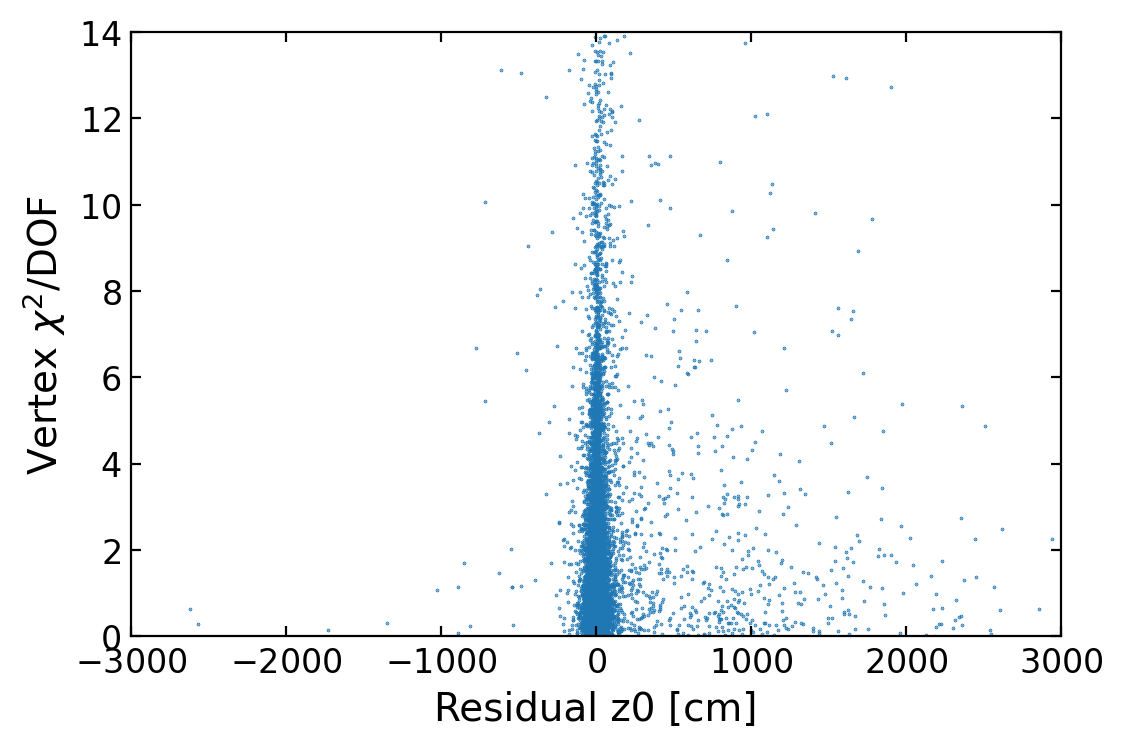

In [14]:
# Figure 1, longi vs axial
n,ibins,p=hist(residual_axial,range=(-200,200),histtype="step",label="Longitudinal");
n2,ibins2,p=hist(residual_radial,range=(0,200),histtype="step",label="Transverse");

bincenters=0.5*(ibins[1:]+ibins[:-1])
bincenters2=0.5*(ibins2[1:]+ibins2[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1
yerr2=np.sqrt(n2);yerr2[yerr2==0]=1

popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(-40,40))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[cm]')
plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0")
popt2,pcov = rt.fit_tg(bincenters2,n2,yerr=yerr2,function="gaus",set_constant=[[1,0]],initial_values=[max(n2),0,3],fit_range=(5,15),option="BQS")
perr2 = np.sqrt(np.diag(pcov))
print(popt2[2],'[cm]')
plot(bincenters2, util.Utils.Gauss(bincenters2,*popt2),color="C1")
yscale("log")
xlabel("Residual [cm]")
legend(fontsize=10,loc="upper left")
handles, labels = gca().get_legend_handles_labels()
labels[0] = labels[0]+f"\n $\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} cm\n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} cm"
labels[1] = labels[1]+f"\n $\sigma$={popt2[2]:.1f}$\pm${perr2[2]:.1f} cm\n "
legend(handles, labels,fontsize=10,loc="upper left")
grid()
ylim(bottom=0.5,top=max([max(n),max(n2)])*1.2)
savefig(f"{filelables[ifile]}_resolution_position")
show()


# Figure 2
subplots(figsize=(6,3))
hist2d(residual_axial, residual_radial,range=((-200,200),(0,40)),bins=(100,100),norm=LogNorm());
xlabel("Longitudinal residual [cm]")
ylabel("Transverse residual [cm]")
colorbar()
savefig(f"{filelables[ifile]}_longi_vs_trans")
show()


# Figure 3
dof = 2

n,ibins,p = hist(Vertices_chi2*dof,range=(0,30),label="Data");
bincenters = util.Utils.center(ibins)
y = scipy.stats.chi2.pdf(bincenters,dof)
plot(bincenters,y/sum(y[:1])*sum(n[:1]),label=r"$\chi^2_{k=2}$")
yscale("log")
xlabel("Vertex $\chi^2$")
print(np.mean(Vertices_chi2))
legend()
ylim(1,)
savefig(f"{filelables[ifile]}_chi2")
show()


# Figure 4
scatter(residual[:,1], Vertices_chi2,s=0.1);
xlabel("Residual z0 [cm]")
ylabel("Vertex $\chi^2$/DOF")
xlim(-3000,3000)
ylim(0,14)
show()

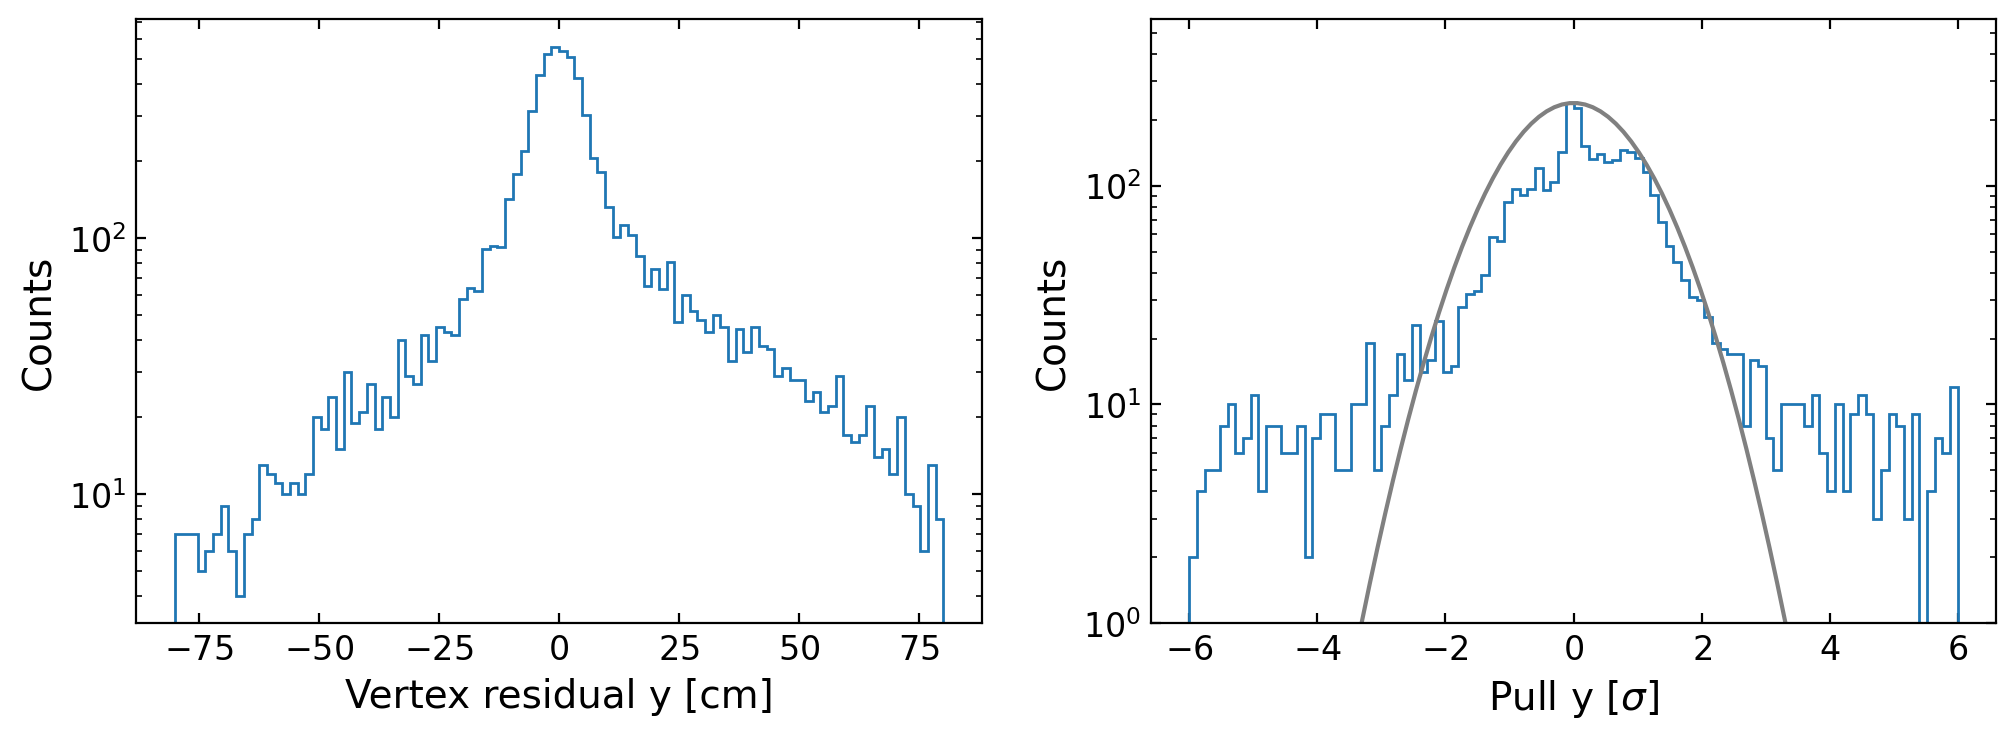

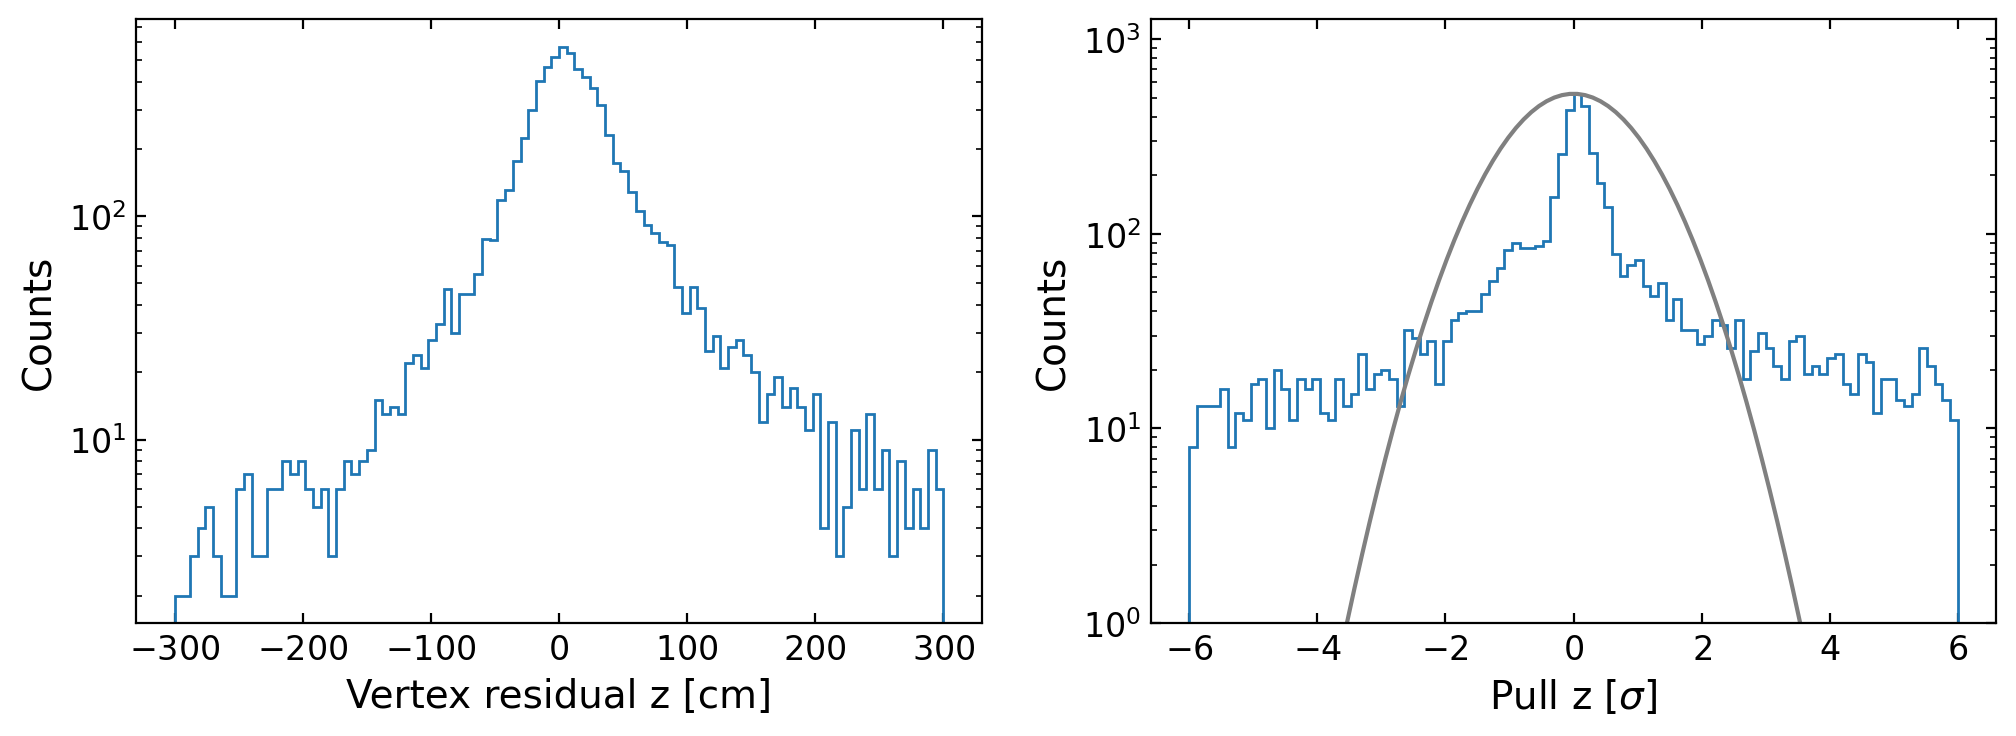

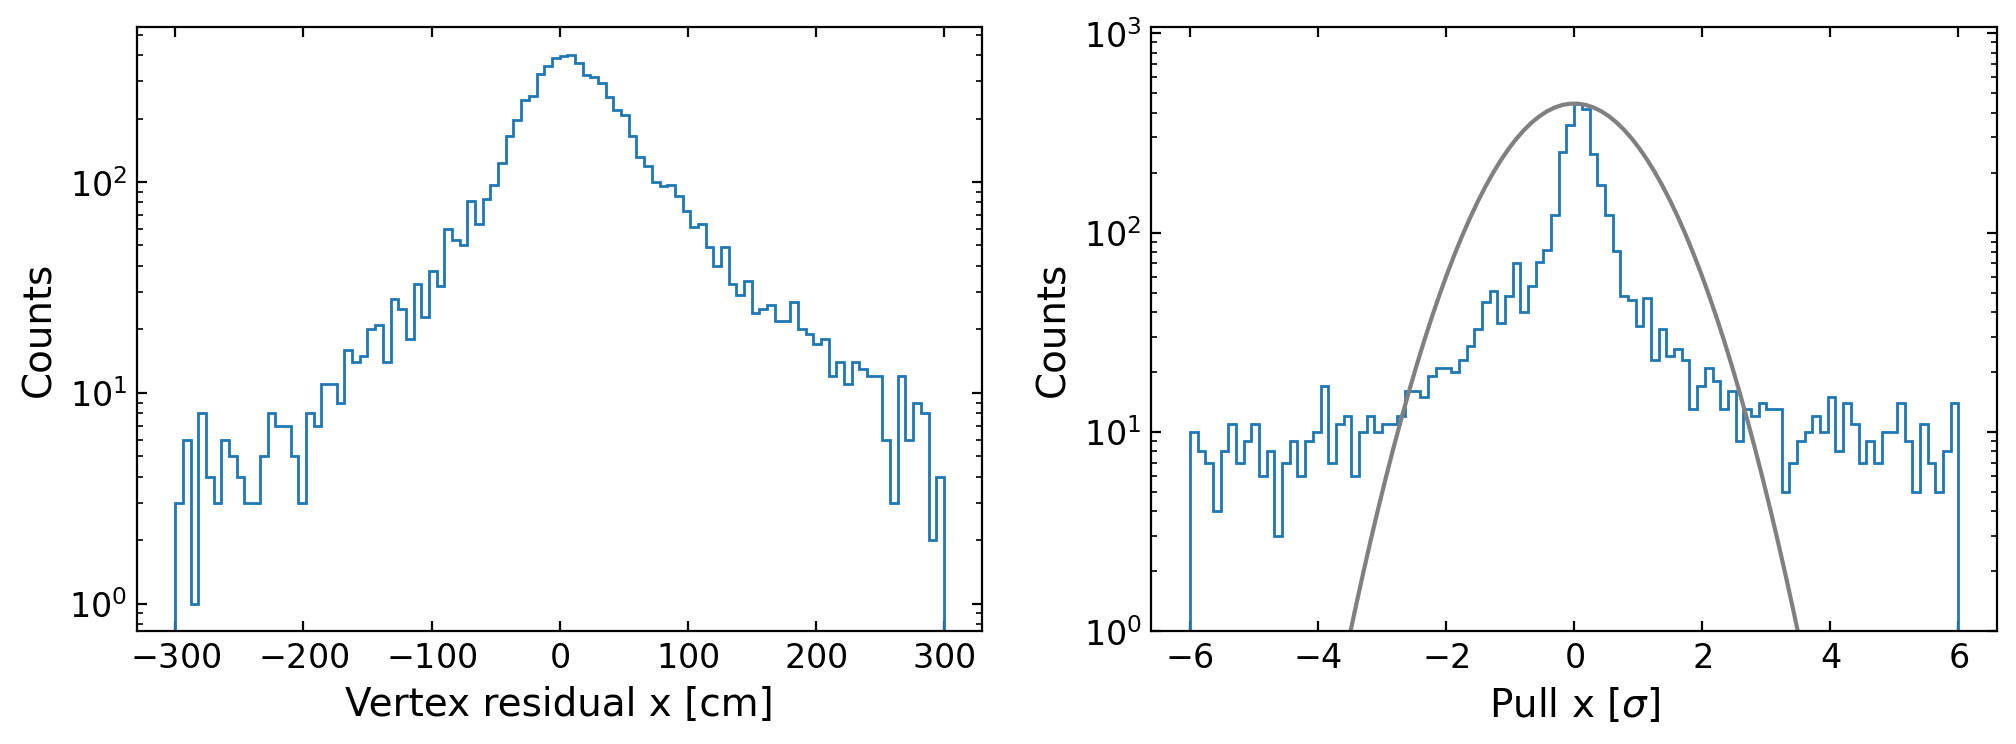

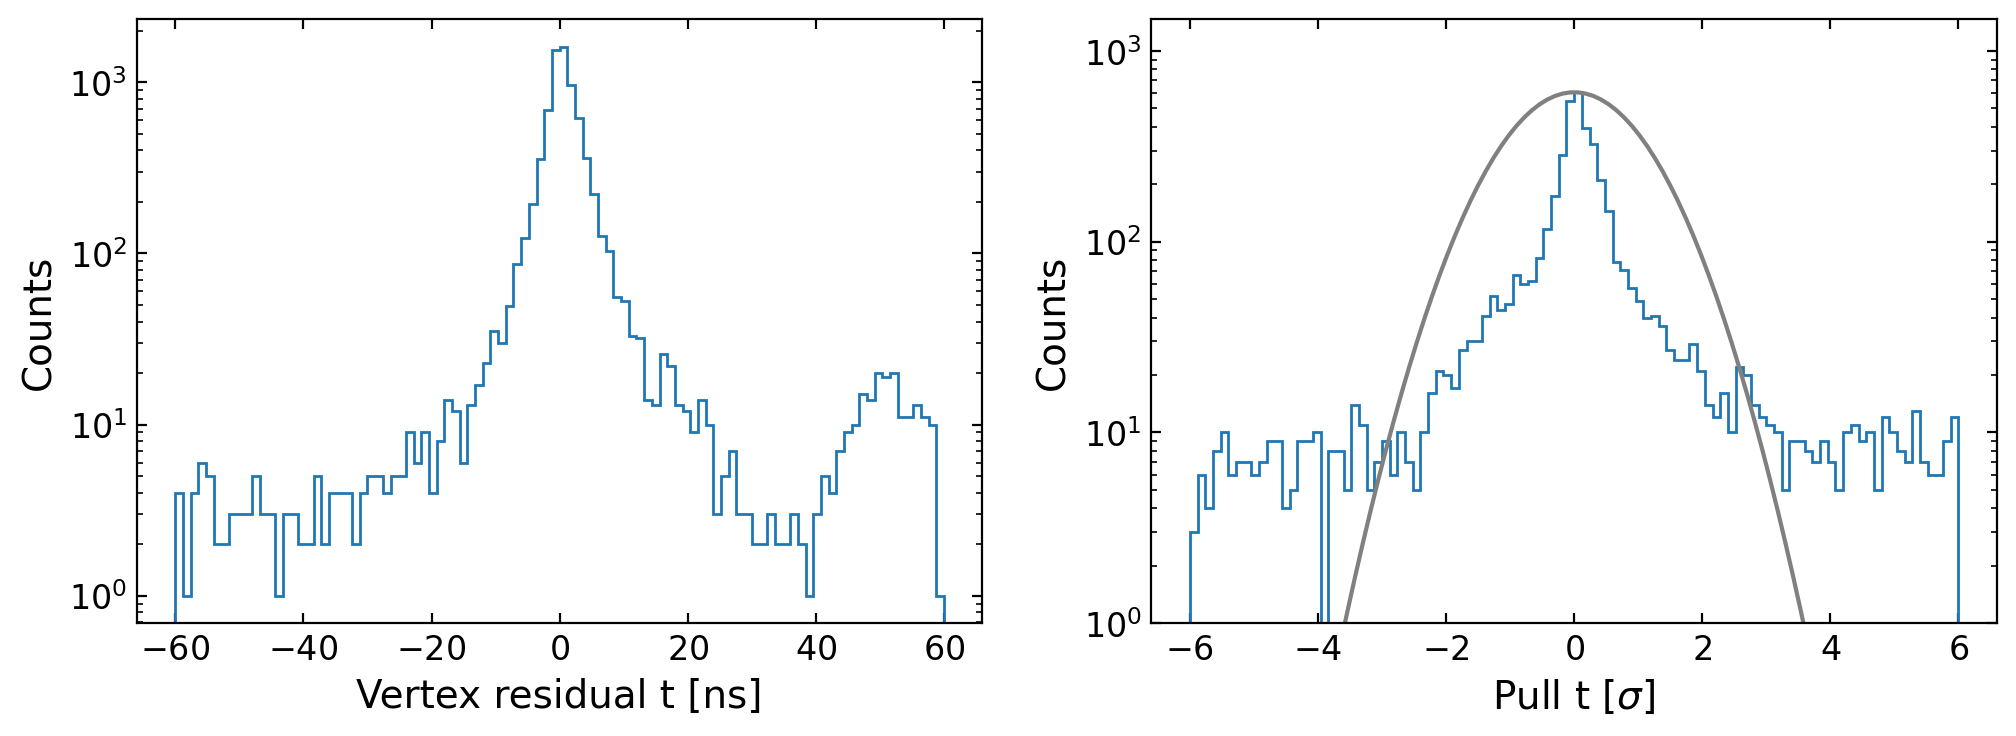

In [23]:
labels=["y [cm]", "z [cm]", "x [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-80,80],[-300,300],[-300,300],[-60,60],[0,900]]

plotlabels = ["Original", "+Bug fix", "+Seed mod"]

# for i in [3,4]:
for i in [0,1,2,3]:
    fig, axs=subplots(1,2,figsize=(12,4))
    unc = Vertices_err

    sca(axs[0])
    n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i],histtype="step");    
    sca(axs[1])
    if i==4:
        #unc_i = 1/residual[:,4]*np.sqrt(residual[:,1]**2*unc[:,1]**2 + residual[:,2]**2*unc[:,2]**2 + residual[:,0]**2*unc[:,0]**2 )
        unc_i=[]
        for ievent in range(len(Vertices_cov)):
            cov = Vertices_cov[ievent][:3,:3]
            # cov =np.diag(np.diag(cov))
            delta_r = residual[ievent,:3]
            unc_i.append(sqrt(delta_r@cov@delta_r)/residual[ievent,4])
    else:
        unc_i =unc[:,i]
    pull = util.pull(residual[:,i],0,unc_i)

    n0,ibins,_ = hist(pull,range=[-6,6],histtype="step"); 
    ibins=util.Utils.center(ibins)
    plot(ibins,util.Utils.Gauss(ibins,max(n0),0,1),color="grey")
    
    sca(axs[0])
    xlabel("Vertex residual "+labels[i])
    ylabel("Counts")
    yscale("log")
    sca(axs[1])
    xlabel("Pull "+labels[i].split(" ")[0]+r" [$\sigma$]")
    ylabel("Counts")
    yscale("log")  
    ylim(bottom=1)
    show()

0.5599520383693045


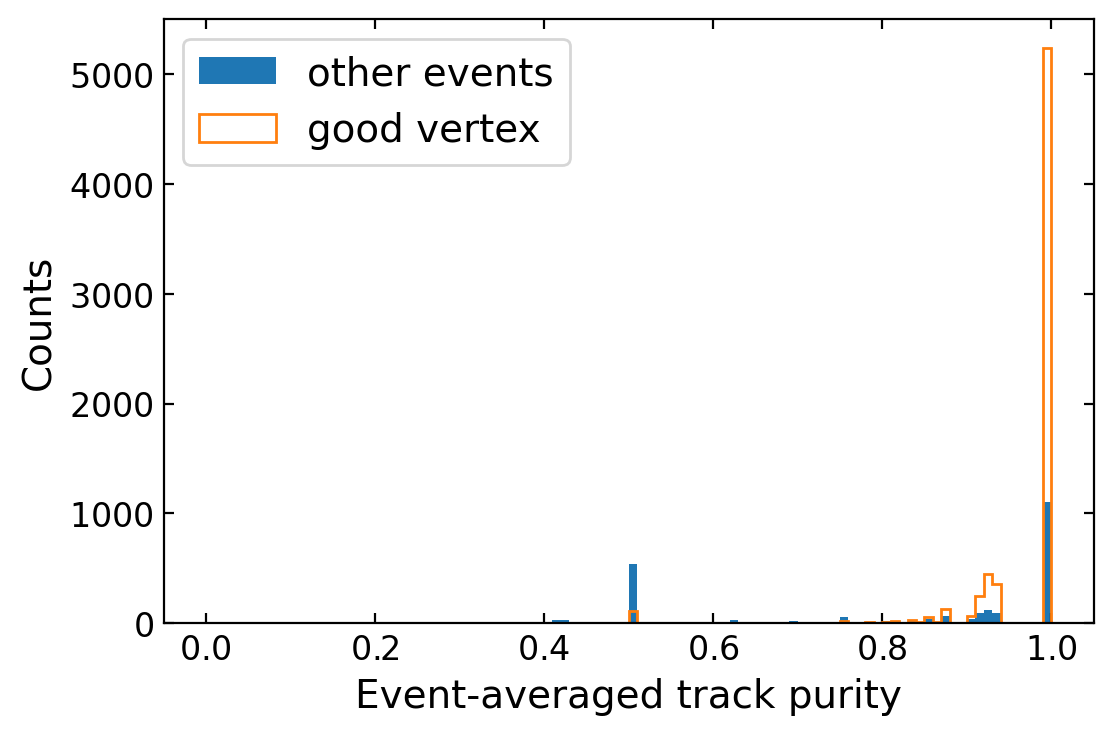

In [24]:
purity = np.concatenate((tracks_purity_nonvertex,tracks_purity[~mask_residual]))
hist(purity,range=(0,1),label="other events");
hist(tracks_purity[mask_residual],range=(0,1),histtype="step",label="good vertex");
xlabel("Event-averaged track purity")
ylabel("Counts")
legend(loc="upper left")
print(sum(purity<1)/len(purity))

In [25]:

joblib.dump({"residual":residual,"uncertainty":Vertices_err, "tracks_purity":tracks_purity,"tracks_purity_nonvertex":tracks_purity_nonvertex,"cov":Vertices_cov}, os.path.splitext(filename_recon)[0]+"_res.joblib")

['/project/def-mdiamond/tomren/mathusla/data/fit_study_6layer/filereader_muon_M4000_P40000_N10000_side/20230611/191631//stat_vertex_original_res.joblib']

### What caused those with track purity <1?

In [82]:
track_purity = []
track_chi2 = []
track_nhits = []
track_deltachi2_add_truth = []
track_deltachi2_add_false = []
track_deltachi2_truth = []
track_deltachi2_false = []

# track_hitinds_nontruth_delta = []
# track_hitinds_nontruth_mix = []

# for i in tqdm(range(30)):
for i in tqdm(range(nevents)):
    Tree.GetEntry(i)
    
    ntracks =  Tree.Track_k_m_t0.size()
    if ntracks>=2:
        track_simIDs = util.unzip(Tree.Track_k_m_ids)
        track_smoothchi_delta = util.unzip(Tree.Track_k_m_smoothchi)
        track_forwardchi_delta = util.unzip(Tree.Track_k_m_filterchi)
        track_simIDs = [np.array(i) for i in track_simIDs]
        track_smoothchi_delta = [np.array(i) for i in track_smoothchi_delta]
        track_forwardchi_delta = [np.array(i) for i in track_forwardchi_delta]
        track_1_nids = [np.sum(i==1) for i in track_simIDs]
        track_2_nids = [np.sum(i==2) for i in track_simIDs]
        i_track1 = np.argmax(track_1_nids)
        i_track2 = np.argmax(track_2_nids)
        if i_track1==i_track2:
            continue
        else:
            track1=track_simIDs[i_track1]
            track2=track_simIDs[i_track2]
            track_nhits.append(len(track1))
            track_nhits.append(len(track2))
            track_purity.append(sum(track1==1)/len(track1))
            track_purity.append(sum(track2==2)/len(track2))
            track_chi2.append(Tree.Track_k_m_smooth_chi_sum.at(int(i_track1)))
            track_chi2.append(Tree.Track_k_m_smooth_chi_sum.at(int(i_track2)))
            track_deltachi2_truth.append(track_smoothchi_delta[i_track1][track1==1])
            track_deltachi2_truth.append(track_smoothchi_delta[i_track2][track2==2])
            track_deltachi2_false.append(track_smoothchi_delta[i_track1][track1!=1])
            track_deltachi2_false.append(track_smoothchi_delta[i_track2][track2!=2])   
            track_deltachi2_add_truth.append(track_forwardchi_delta[i_track1][(track1==1)[1:]])
            track_deltachi2_add_truth.append(track_forwardchi_delta[i_track2][(track2==2)[1:]])
            track_deltachi2_add_false.append(track_forwardchi_delta[i_track1][(track1!=1)[1:]])
            track_deltachi2_add_false.append(track_forwardchi_delta[i_track2][(track2!=2)[1:]])               
        
                                   
    
track_chi2=np.array(track_chi2)
track_purity=np.array(track_purity)

100%|██████████| 10000/10000 [00:06<00:00, 1513.33it/s]


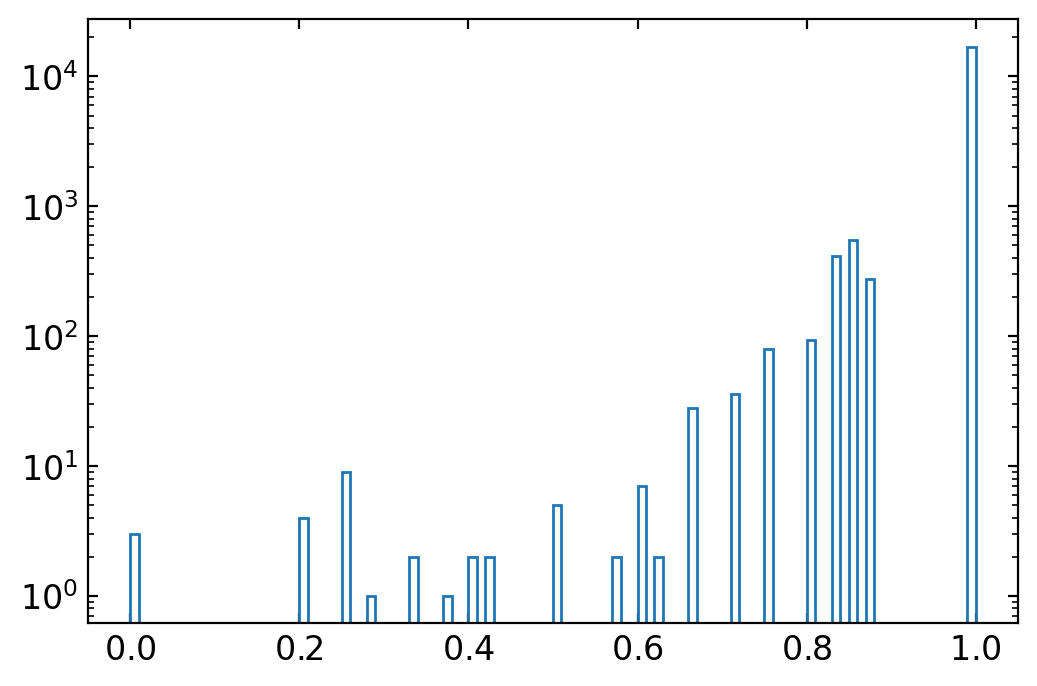

In [83]:
hist(track_purity,histtype="step",log=1);


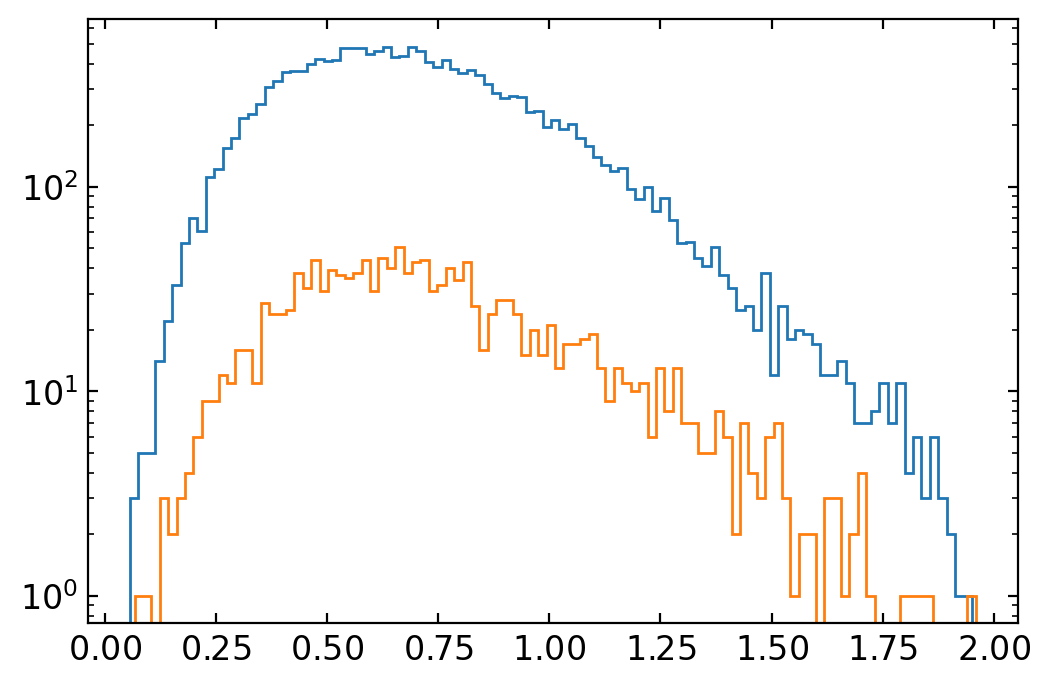

In [84]:
hist(track_chi2[track_purity==1],histtype="step");
hist(track_chi2[track_purity<1],histtype="step");
yscale("log")

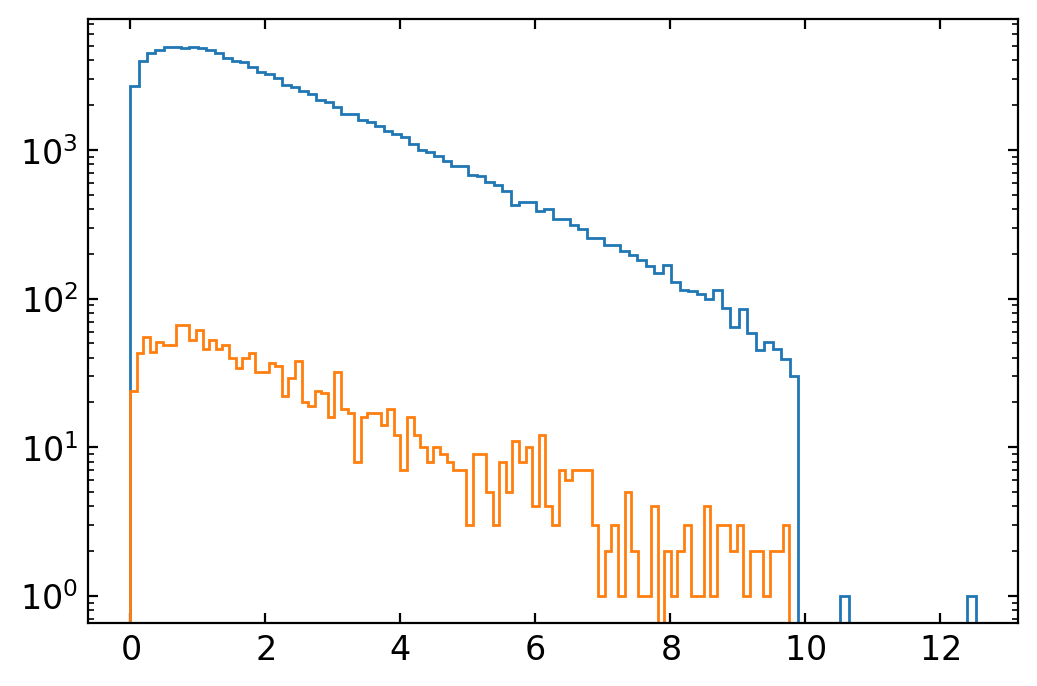

In [85]:
hist(util.Utils.flatten1d(track_deltachi2_truth), histtype="step");
hist(util.Utils.flatten1d(track_deltachi2_false), histtype="step");
yscale("log")

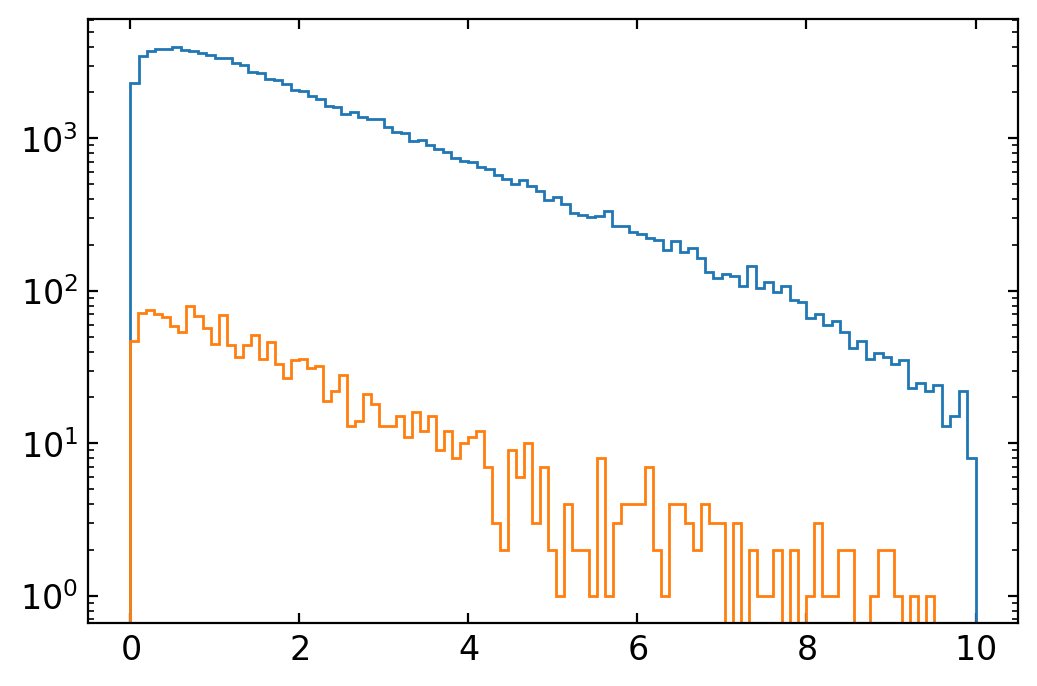

In [86]:
hist(util.Utils.flatten1d(track_deltachi2_add_truth), histtype="step");
hist(util.Utils.flatten1d(track_deltachi2_add_false), histtype="step");
yscale("log")

## Events faild because of seed

Some events did not get the muon vertex. Instead, the vertex from delta ray is picked. And since one muon track is already used in the delta ray vertex, it is not able to find the muon vertex.

This can be mitigated by changing the score of vertex seed to prefer track pairs with the most amount of hits. Delta rays tends to have fewer hits and thus get lower priority.

In [ ]:
dist_12 = []
dist_non12 = []
total_layers_12=[]
total_layers_non12=[]
total_unc_12=[]
total_unc_non12=[]

# for j in range(10):
# for j in range(sum(mask_plot)):
for j in tqdm(range(nevents)):
    
    # ev.EventNumber = Entry_failed[j]
    # EventNumber = Entry[mask_plot][j]
    EventNumber = j
    
    Tree.GetEntry(EventNumber)
    if Tree.Track_k_m_x0.size()>=2:
        tracks = []
        tracks_id=[]
        tracks_layer=[]
        tracks_unc2=[]
        track_id_unzip = util.unzip(Tree.Track_k_m_ids)
        for track_ind in range(Tree.Track_k_m_x0.size()):
            track_1 =get_track_param(Tree,track_ind)
            tracks.append(track_1)
            tracks_id.append(util.most_frequent(track_id_unzip[track_ind]))
            tracks_layer.append(len(track_id_unzip[track_ind]))
            # tracks_unc2.append(np.sum([Tree.Track_k_m_ErrorX0.at(track_ind), Tree.Track_k_m_ErrorY0.at(track_ind), Tree.Track_k_m_ErrorZ0.at(track_ind), Tree.Track_k_m_ErrorT0.at(track_ind),Tree.Track_k_m_ErrorVx.at(track_ind), Tree.Track_k_m_ErrorVy.at(track_ind), Tree.Track_k_m_ErrorVz.at(track_ind)]))
            tracks_unc2.append(get_track_cov(Tree,track_ind))
            
        dists=[]
        residuals=[]
        dists_id=[]
        total_layer_i=[]
        unc2=[]
        for i in range(len(tracks)):
            for j in range(i+1, len(tracks)):
                position,t,dist = closest_approach_midpoint(tracks[i],tracks[j])
                residual_i = position-vertex_CMS
                residuals.append(np.linalg.norm(residual_i))
                dists.append(dist)
                dists_id.append(np.sort([tracks_id[i], tracks_id[j]]).tolist())
                total_layer_i.append(tracks_layer[i]+tracks_layer[j])
                # unc2.append(tracks_unc2[i]+tracks_unc2[j])
                unc2.append(chi2_distance_to(tracks[i], tracks_unc2[i], position,t)+chi2_distance_to(tracks[j], tracks_unc2[j], position,t))
        # print(dists, dists_id)
        dists=np.array(dists)
        dists_id=np.array(dists_id)
        total_layer_i=np.array(total_layer_i)
        unc2=np.array(unc2)
        
        mask_12 = np.array([np.all(i==[1,2]) for i in dists_id])
        
        if sum(mask_12)>0 and sum(~mask_12)>0:
            dist_12.append(np.min(dists[mask_12]))
            dist_non12.append(np.min(dists[~mask_12]))
            total_layers_12.append(total_layer_i[mask_12][np.argmin(dists[mask_12])])
            total_layers_non12.append(total_layer_i[~mask_12][np.argmin(dists[~mask_12])])
            total_unc_12.append(unc2[mask_12][np.argmin(dists[mask_12])])
            total_unc_non12.append(unc2[~mask_12][np.argmin(dists[~mask_12])])            
            
  

dist_12 = np.array(dist_12)
dist_non12 = np.array(dist_non12)
total_layers_12=np.array(total_layers_12)
total_layers_non12=np.array(total_layers_non12)
total_unc_12=np.array(total_unc_12)
total_unc_non12=np.array(total_unc_non12)

100%|██████████| 10000/10000 [00:15<00:00, 657.22it/s]


(0.7817164179104478, 117)

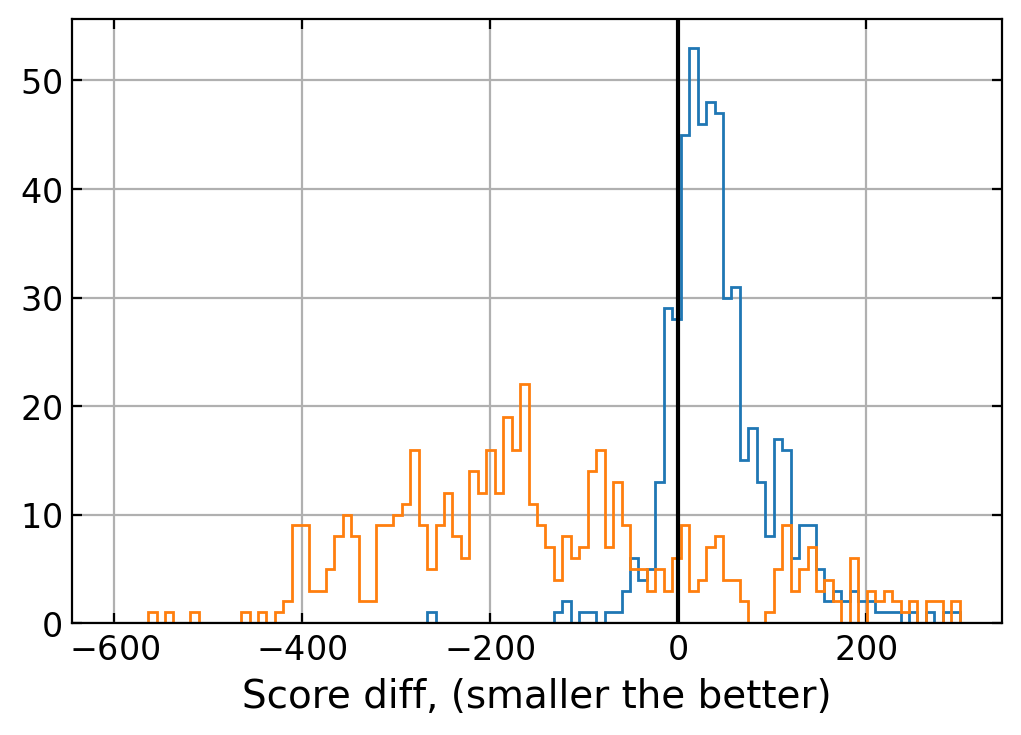

In [ ]:
score_old = dist_12-dist_non12
score_new = score_old - (total_layers_12-total_layers_non12)*100
hist(score_old,range=(-600,300),histtype="step")
hist(score_new,range=(-600,300),histtype="step");
grid()
axvline(0,color="k")
xlabel("Score diff, (smaller the better)")

sum(score_new<0)/len(score_new), sum(score_new>0)

### Plot some events

In [22]:
mask_plot = ((residual[:,4]>400)&(residual[:,4]<4000))
sum(mask_plot)

86

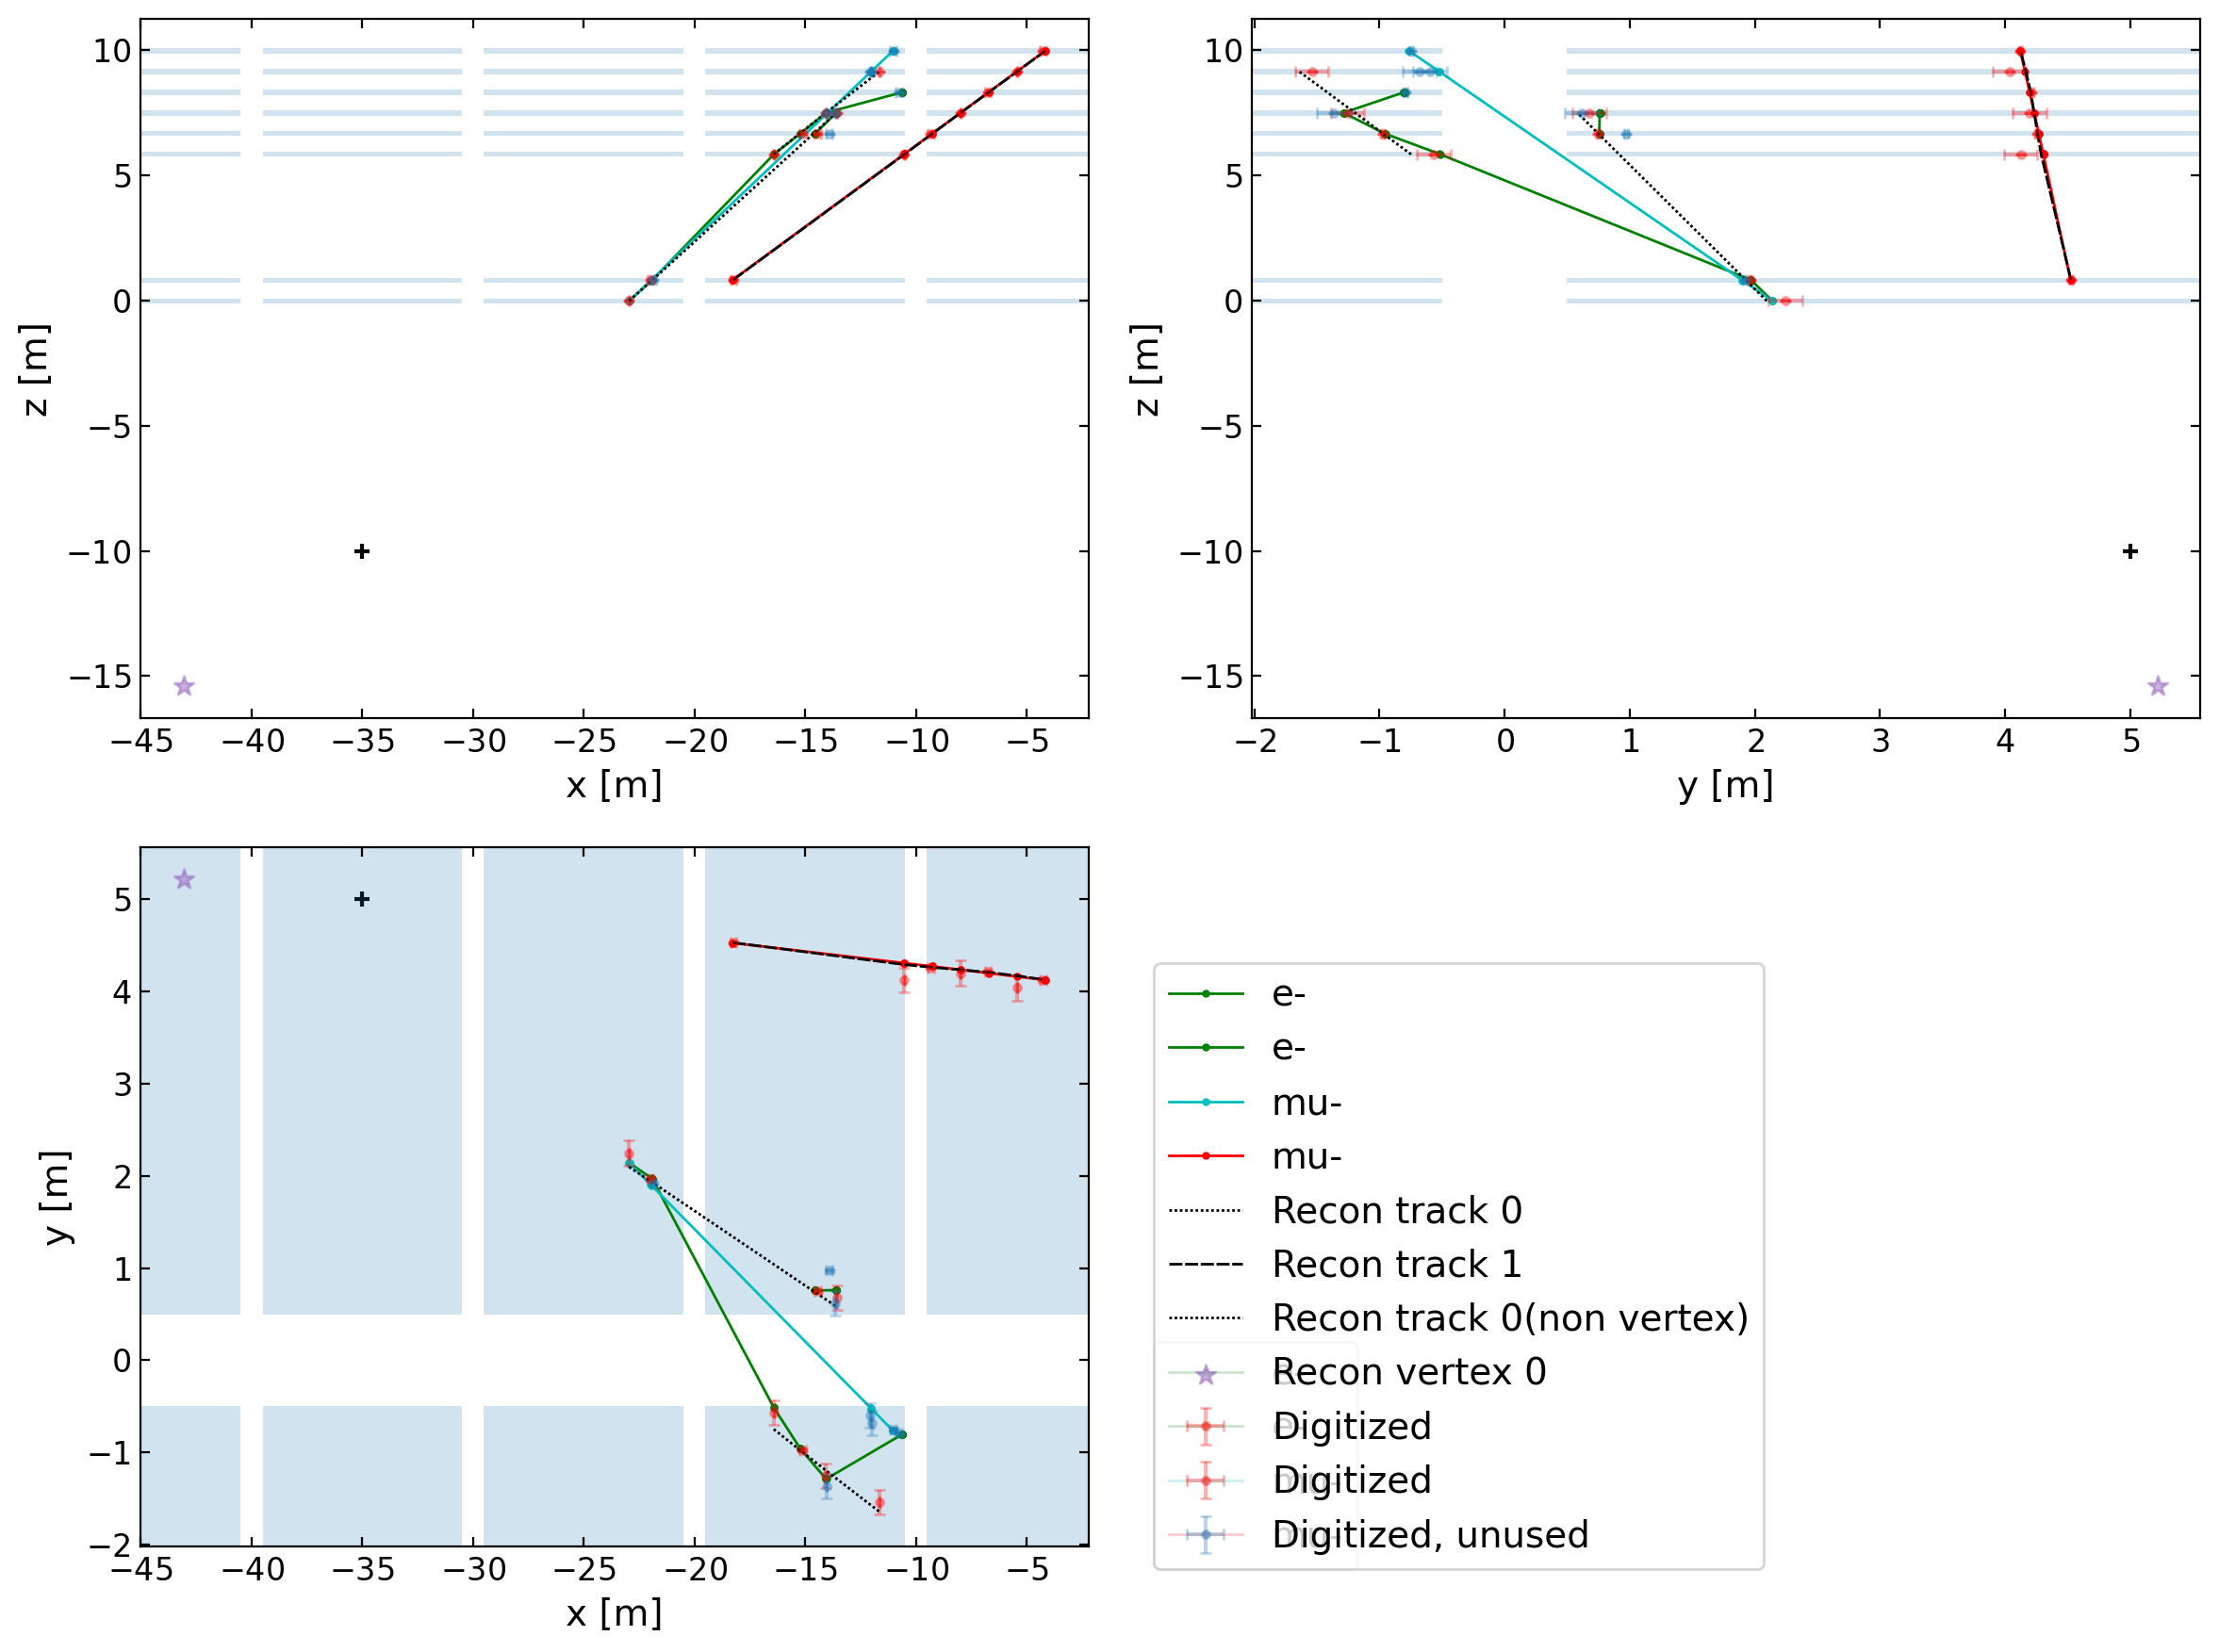

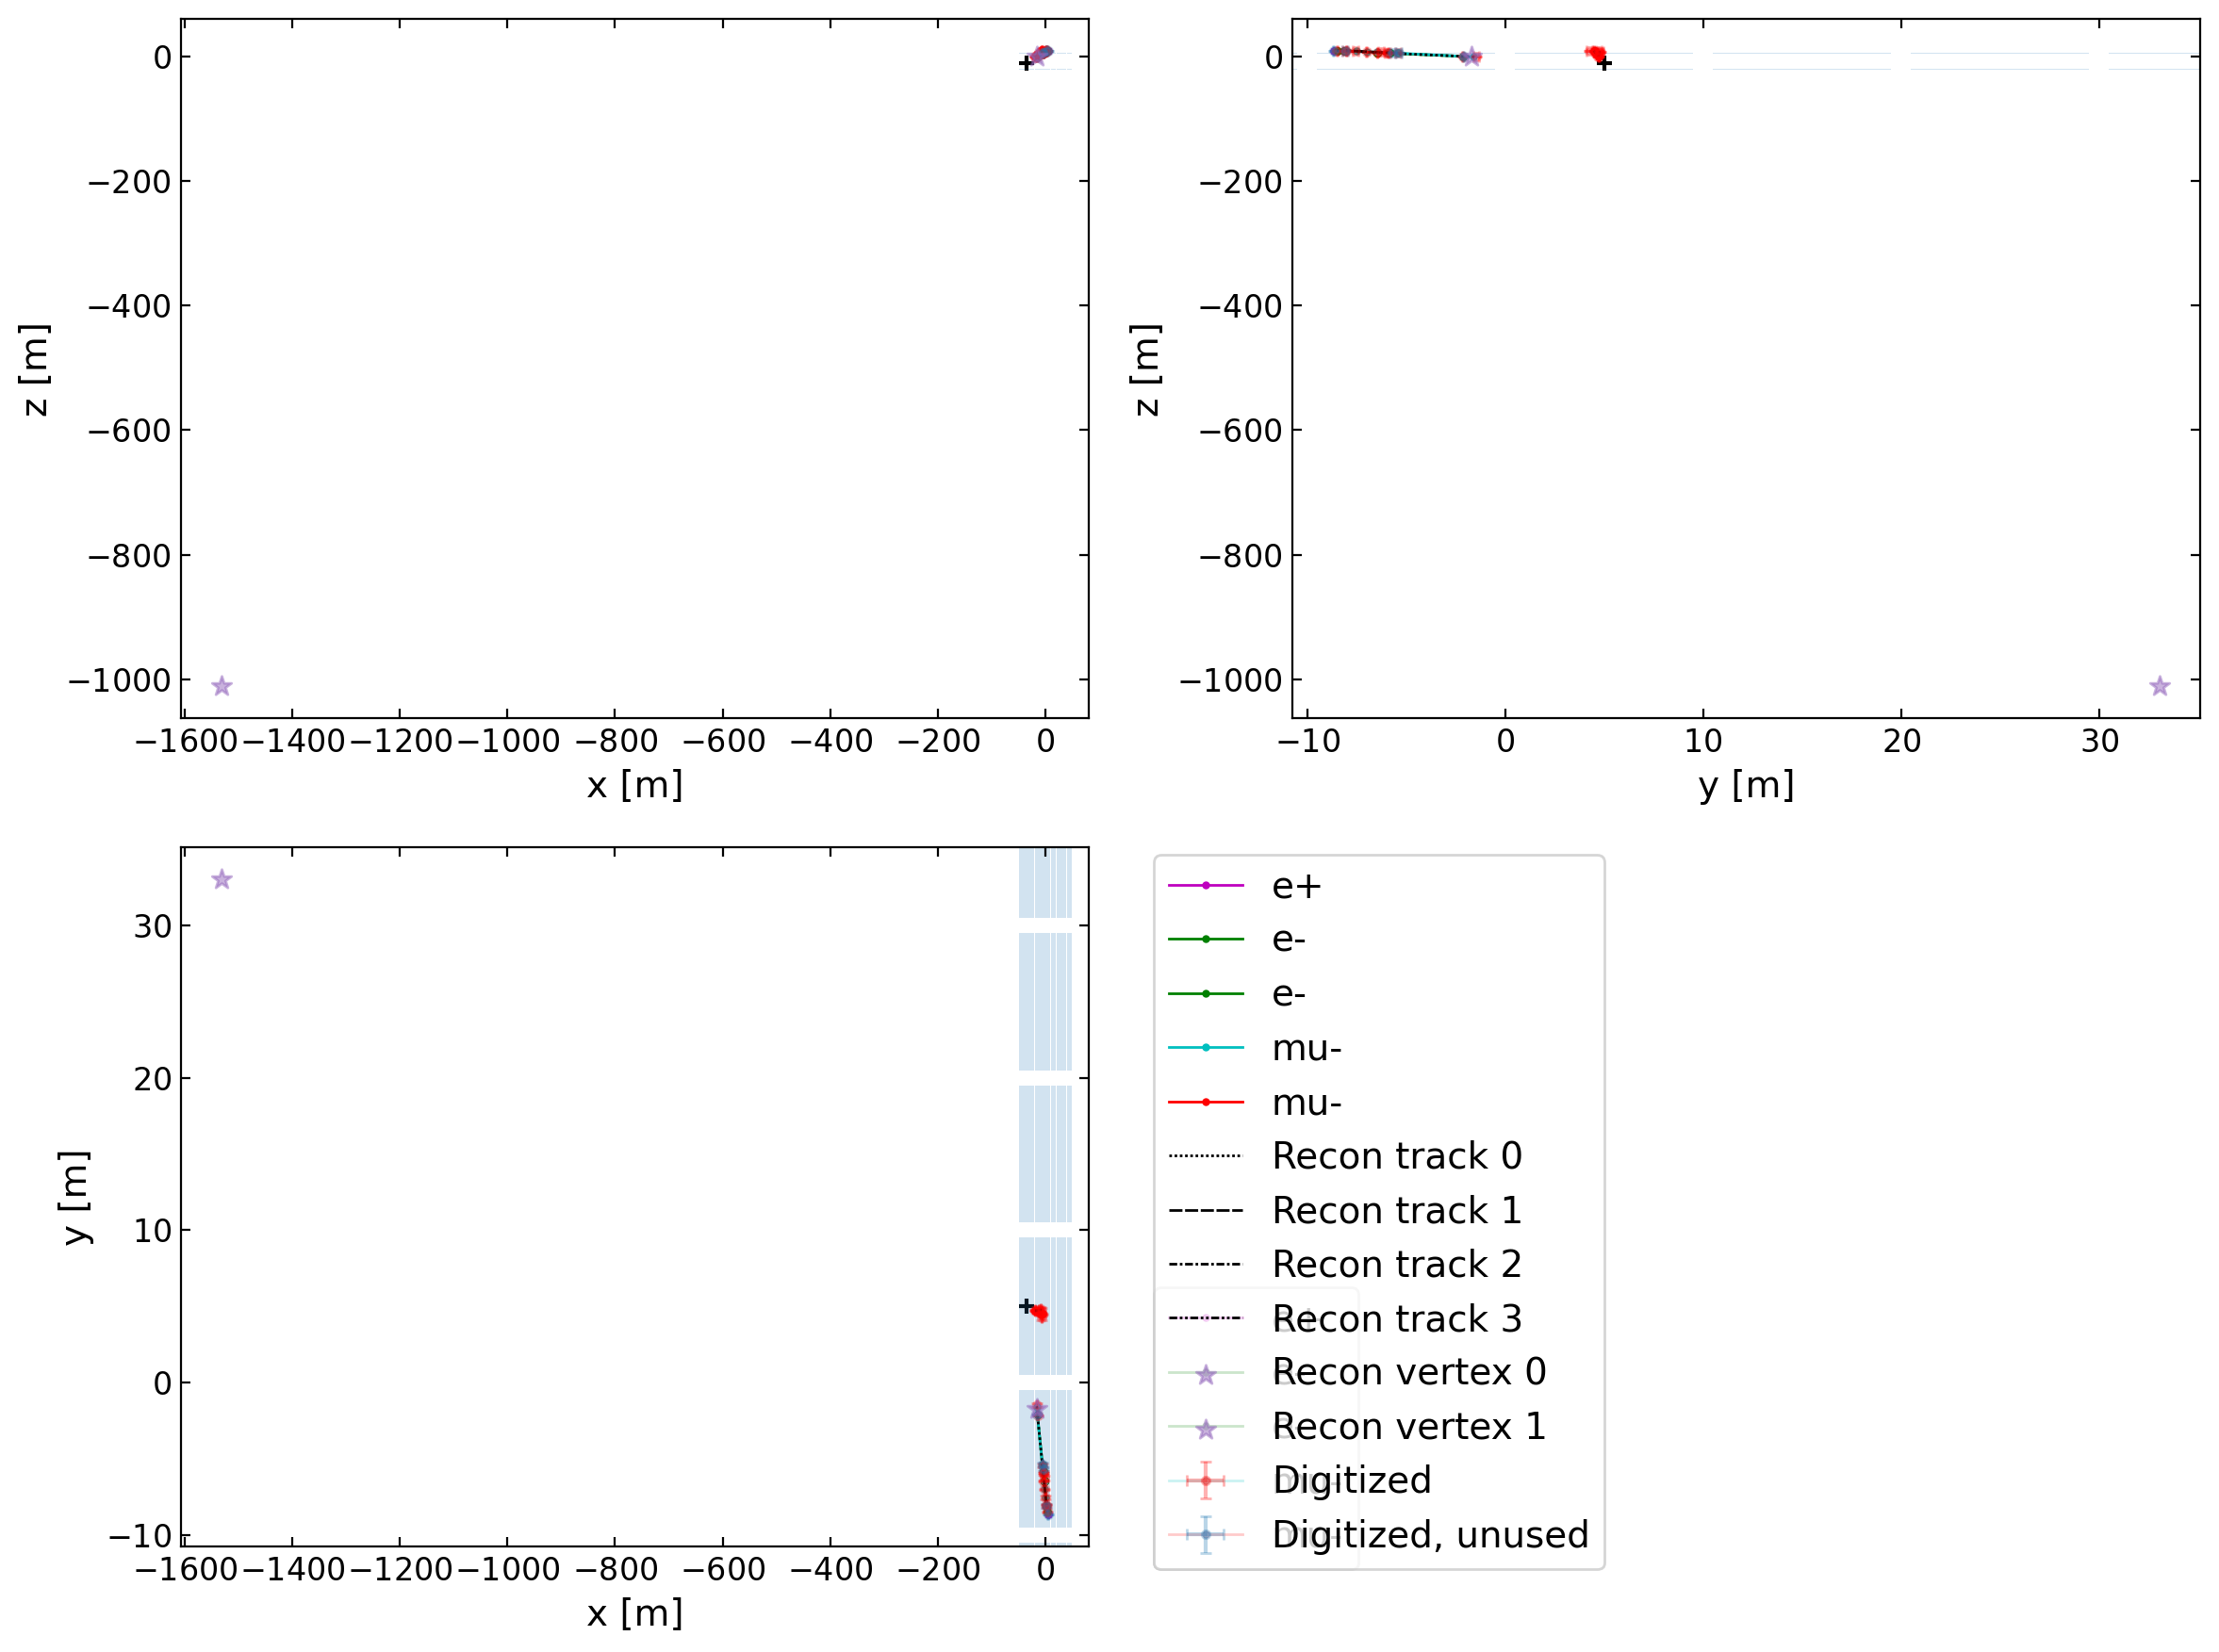

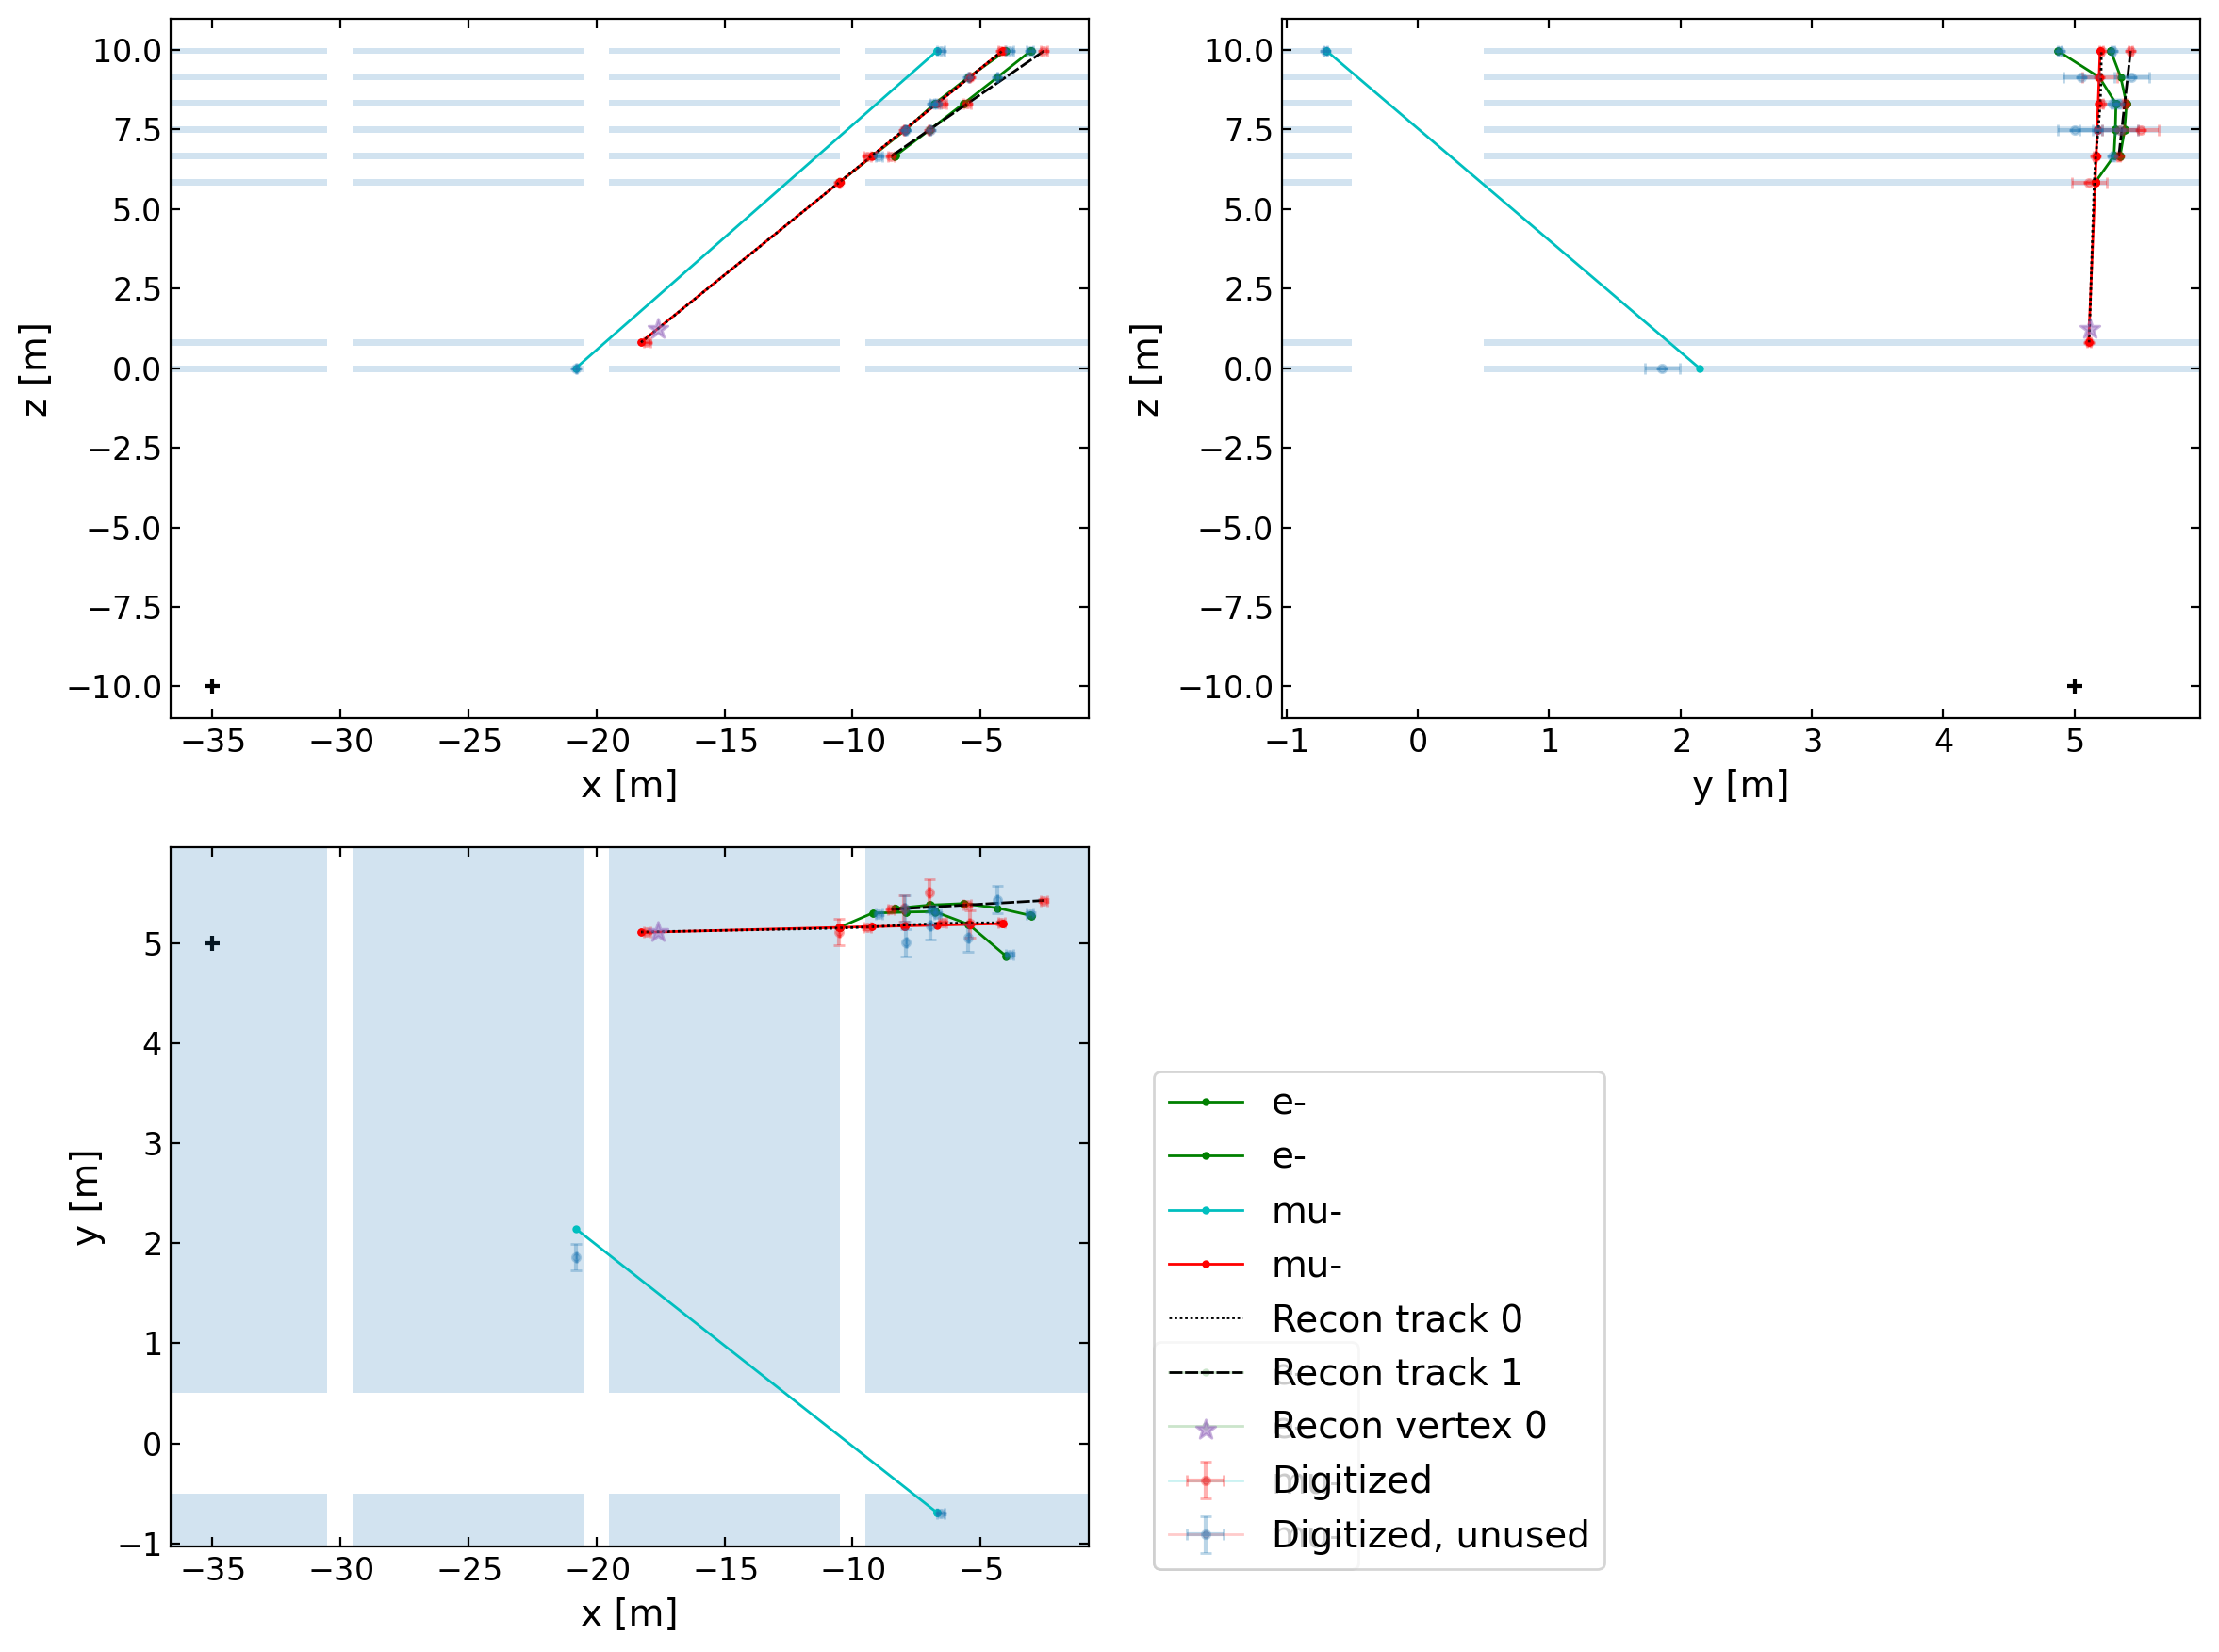

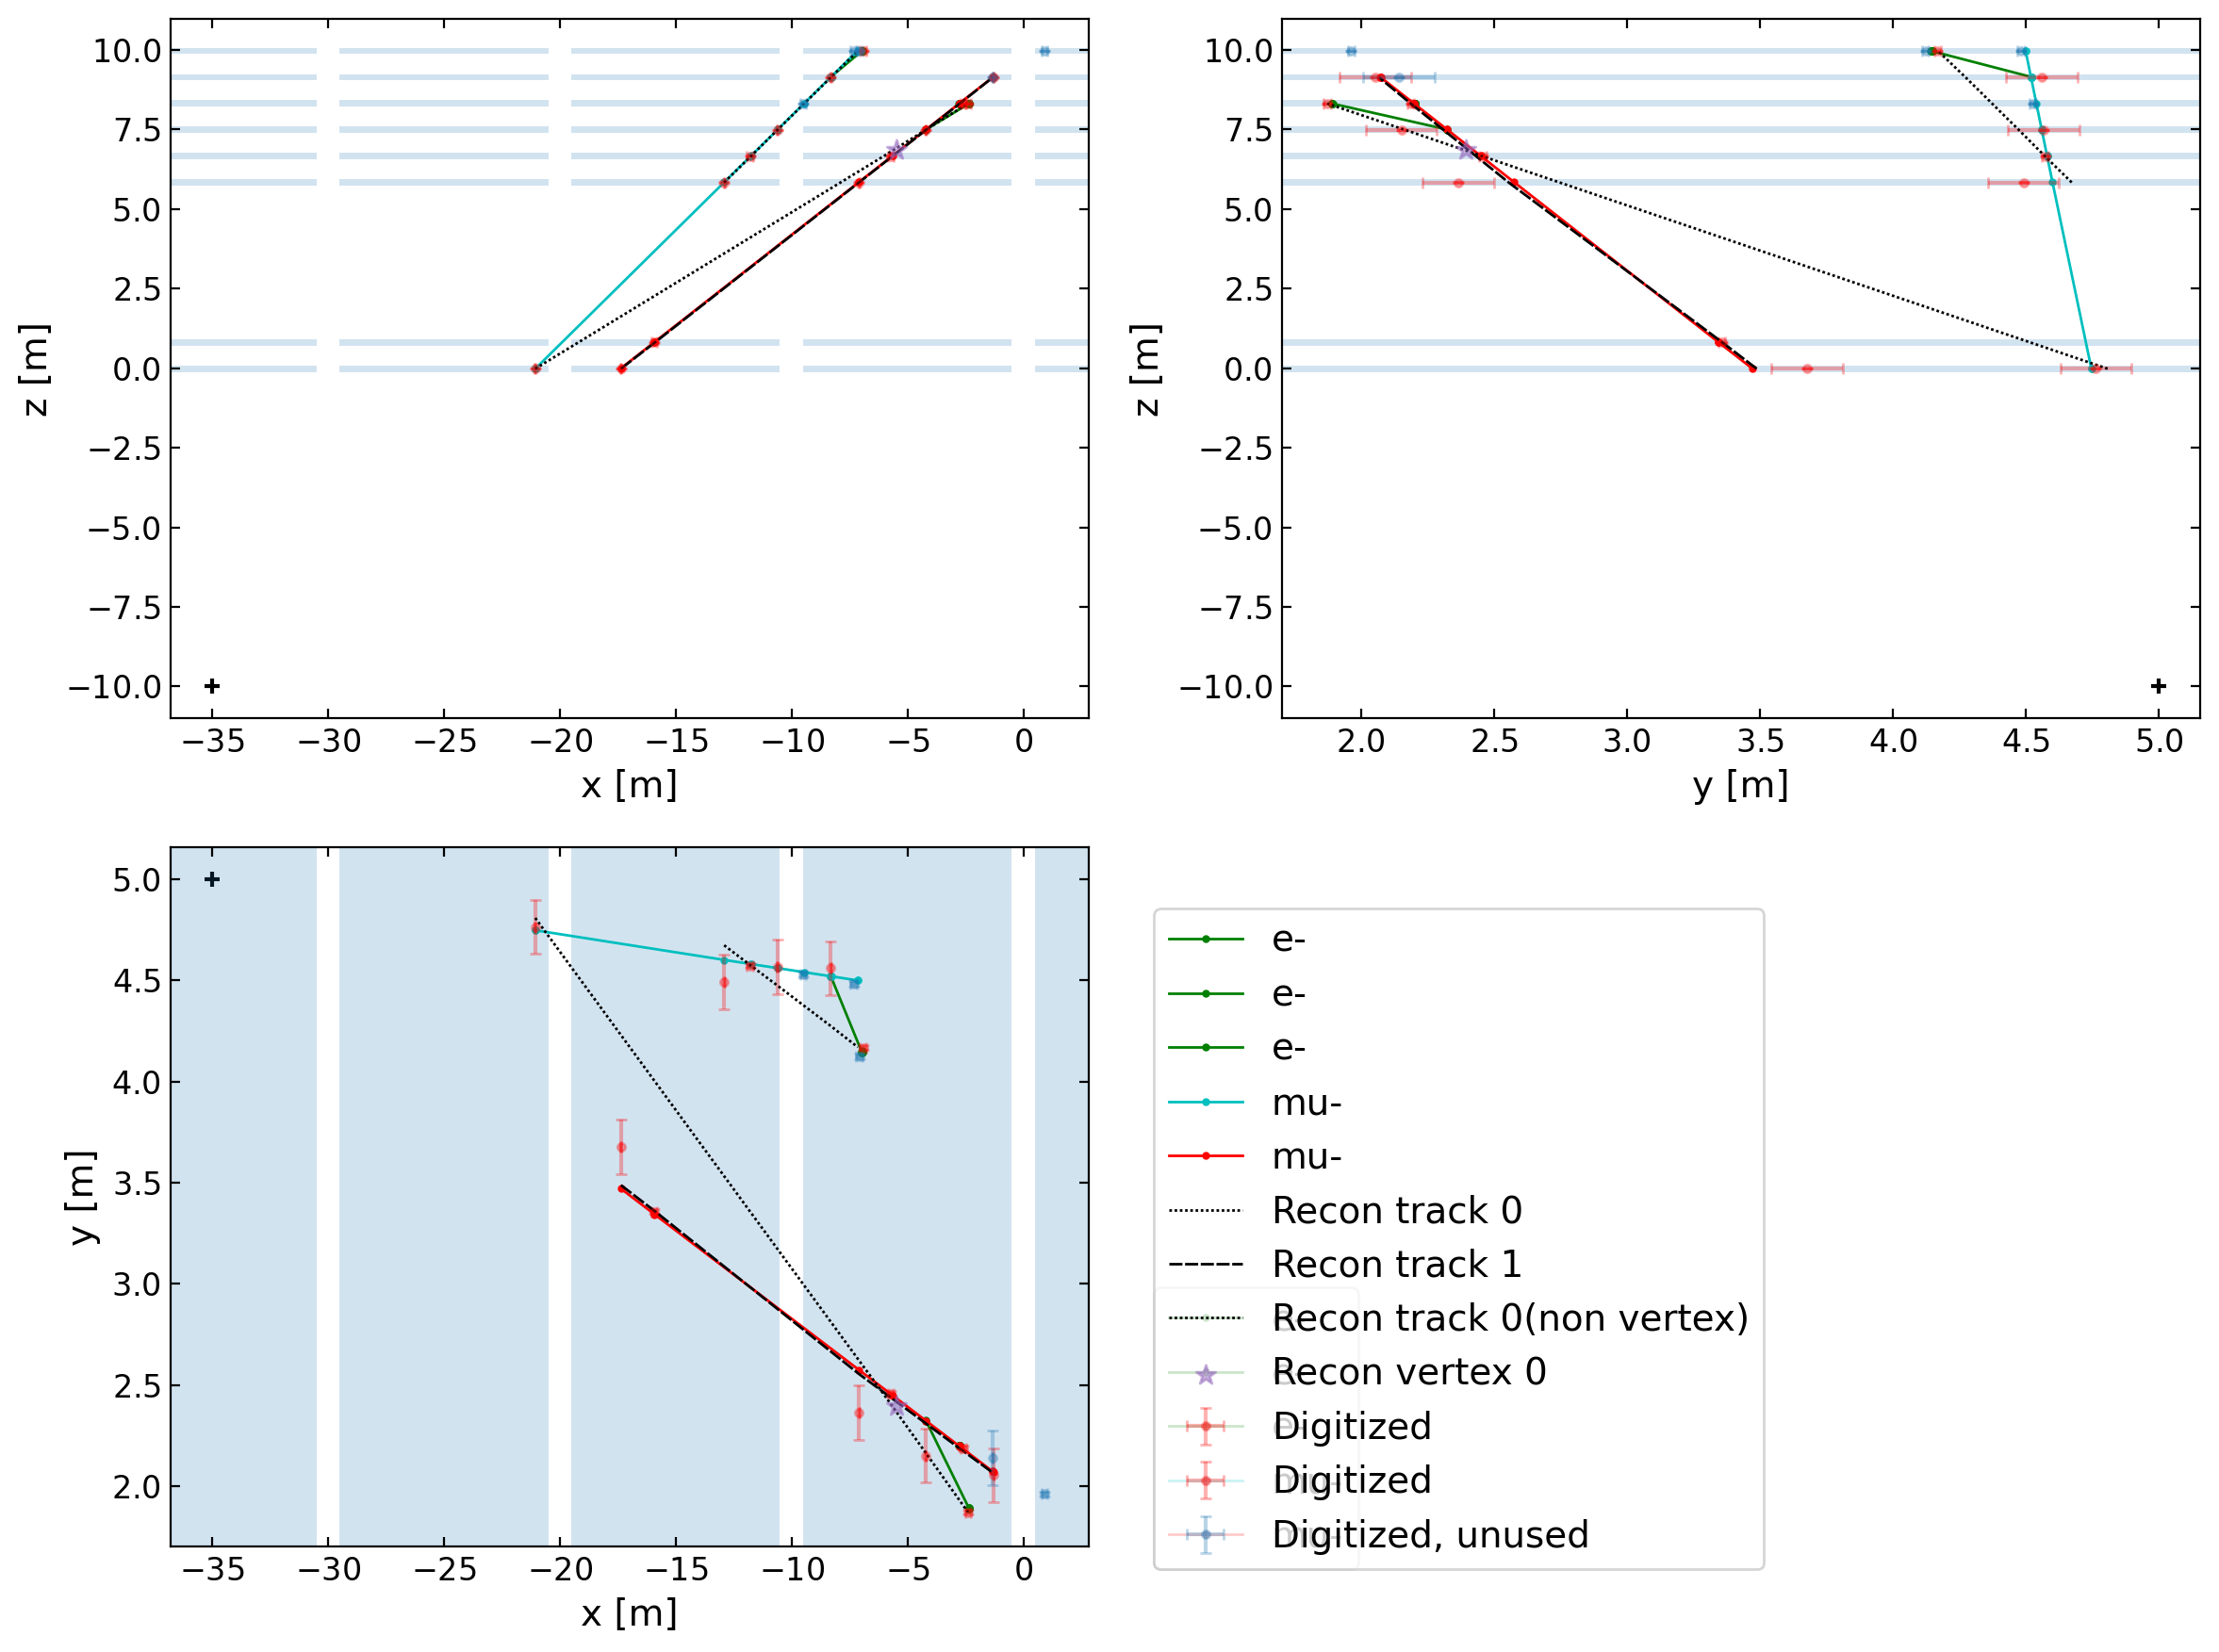

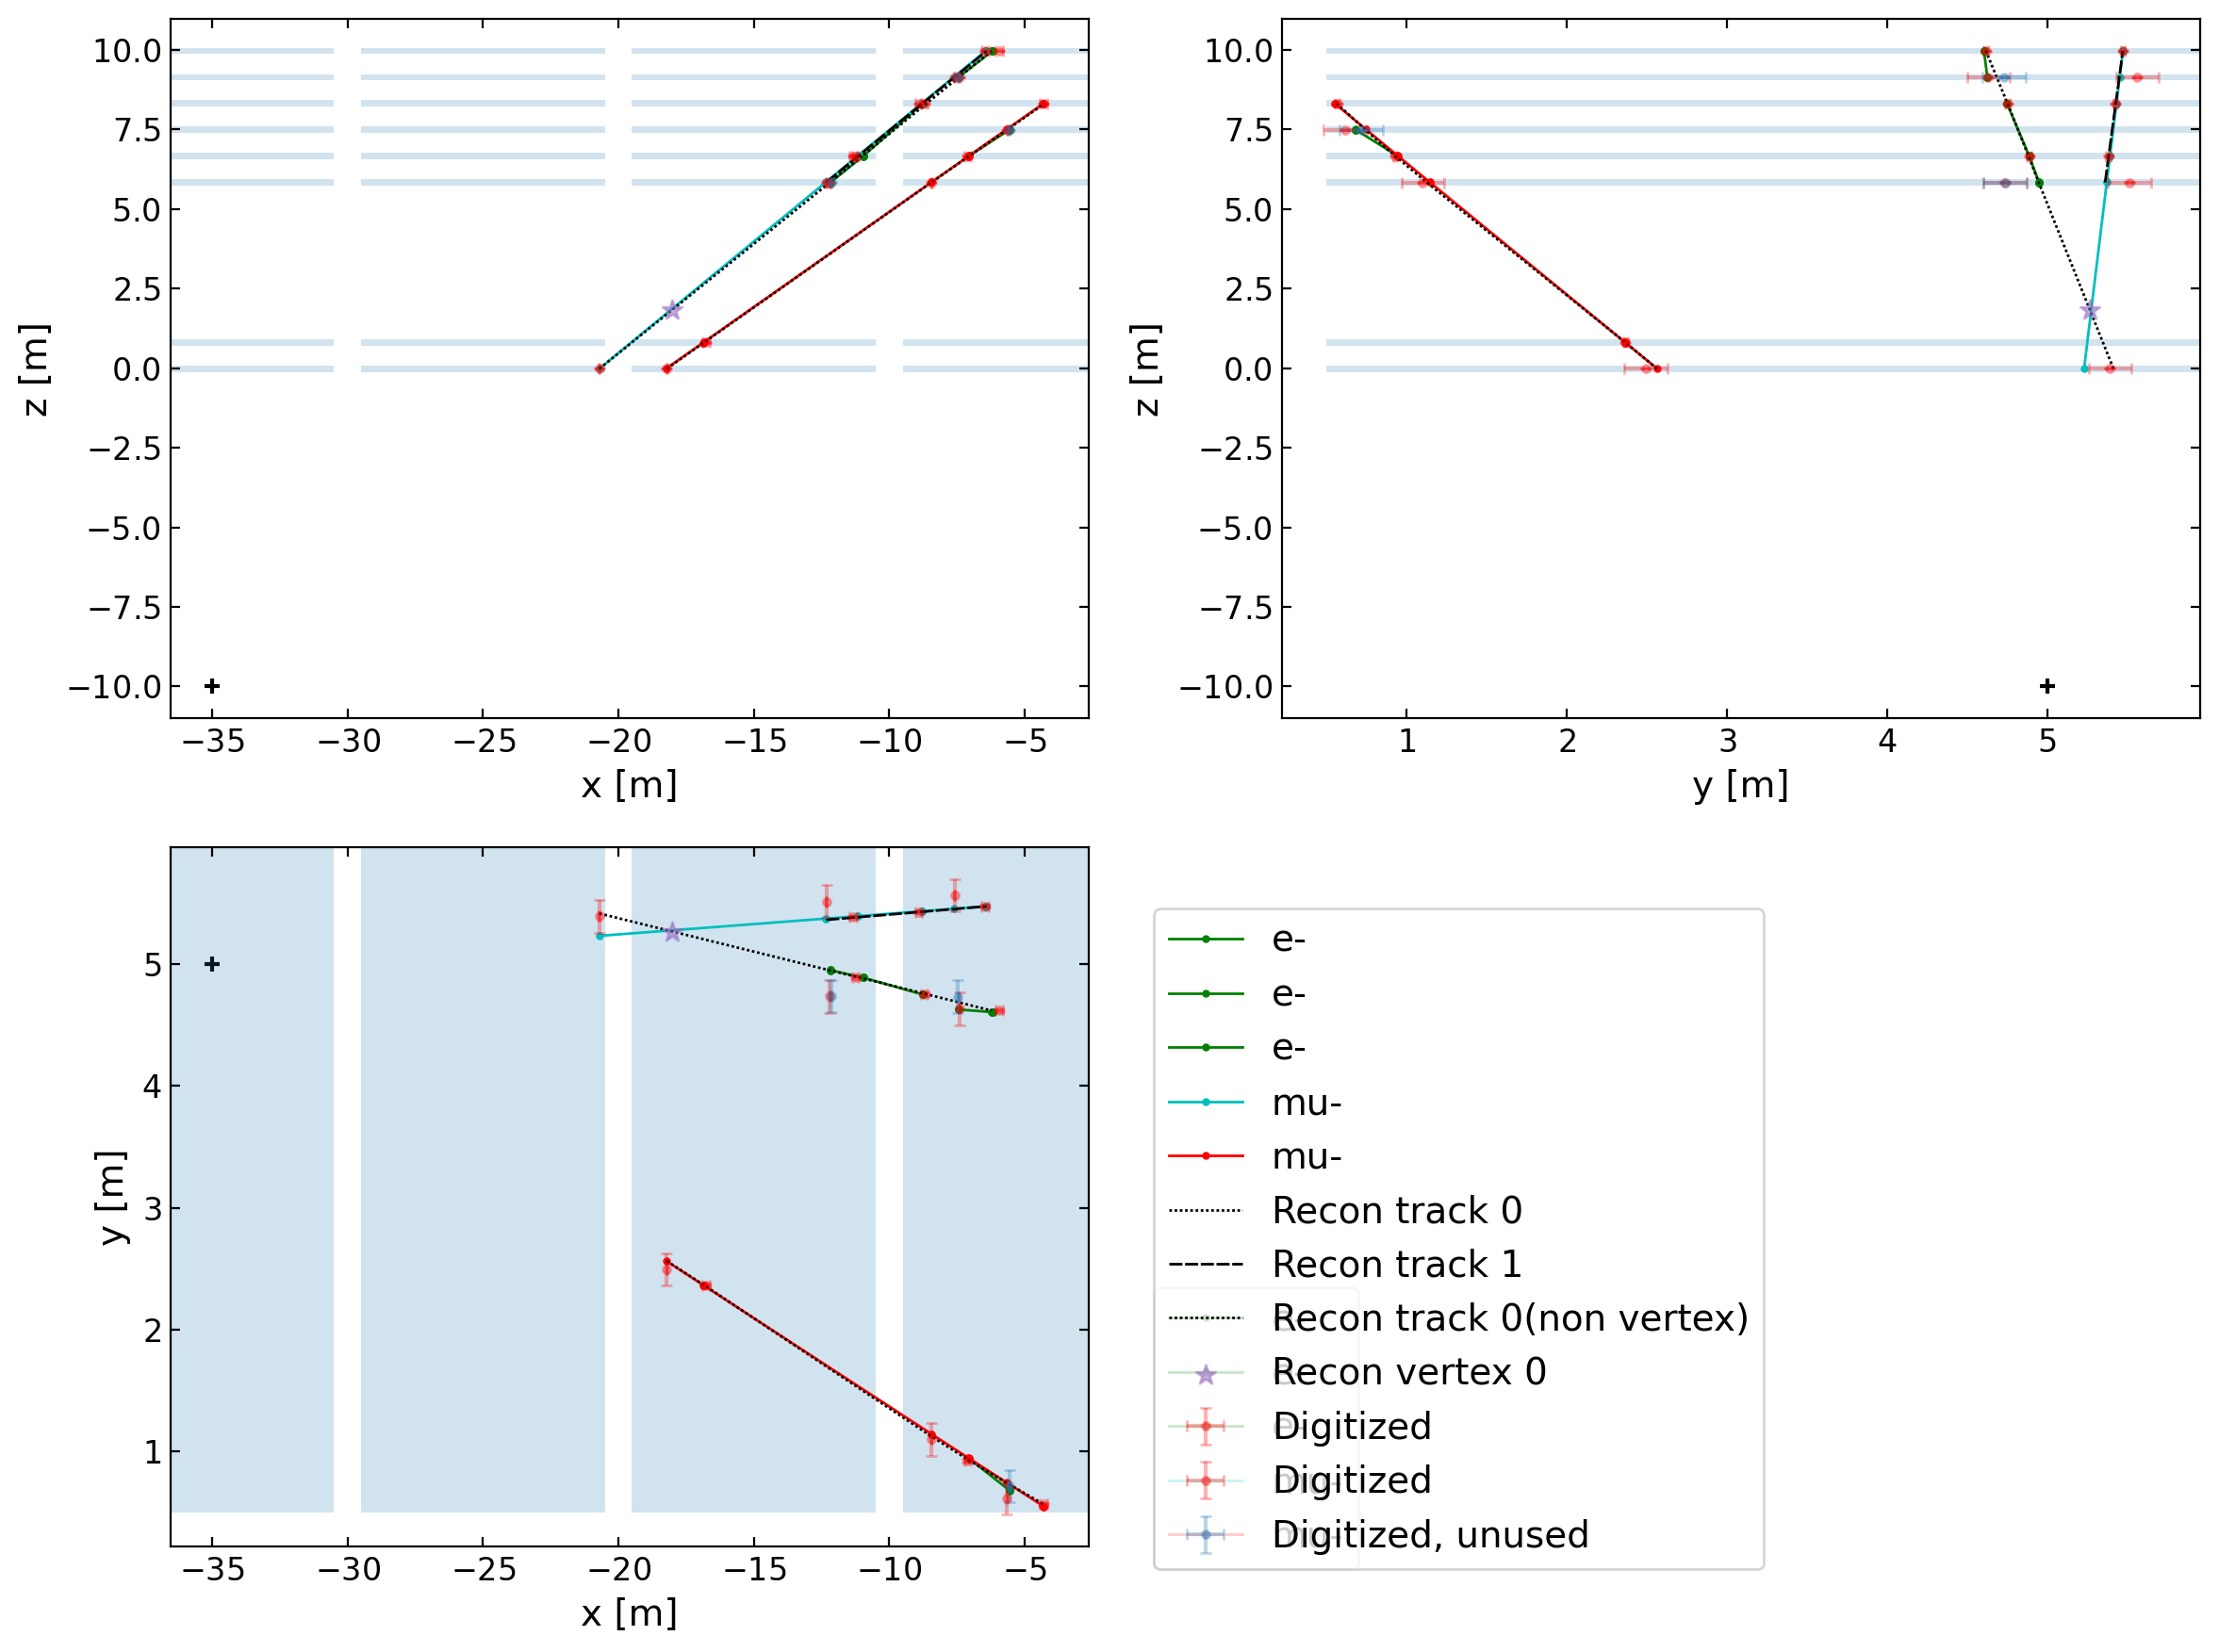

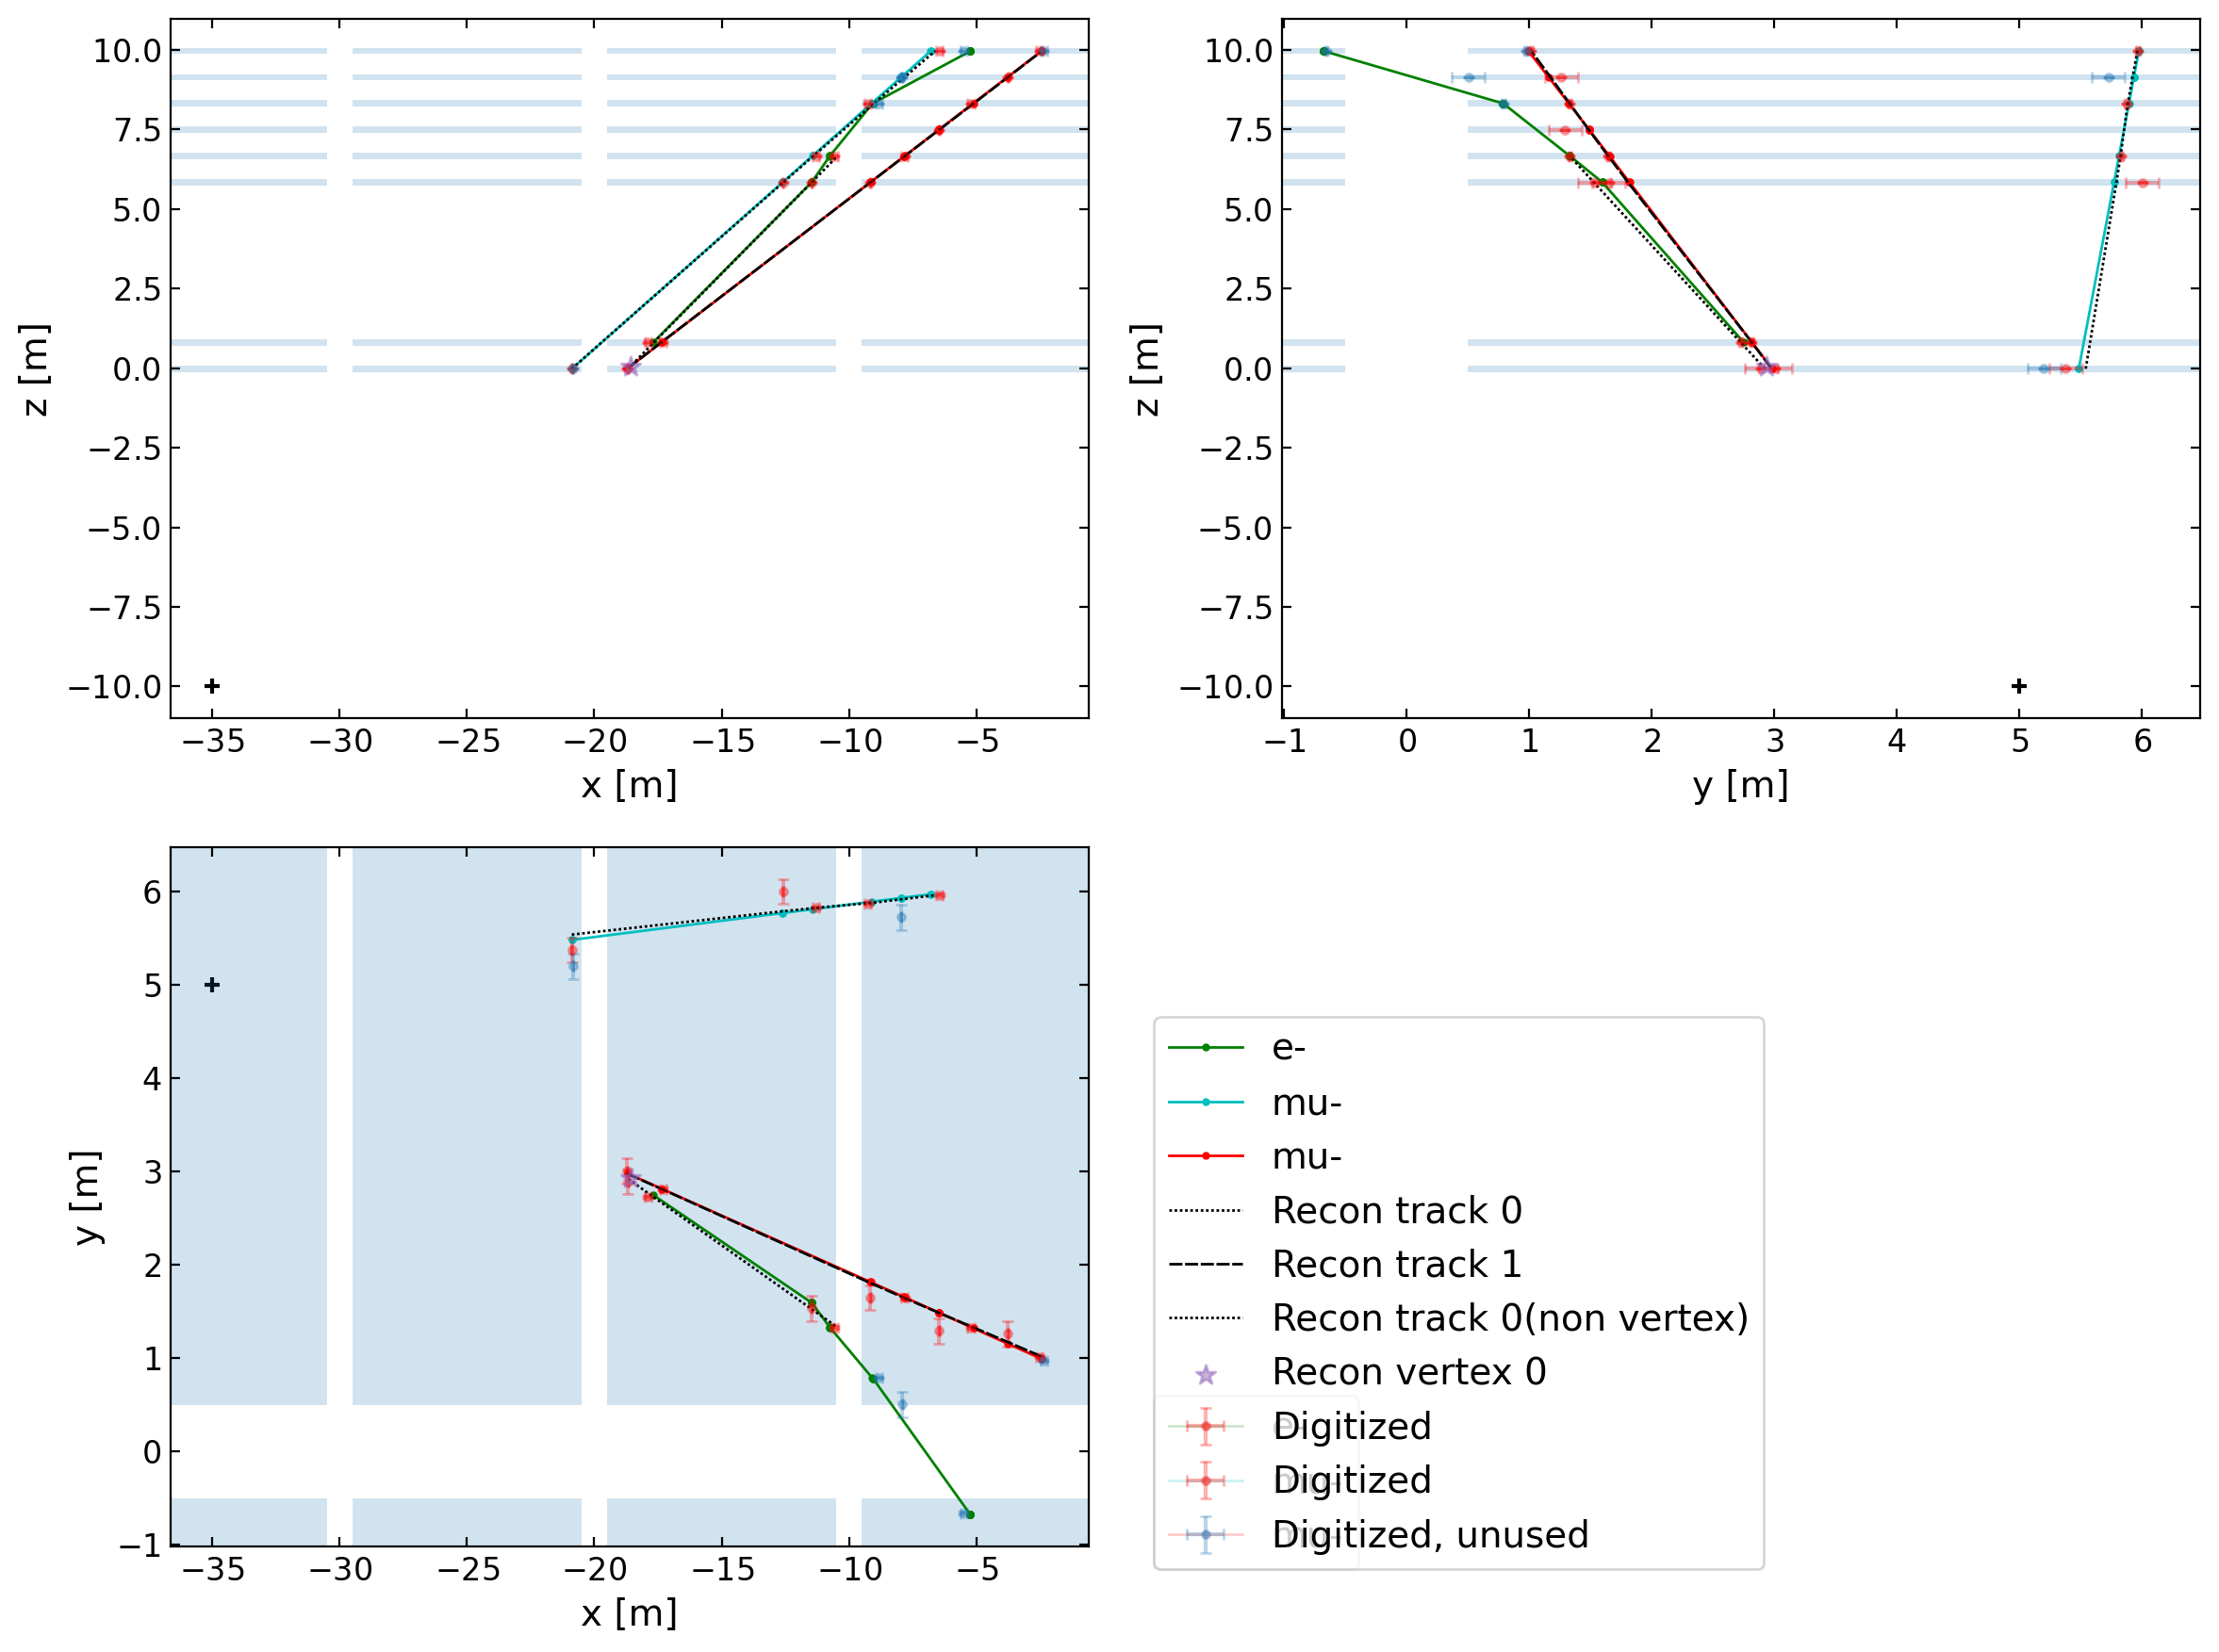

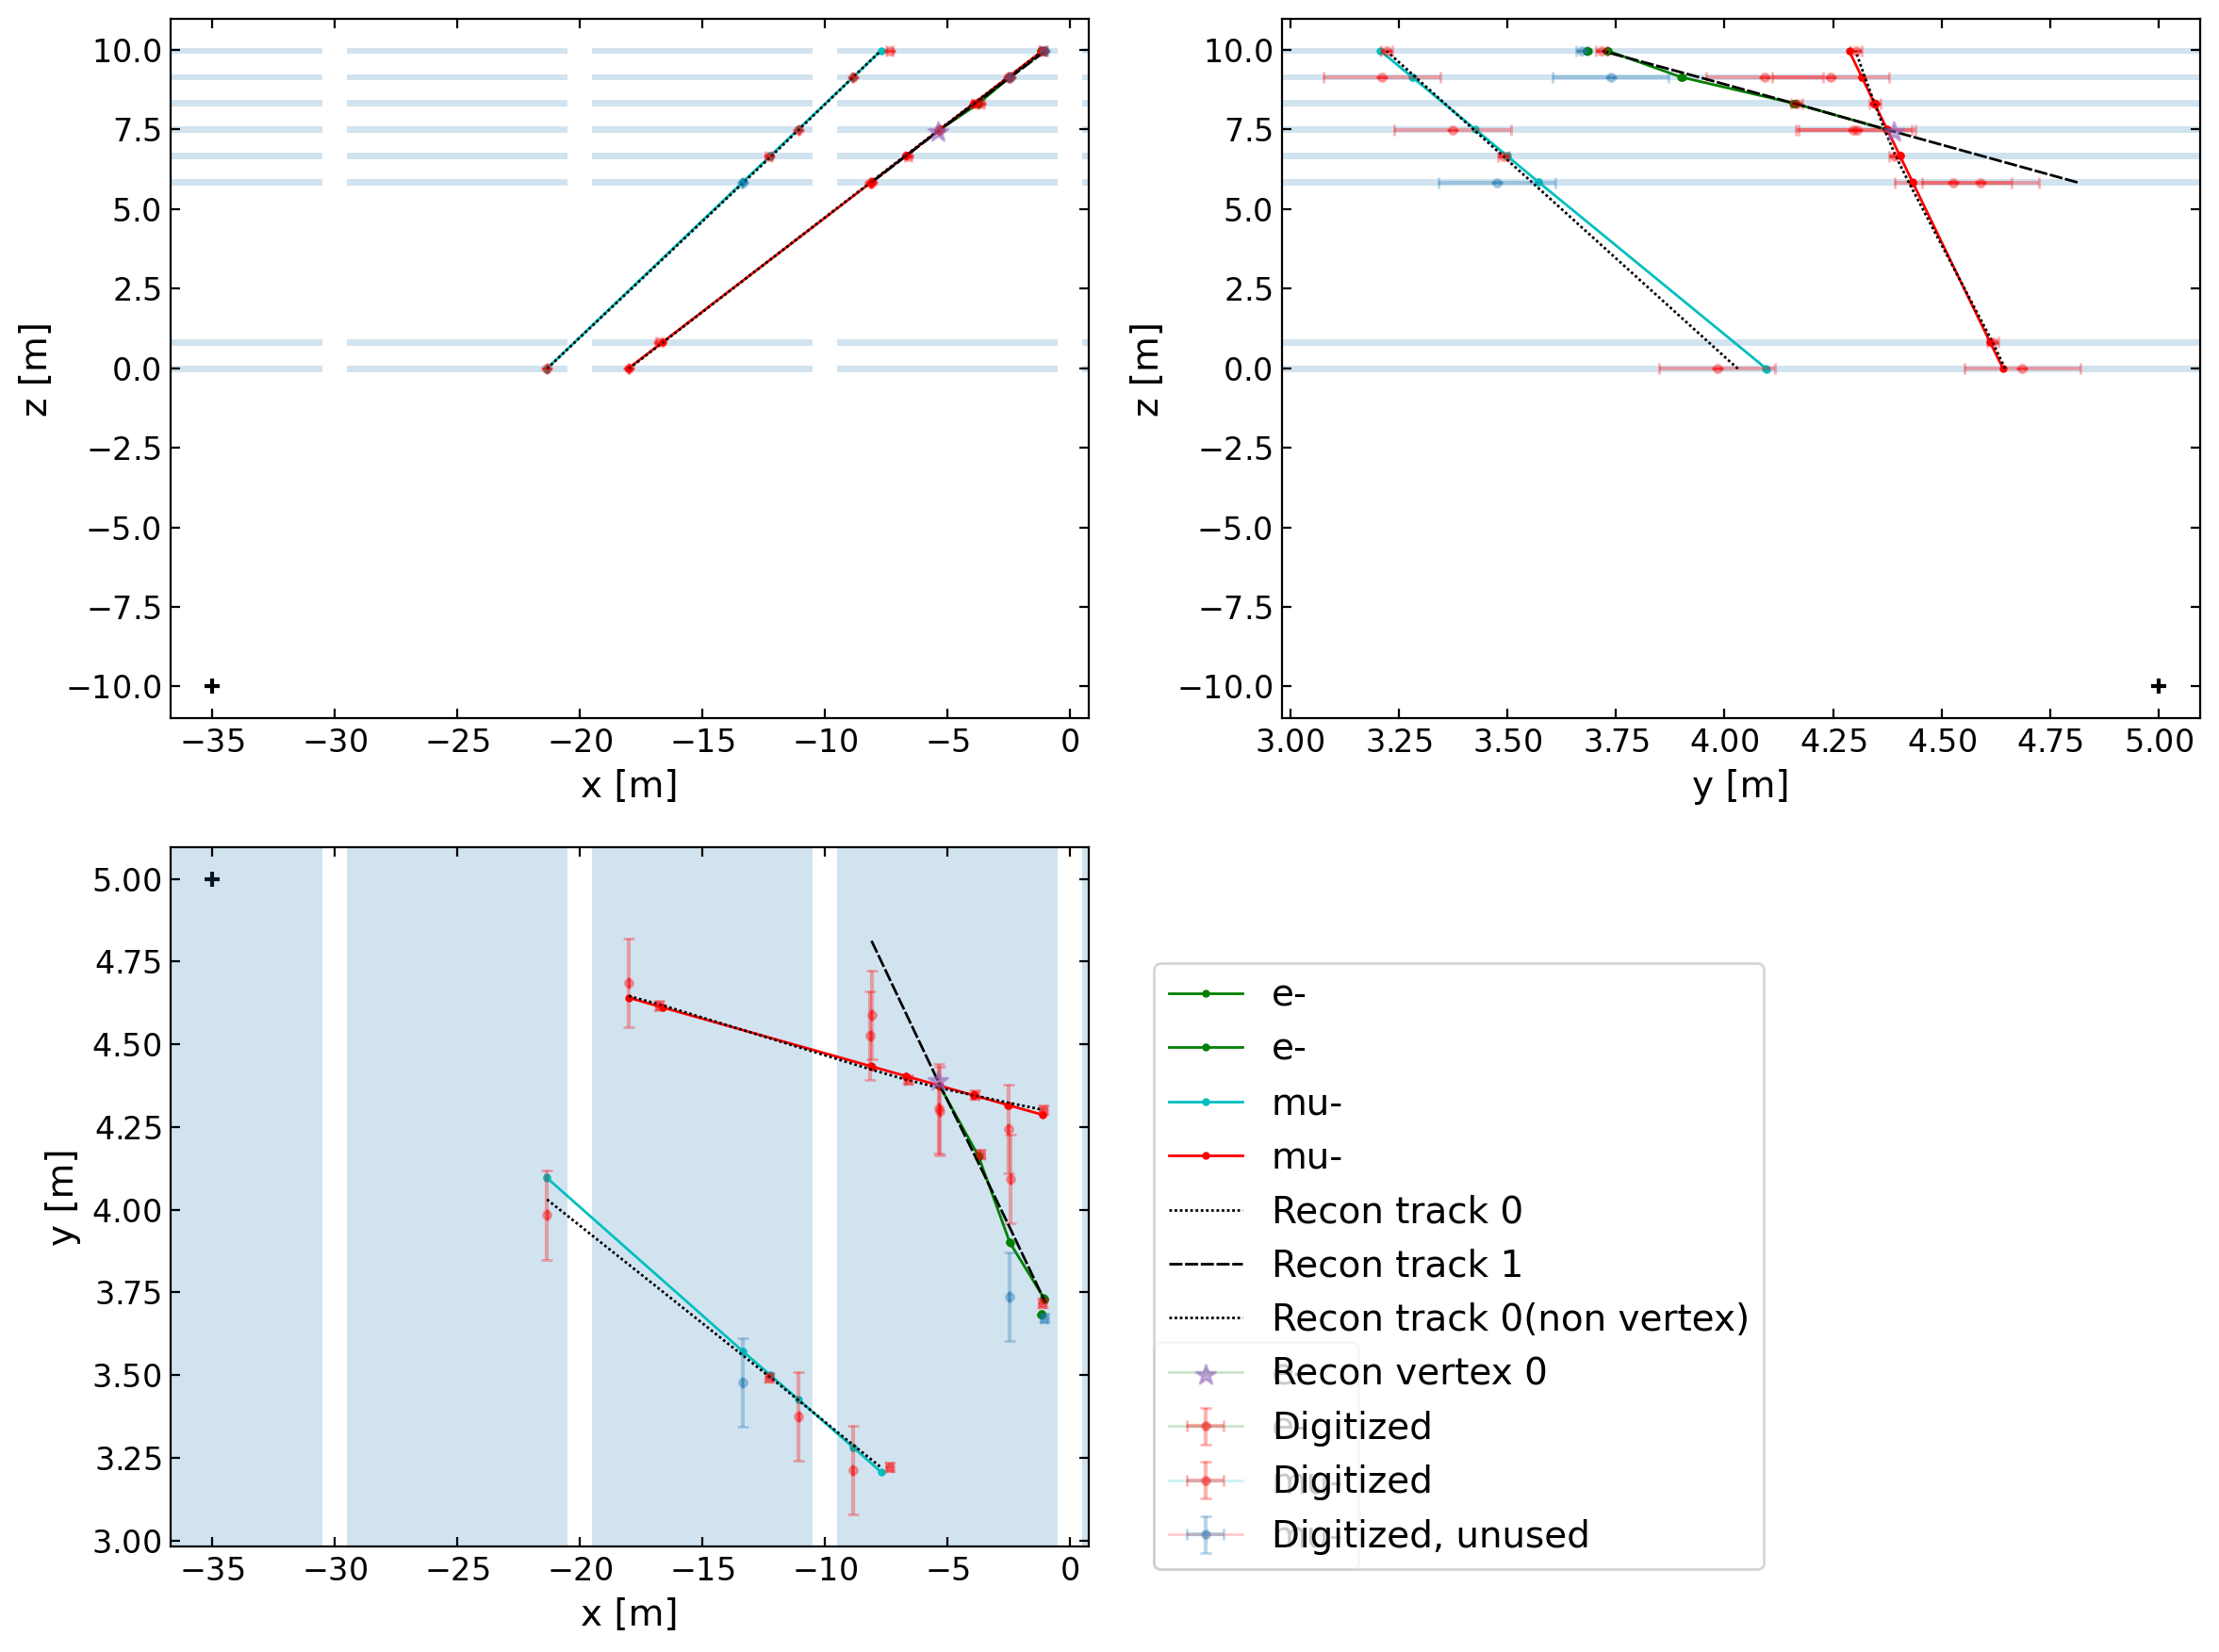

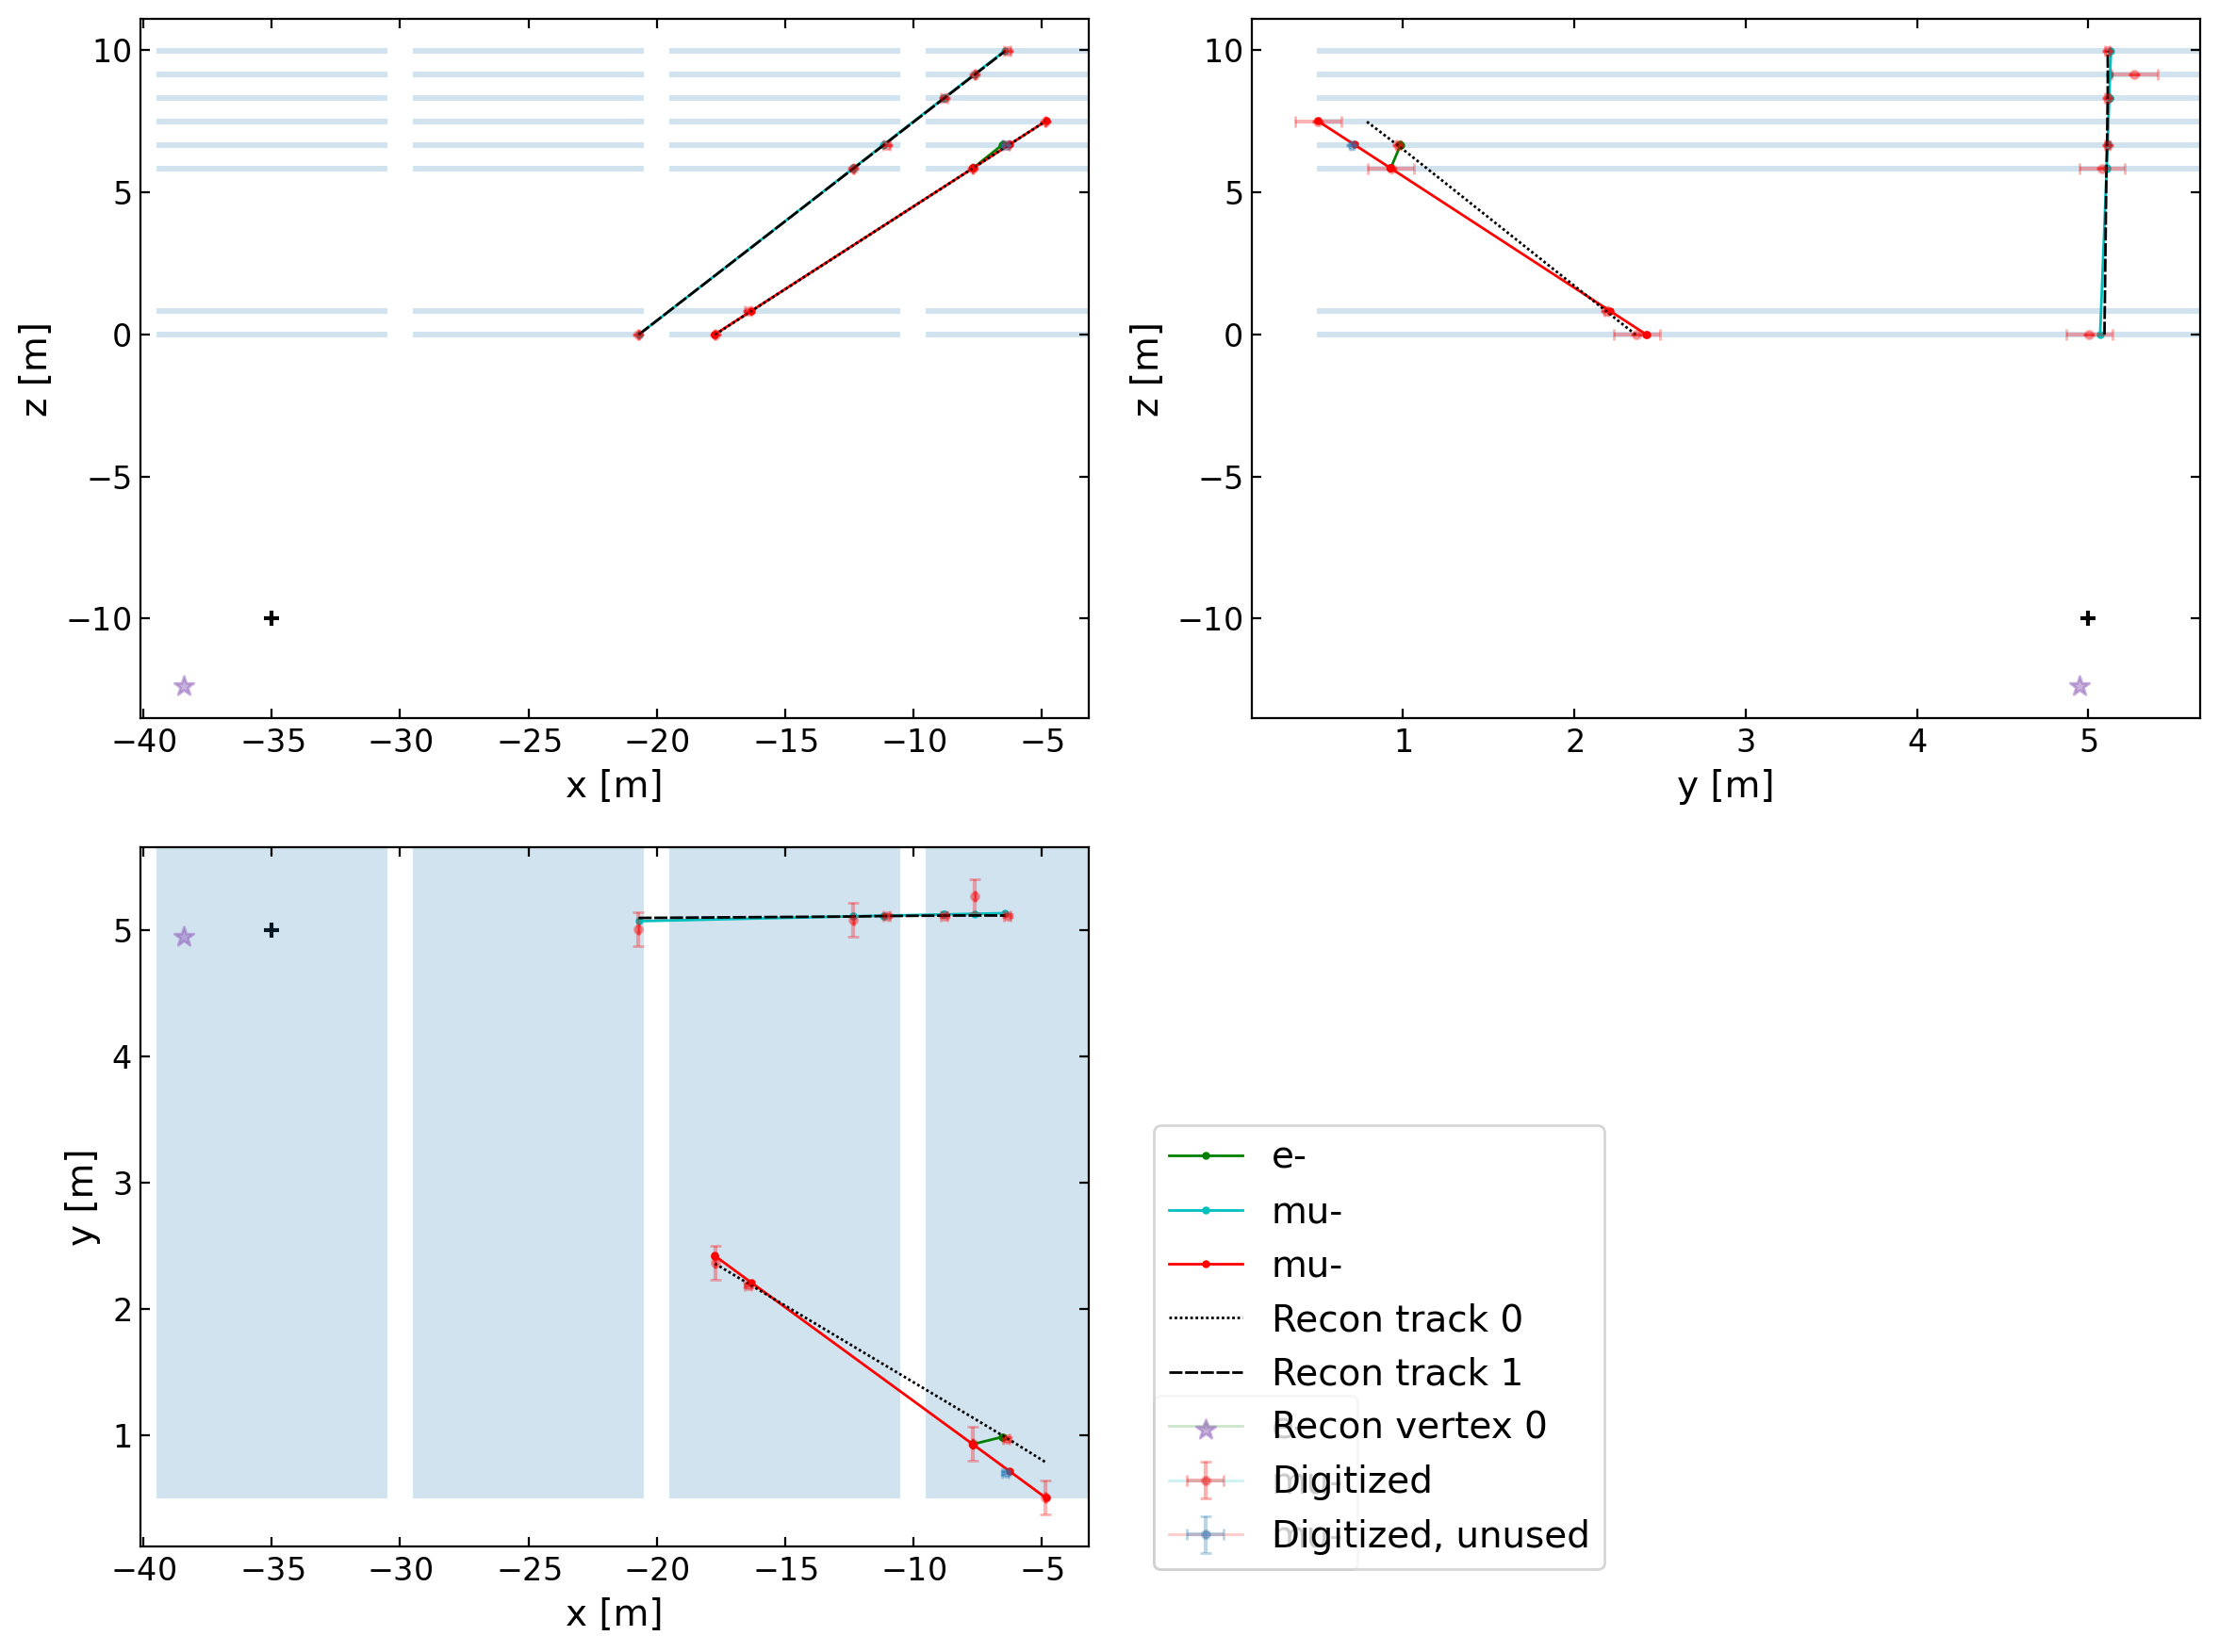

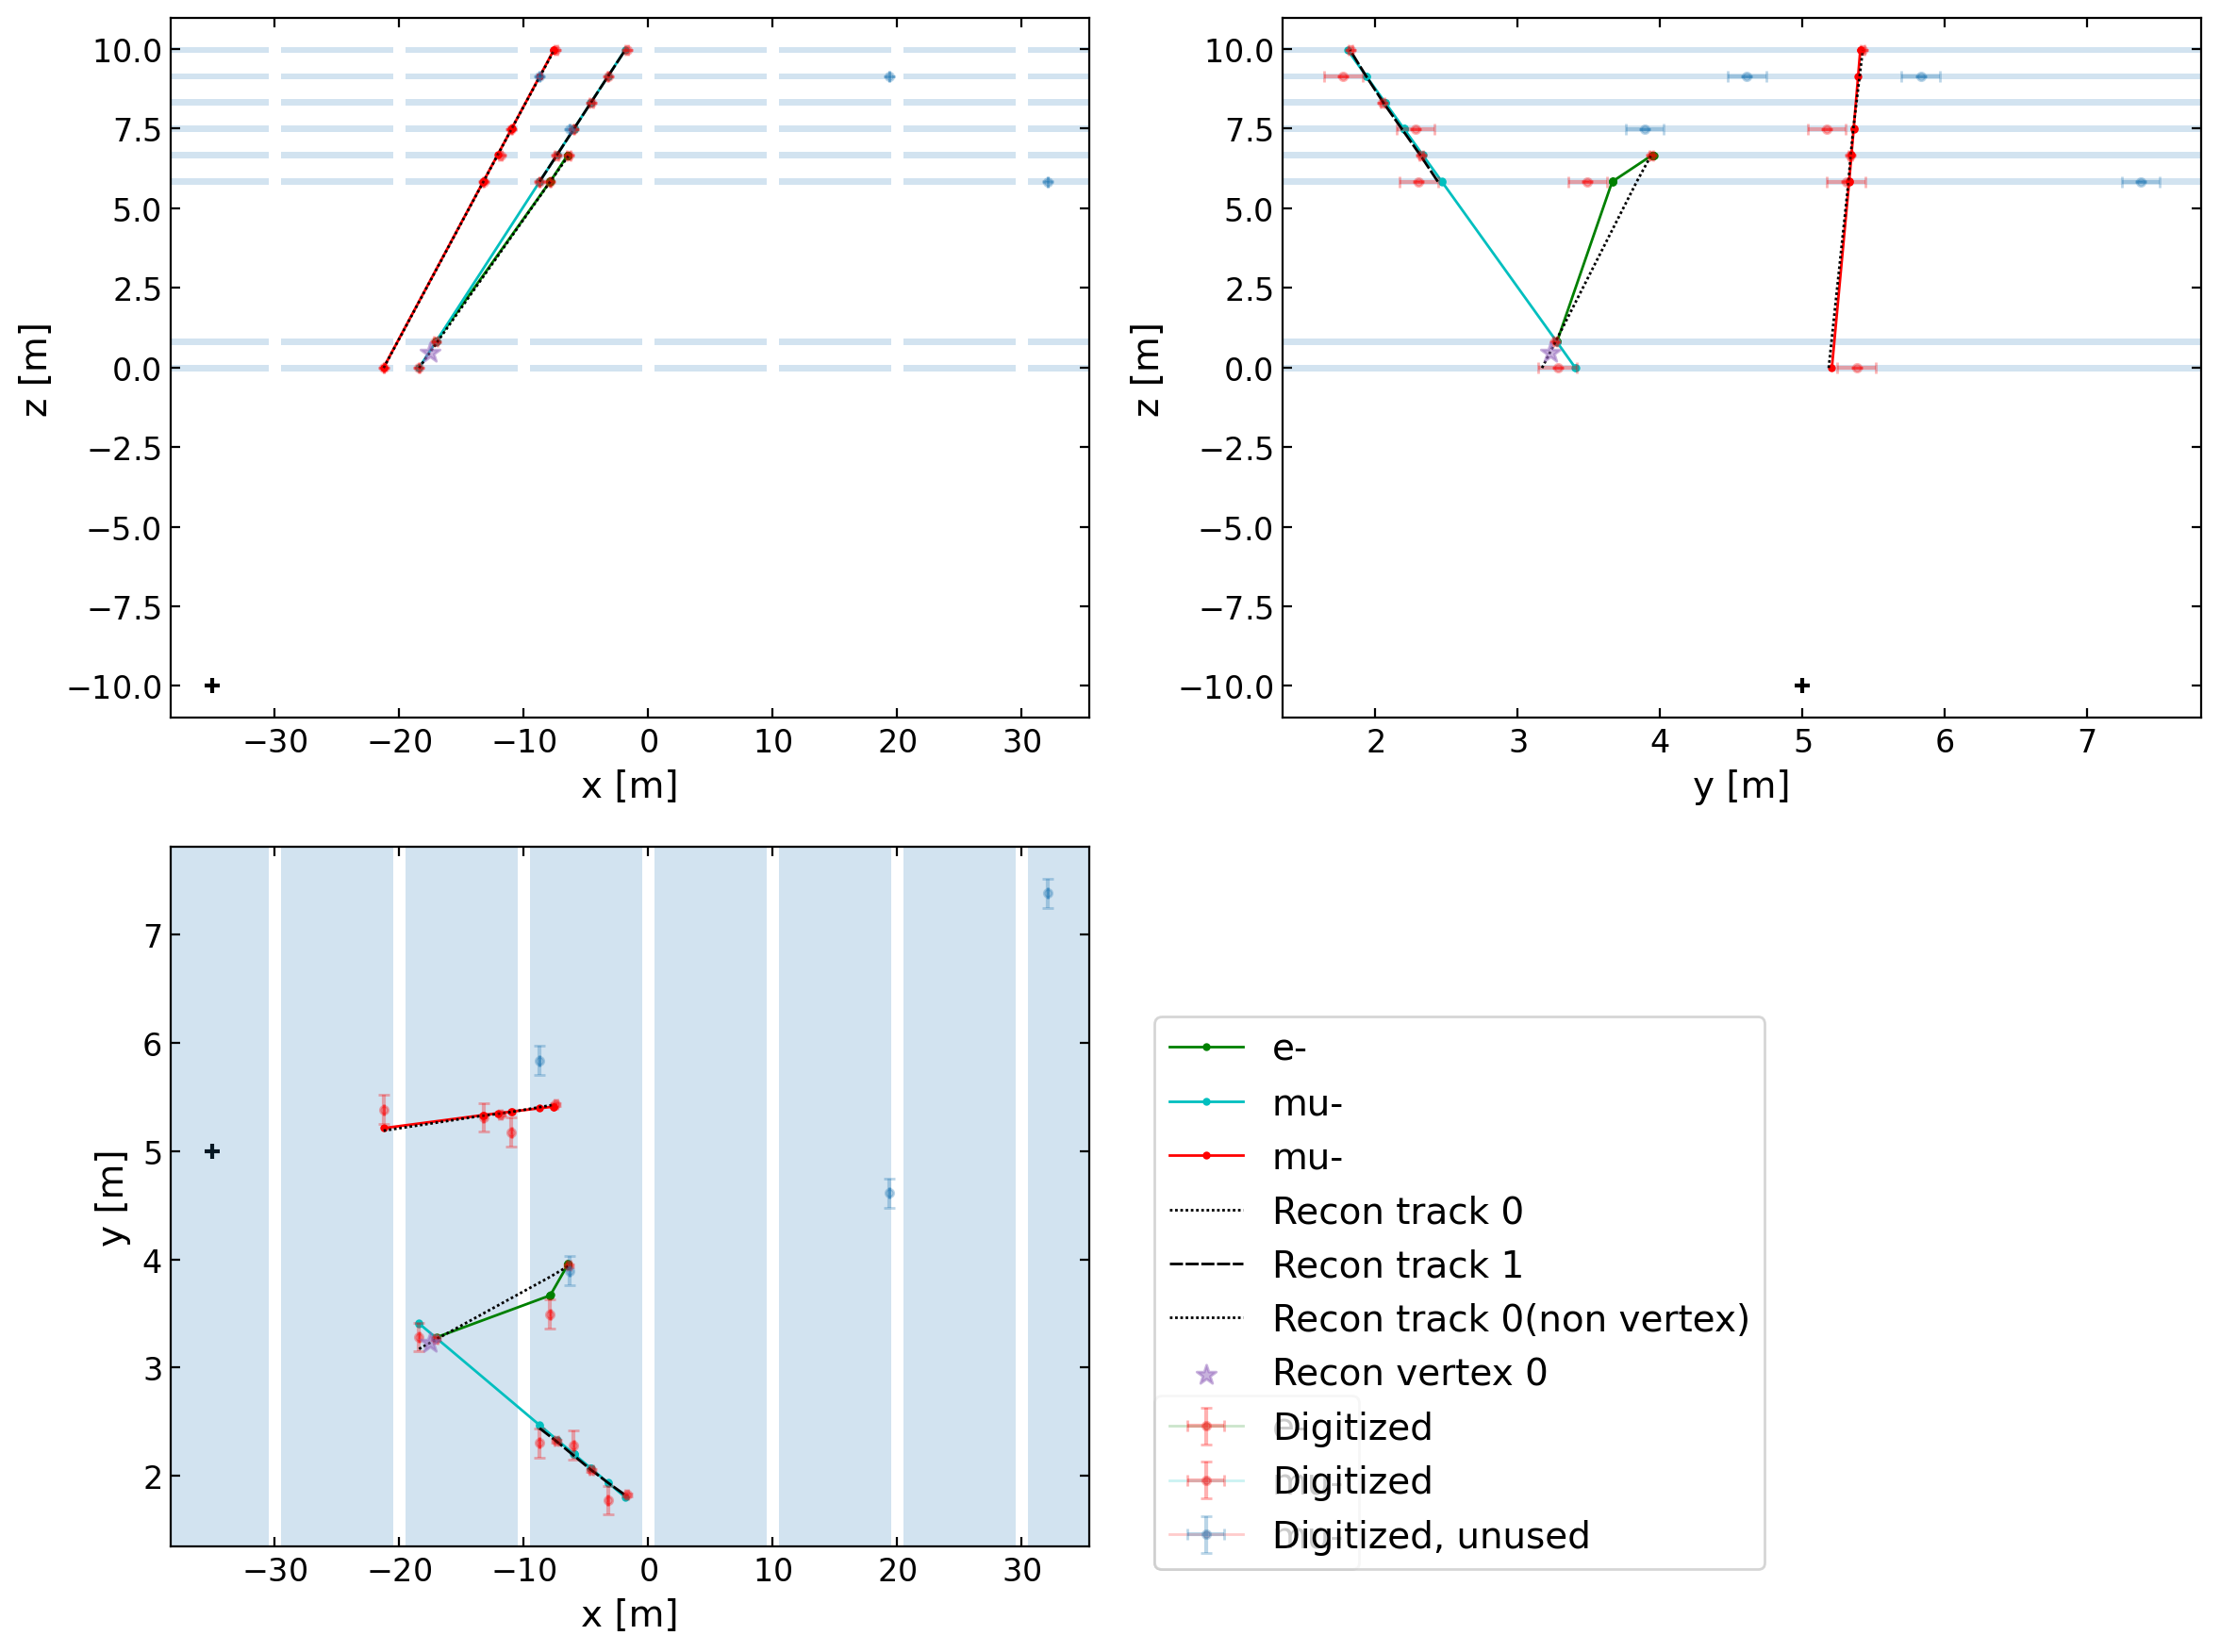

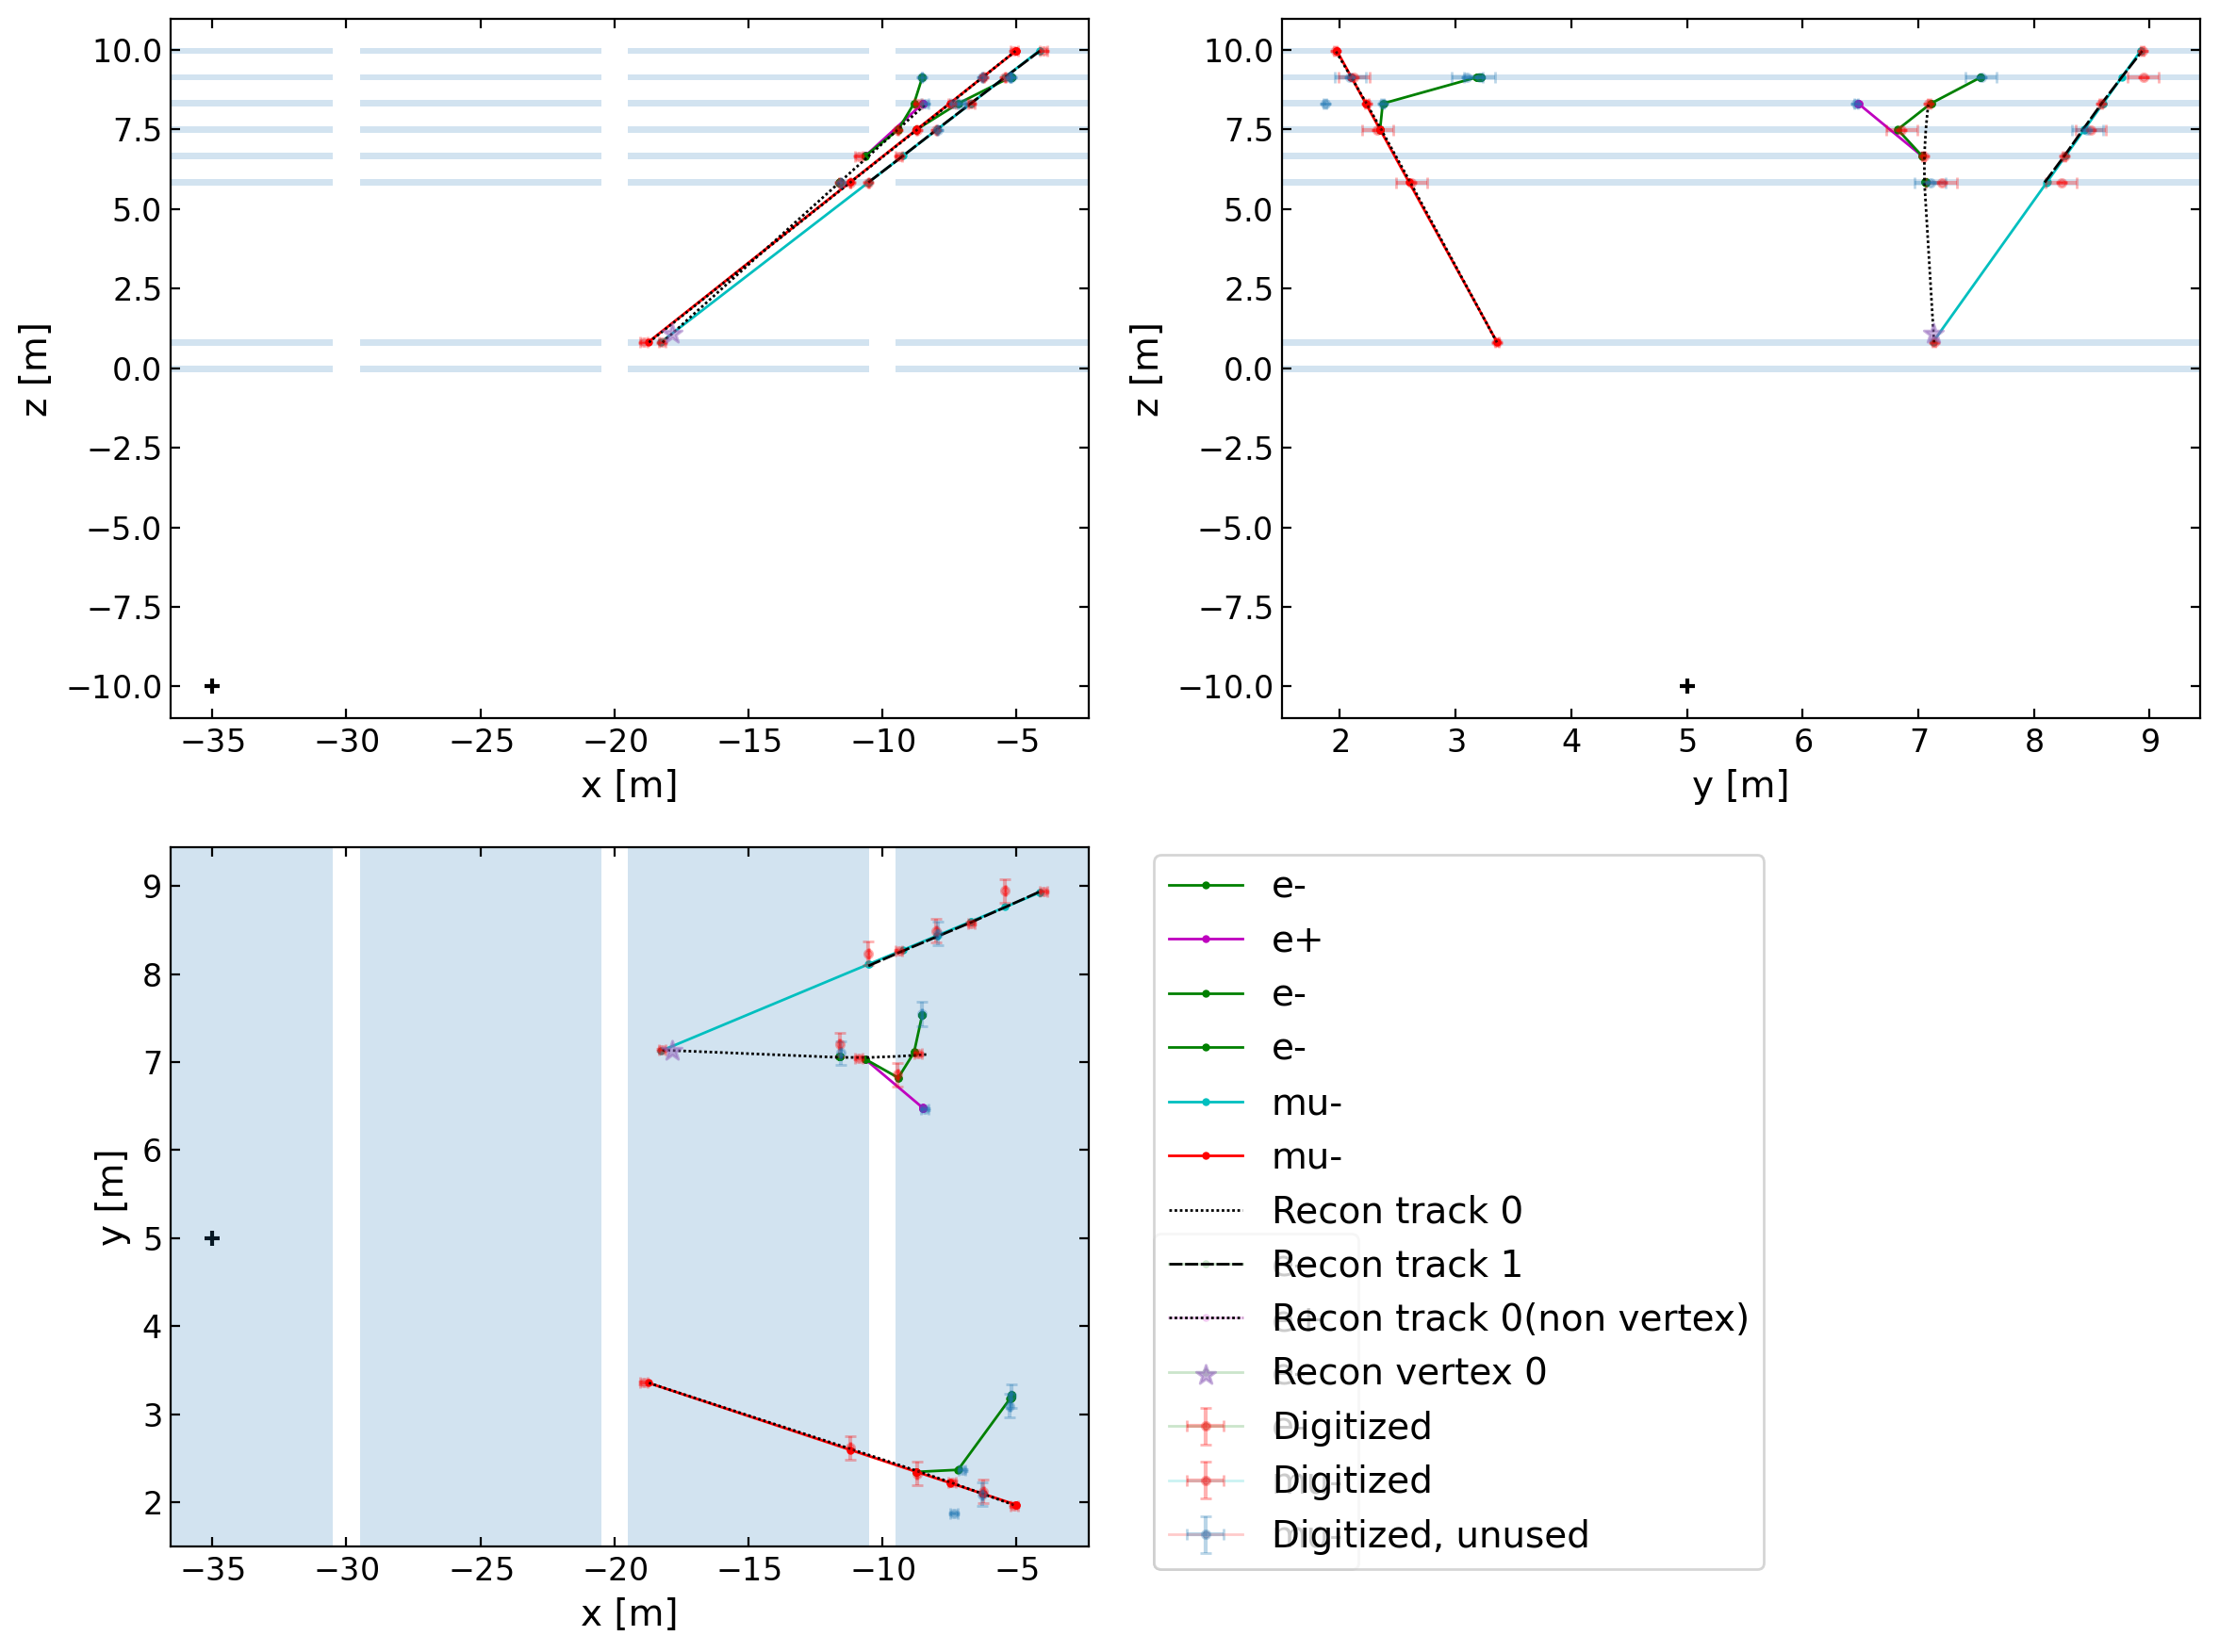

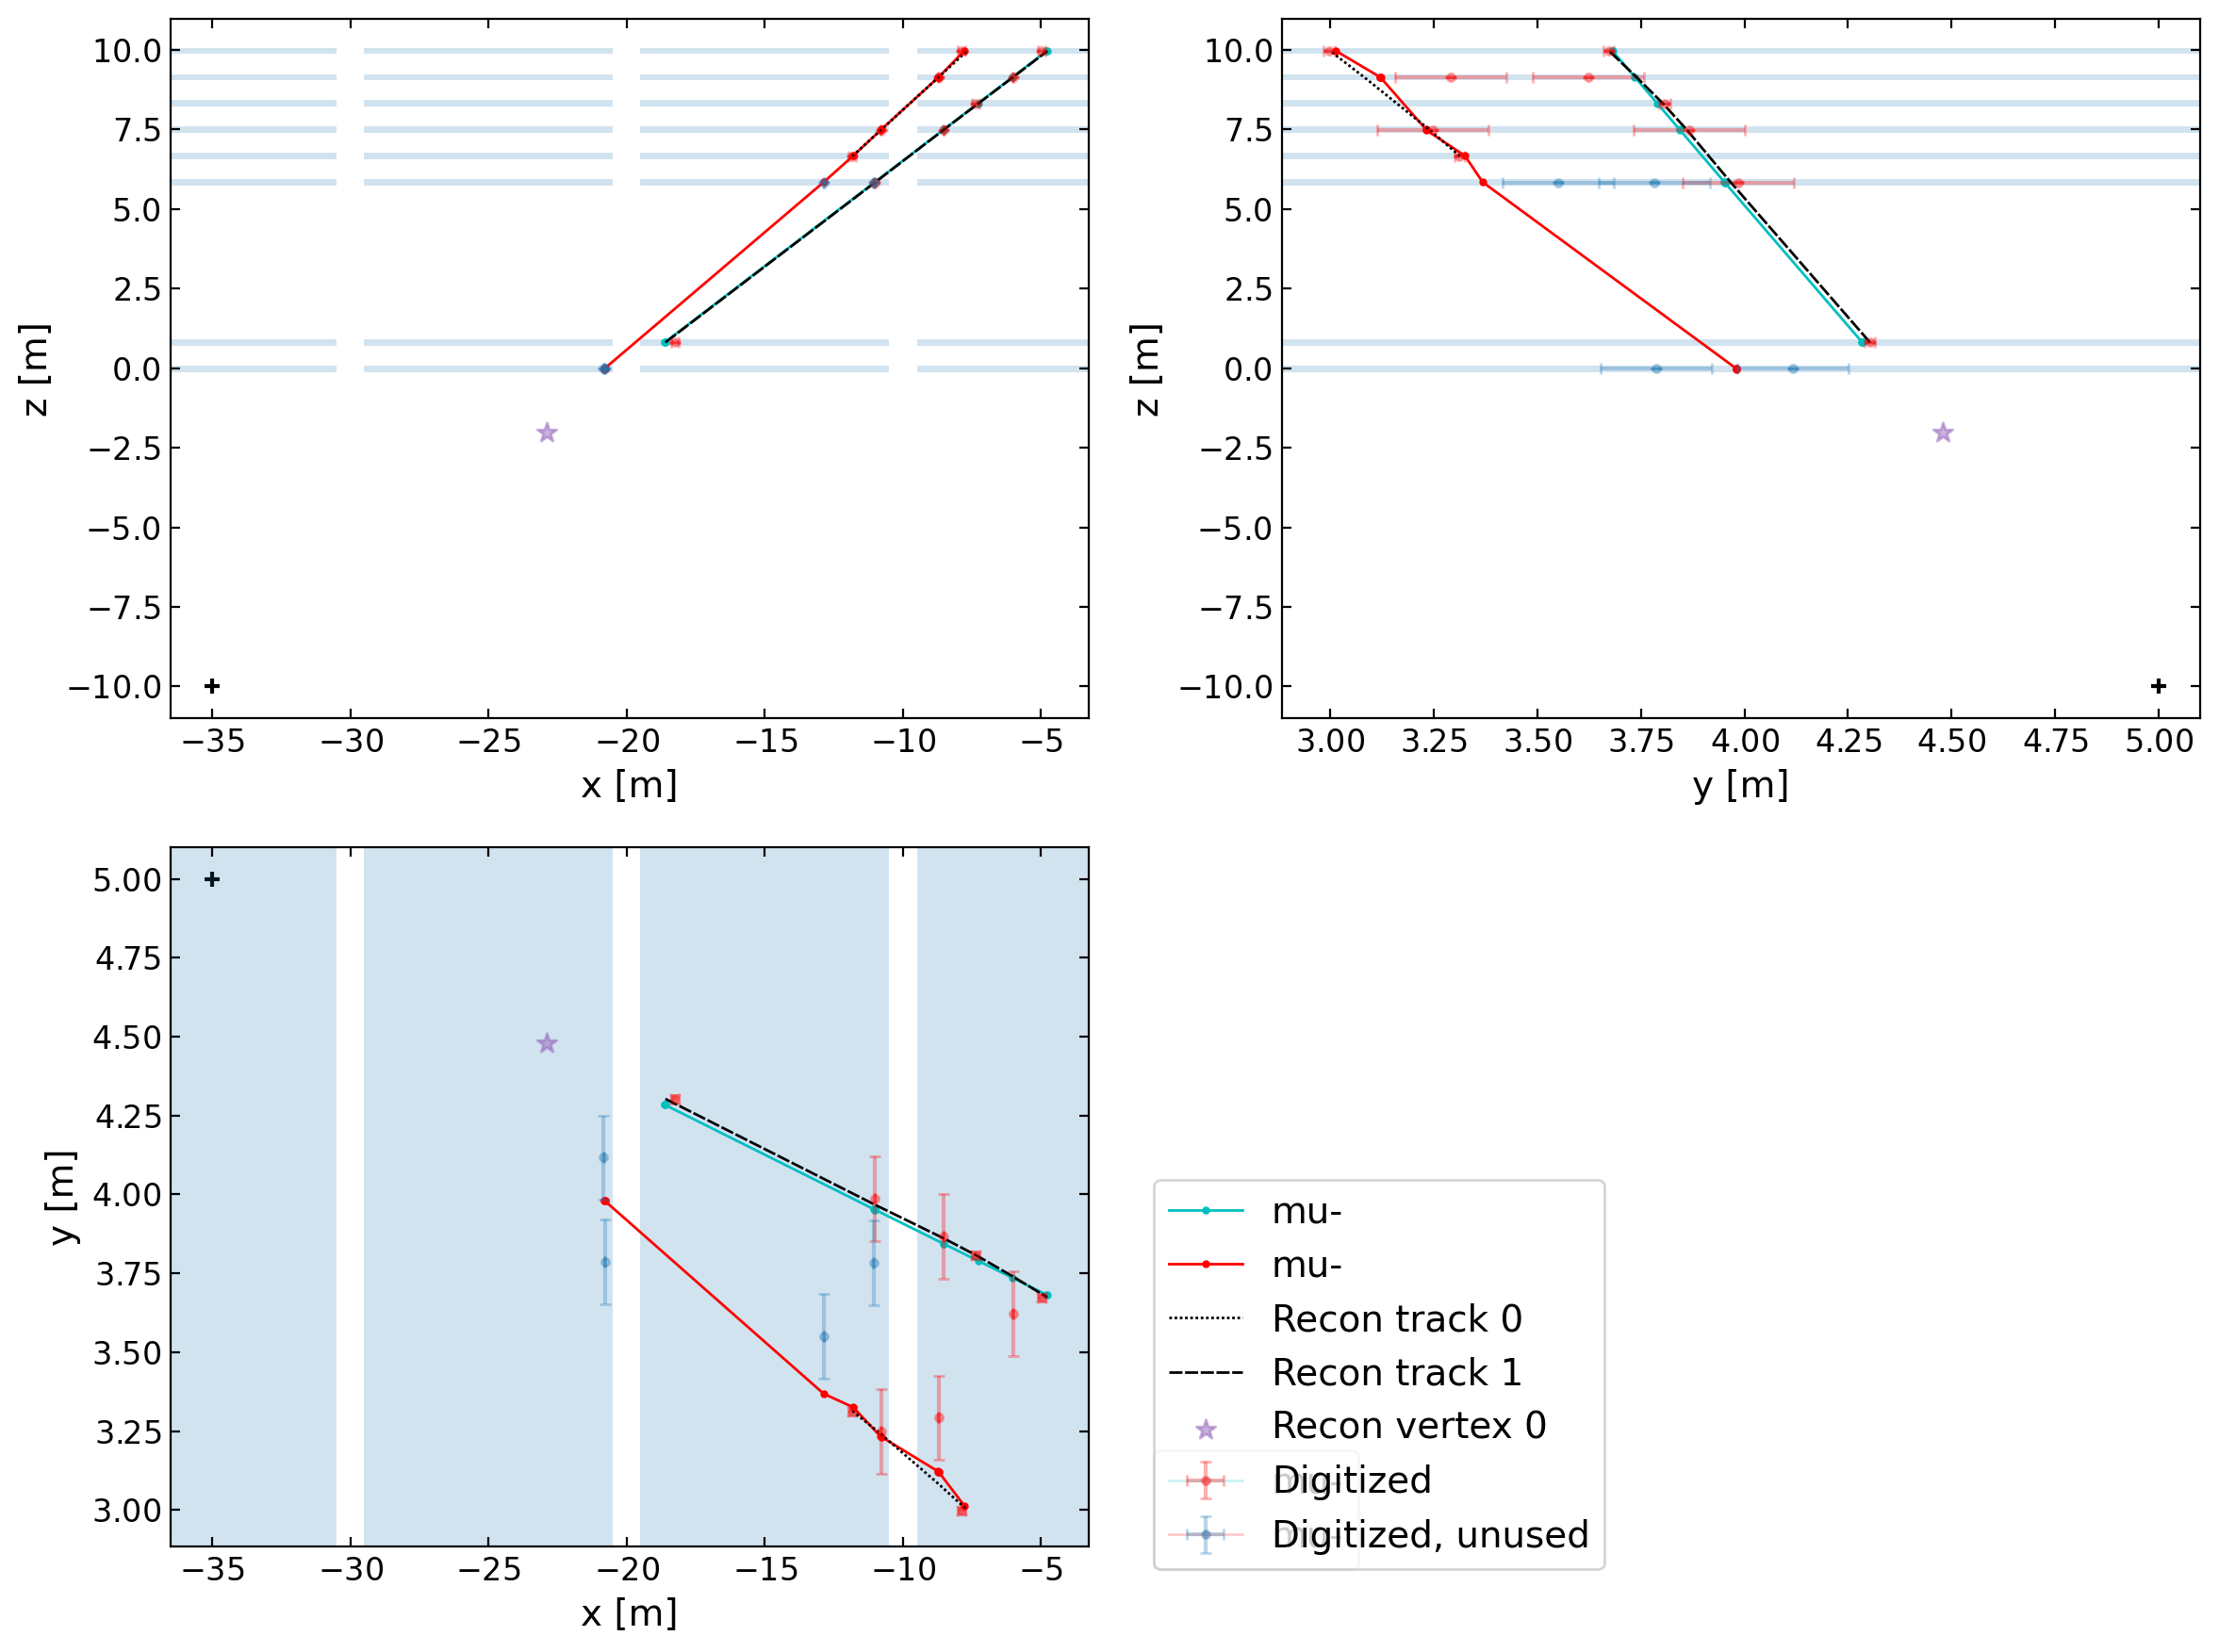

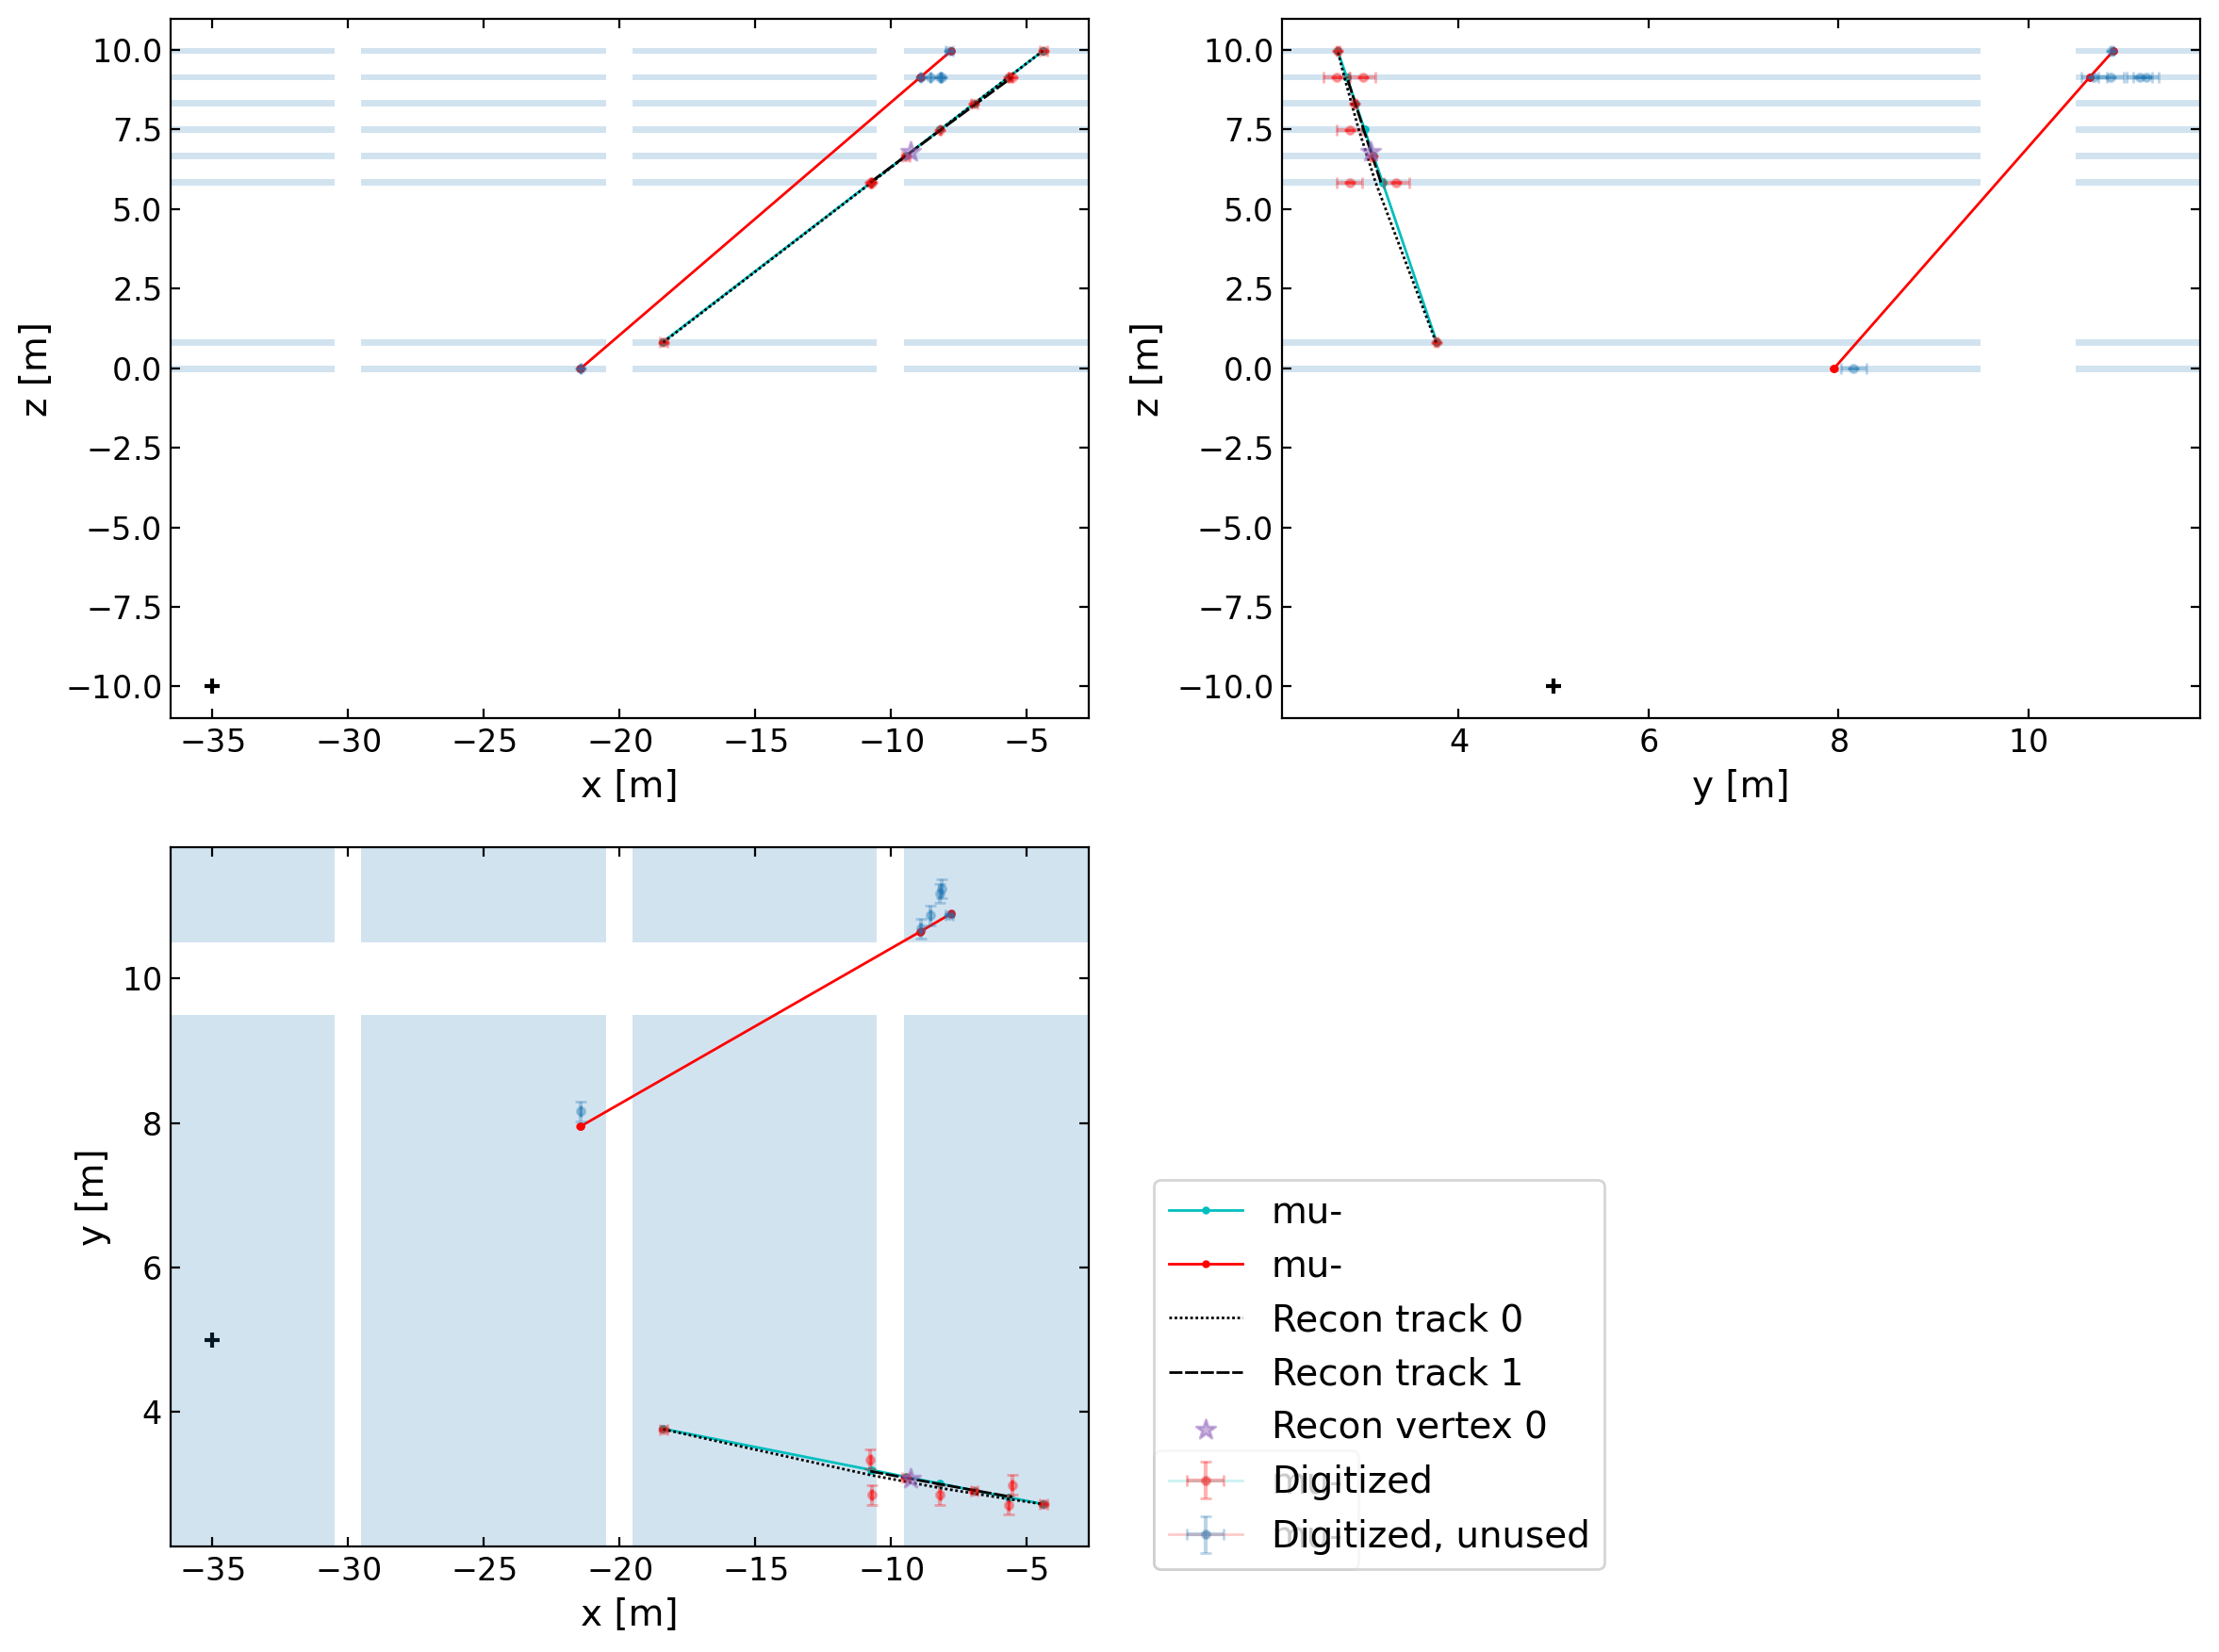

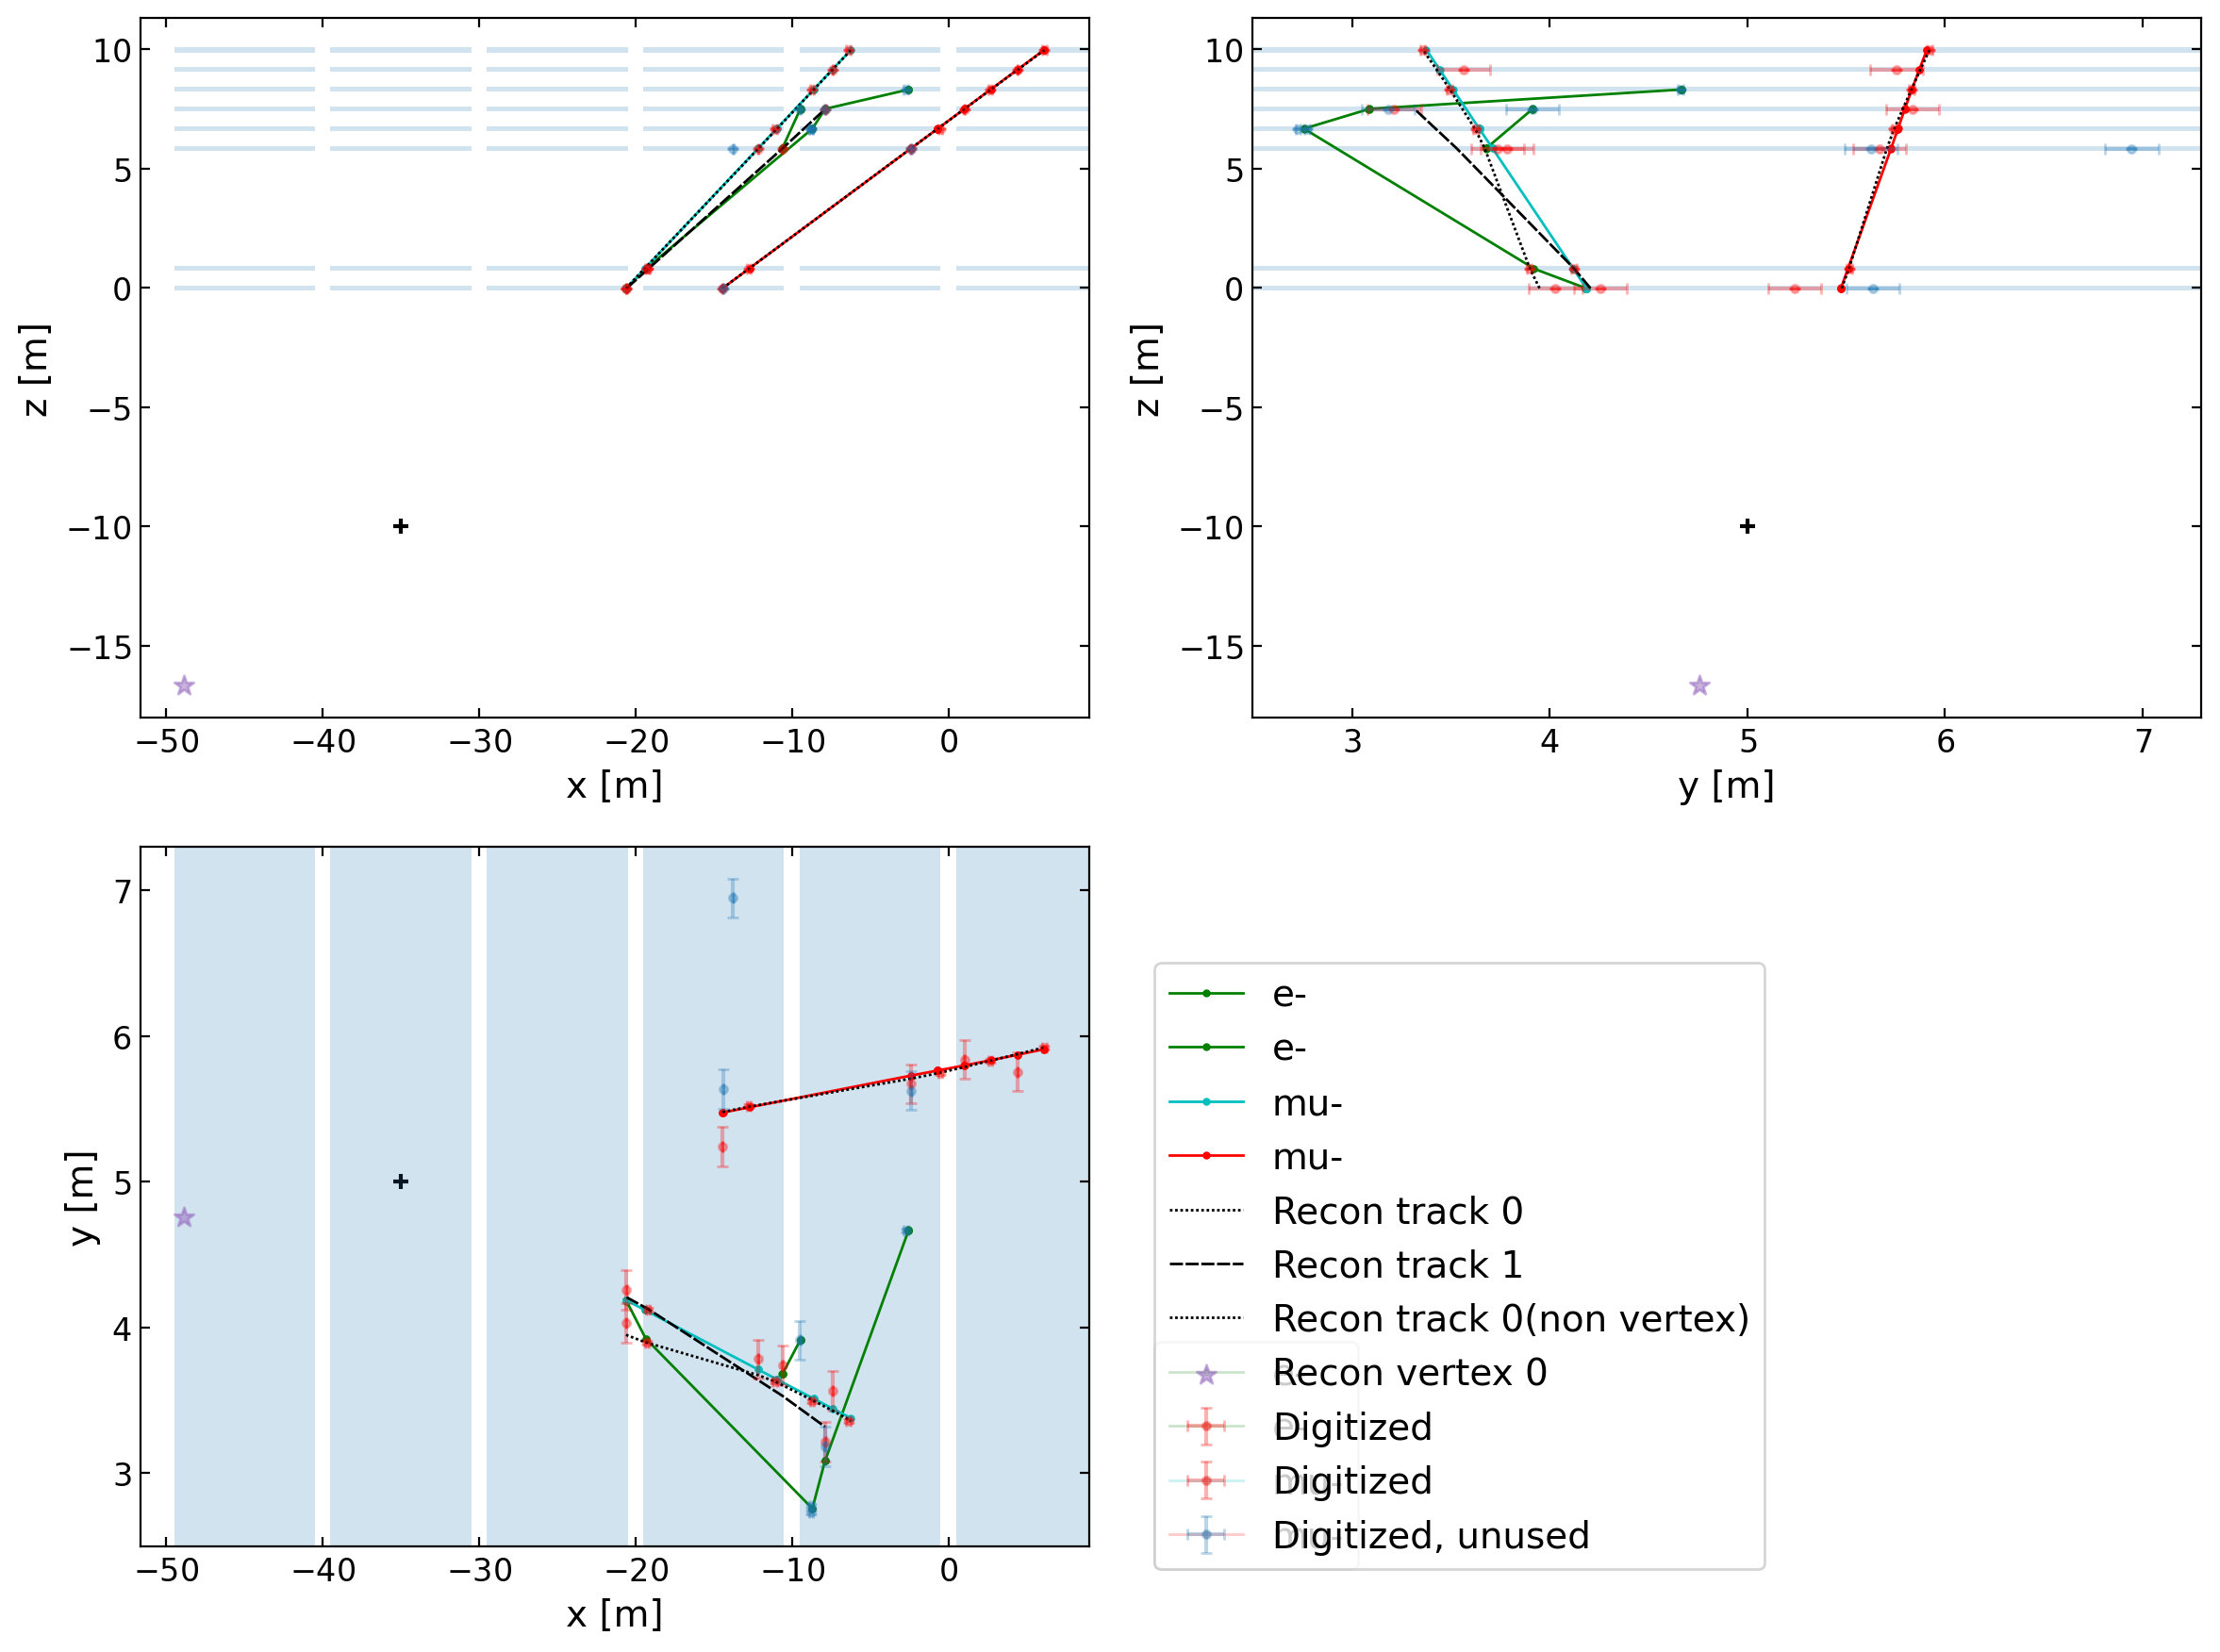

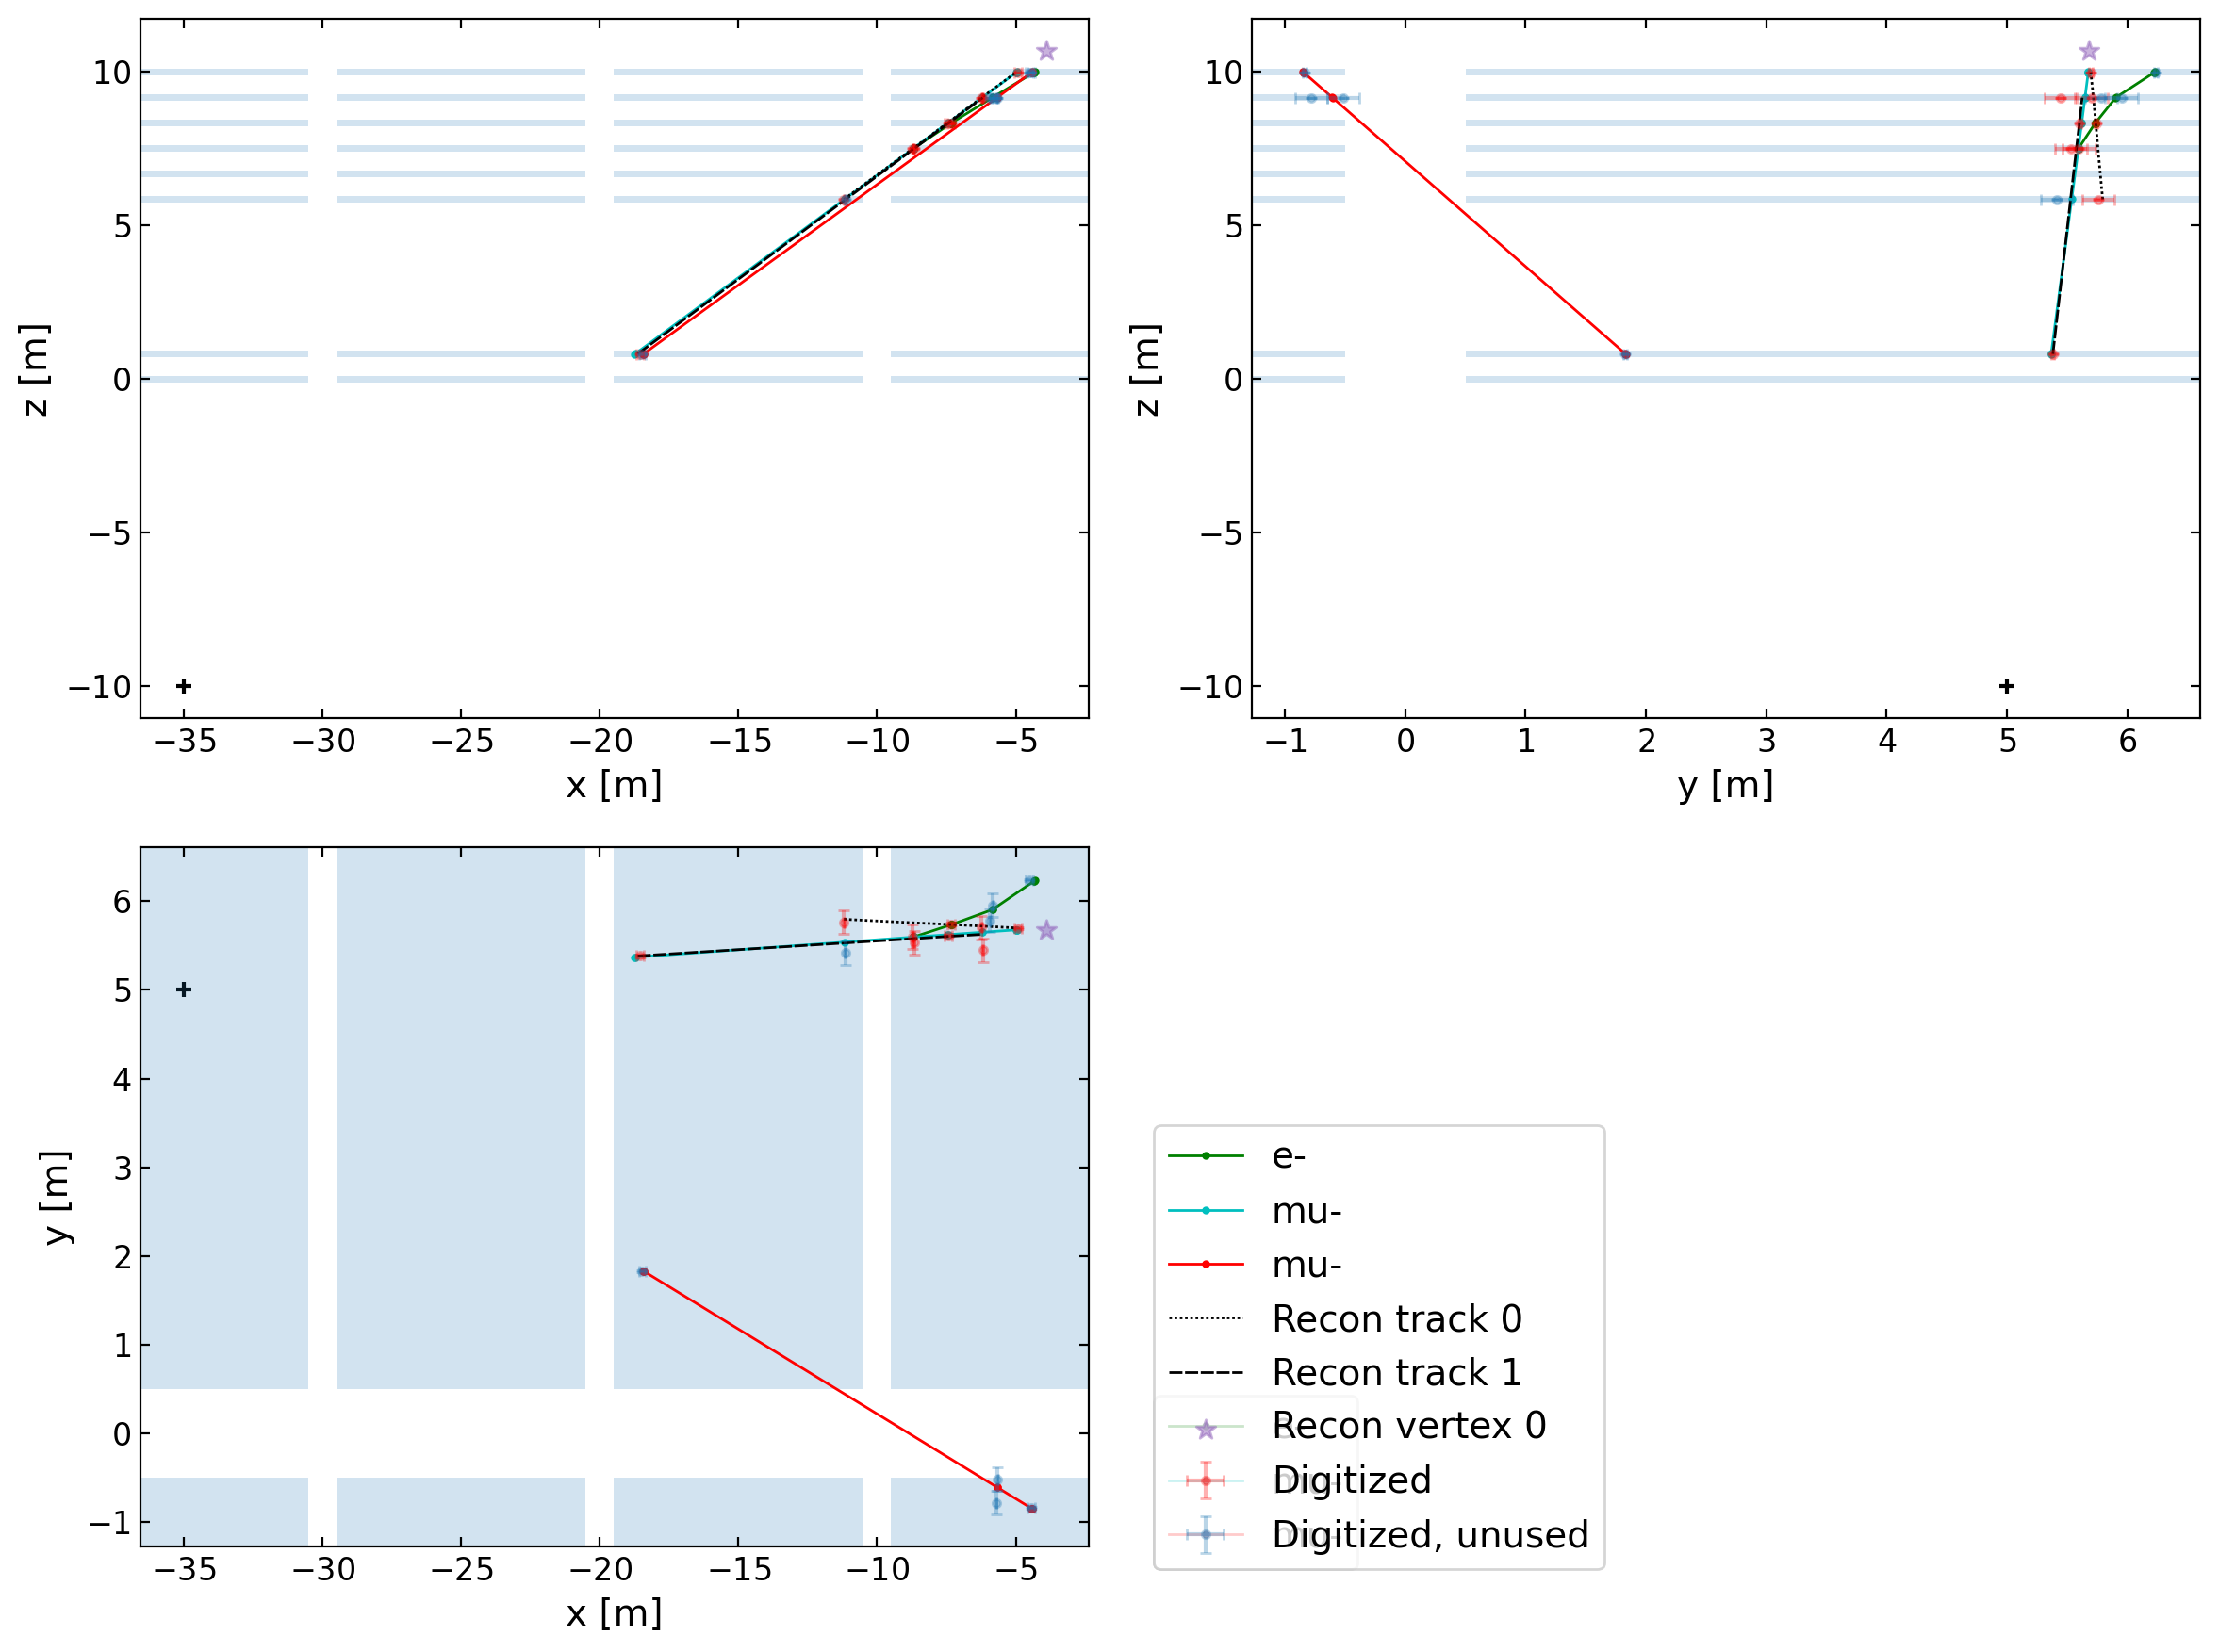

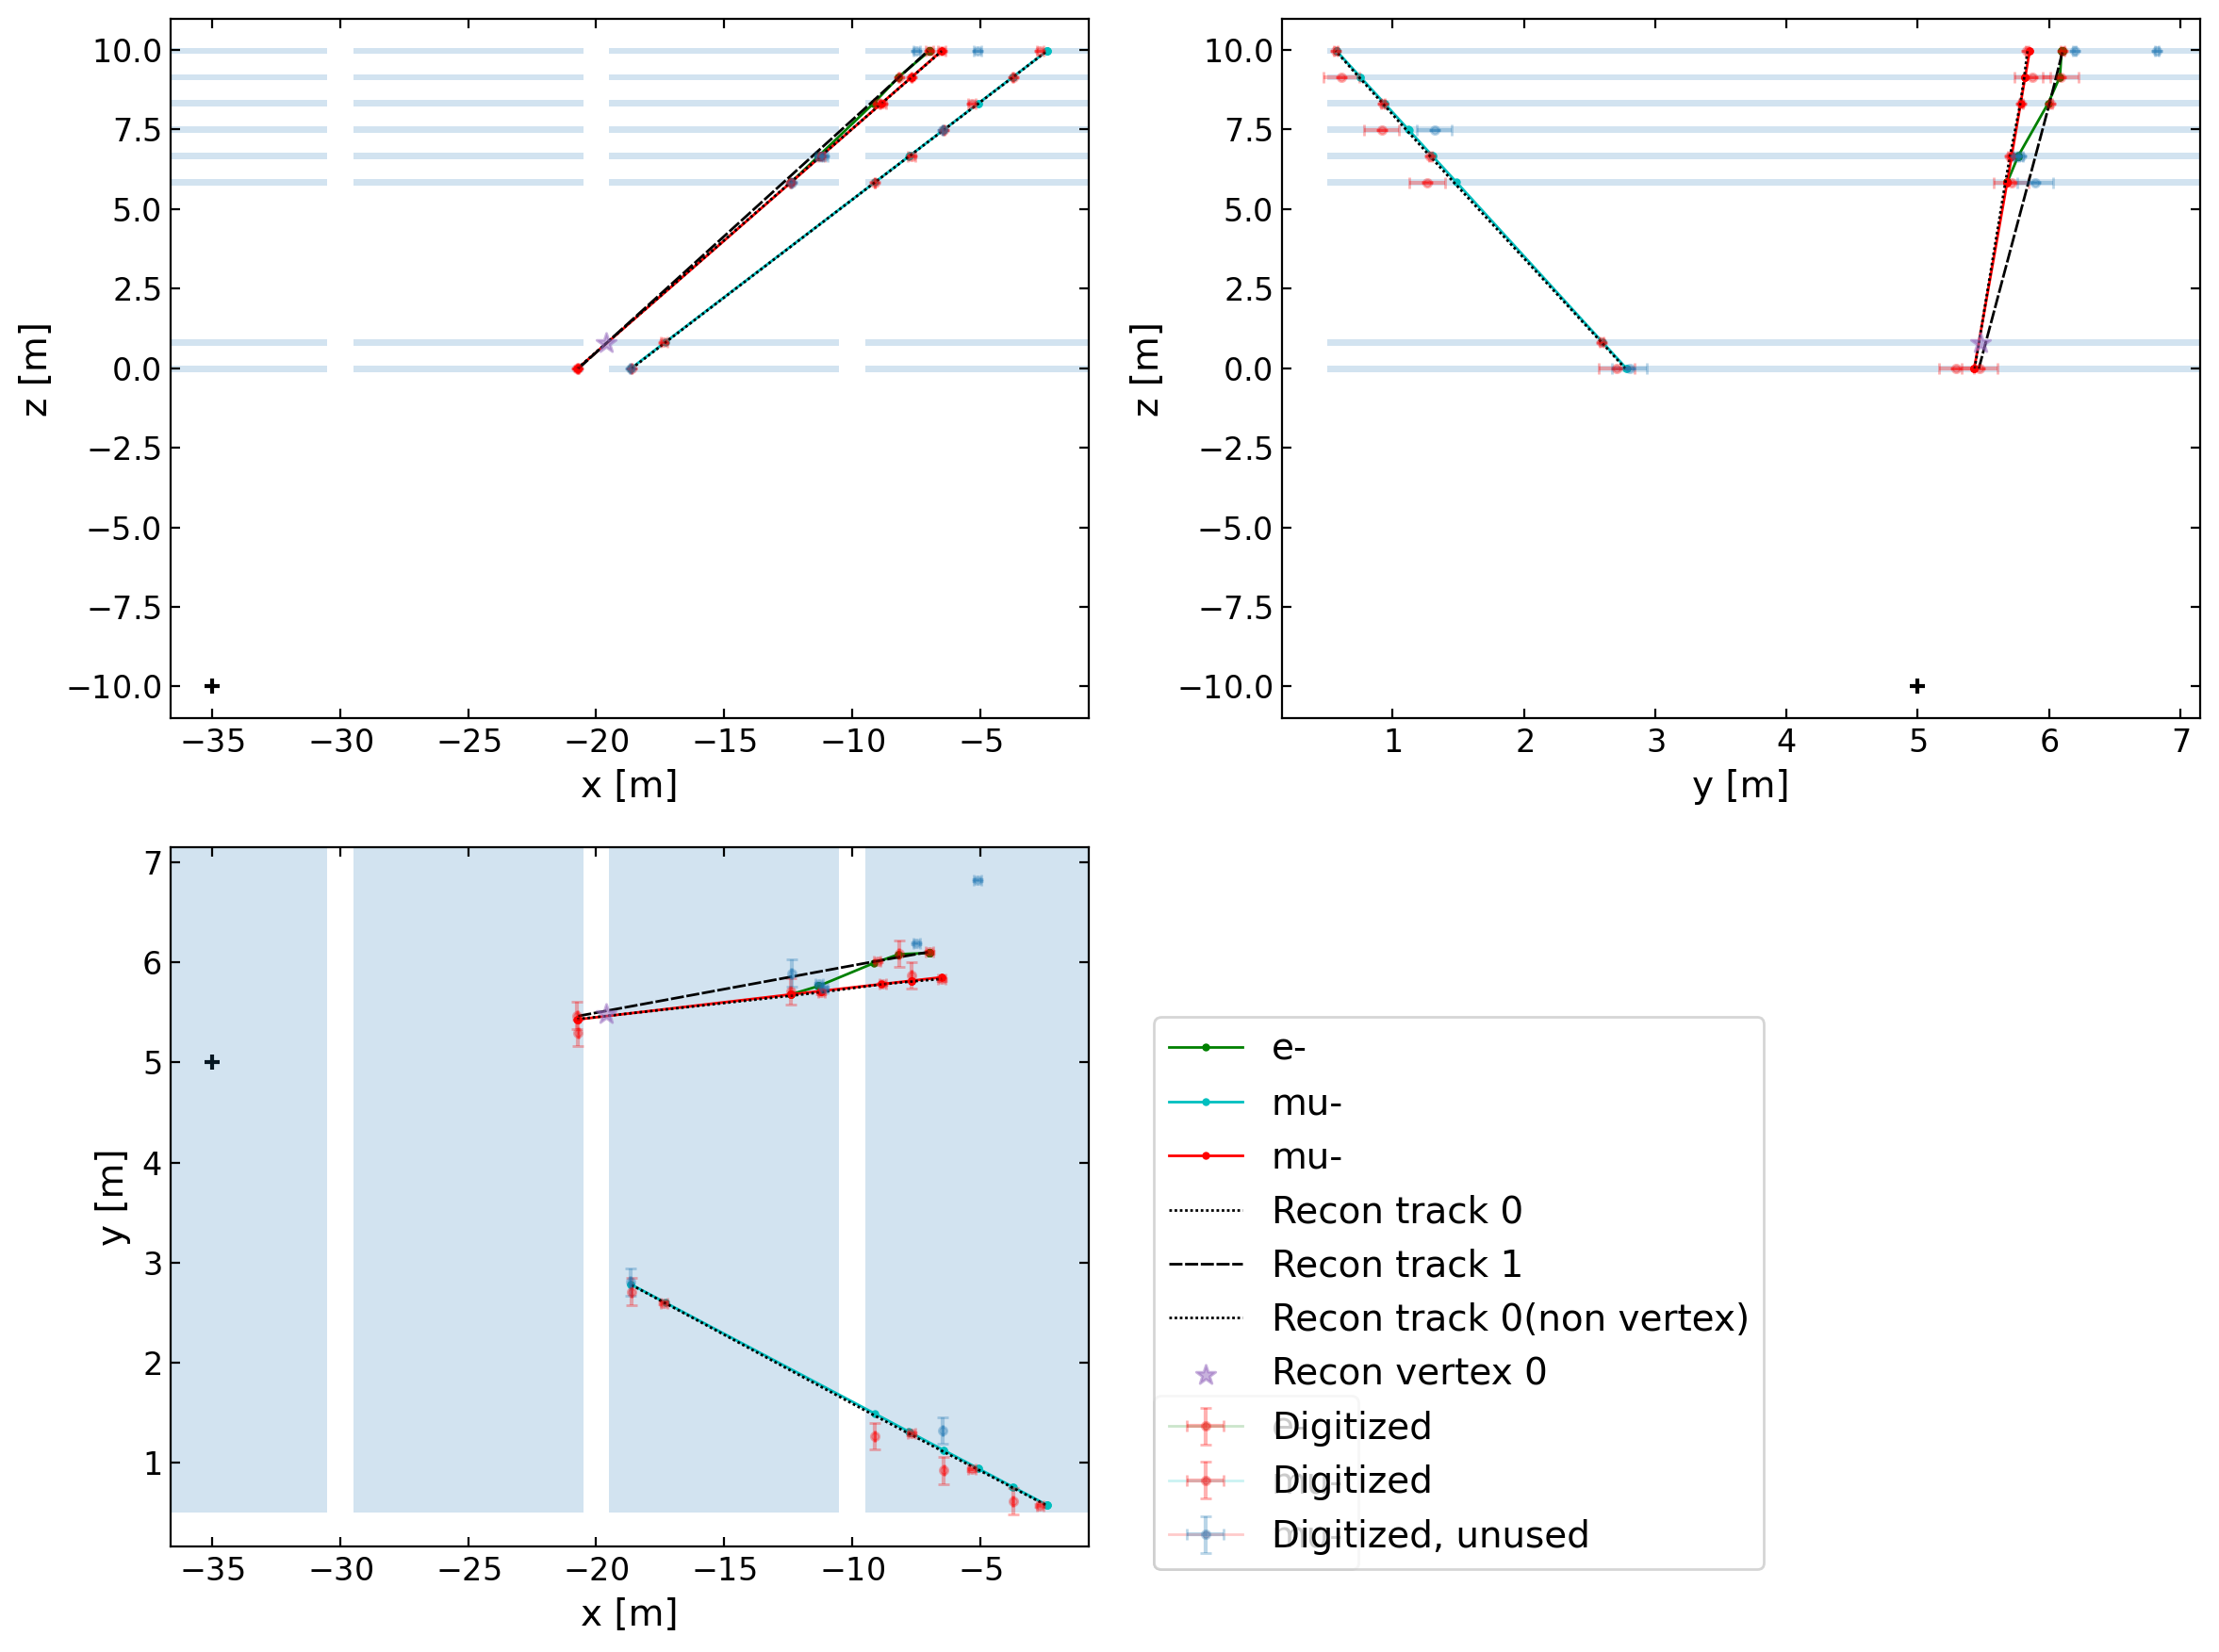

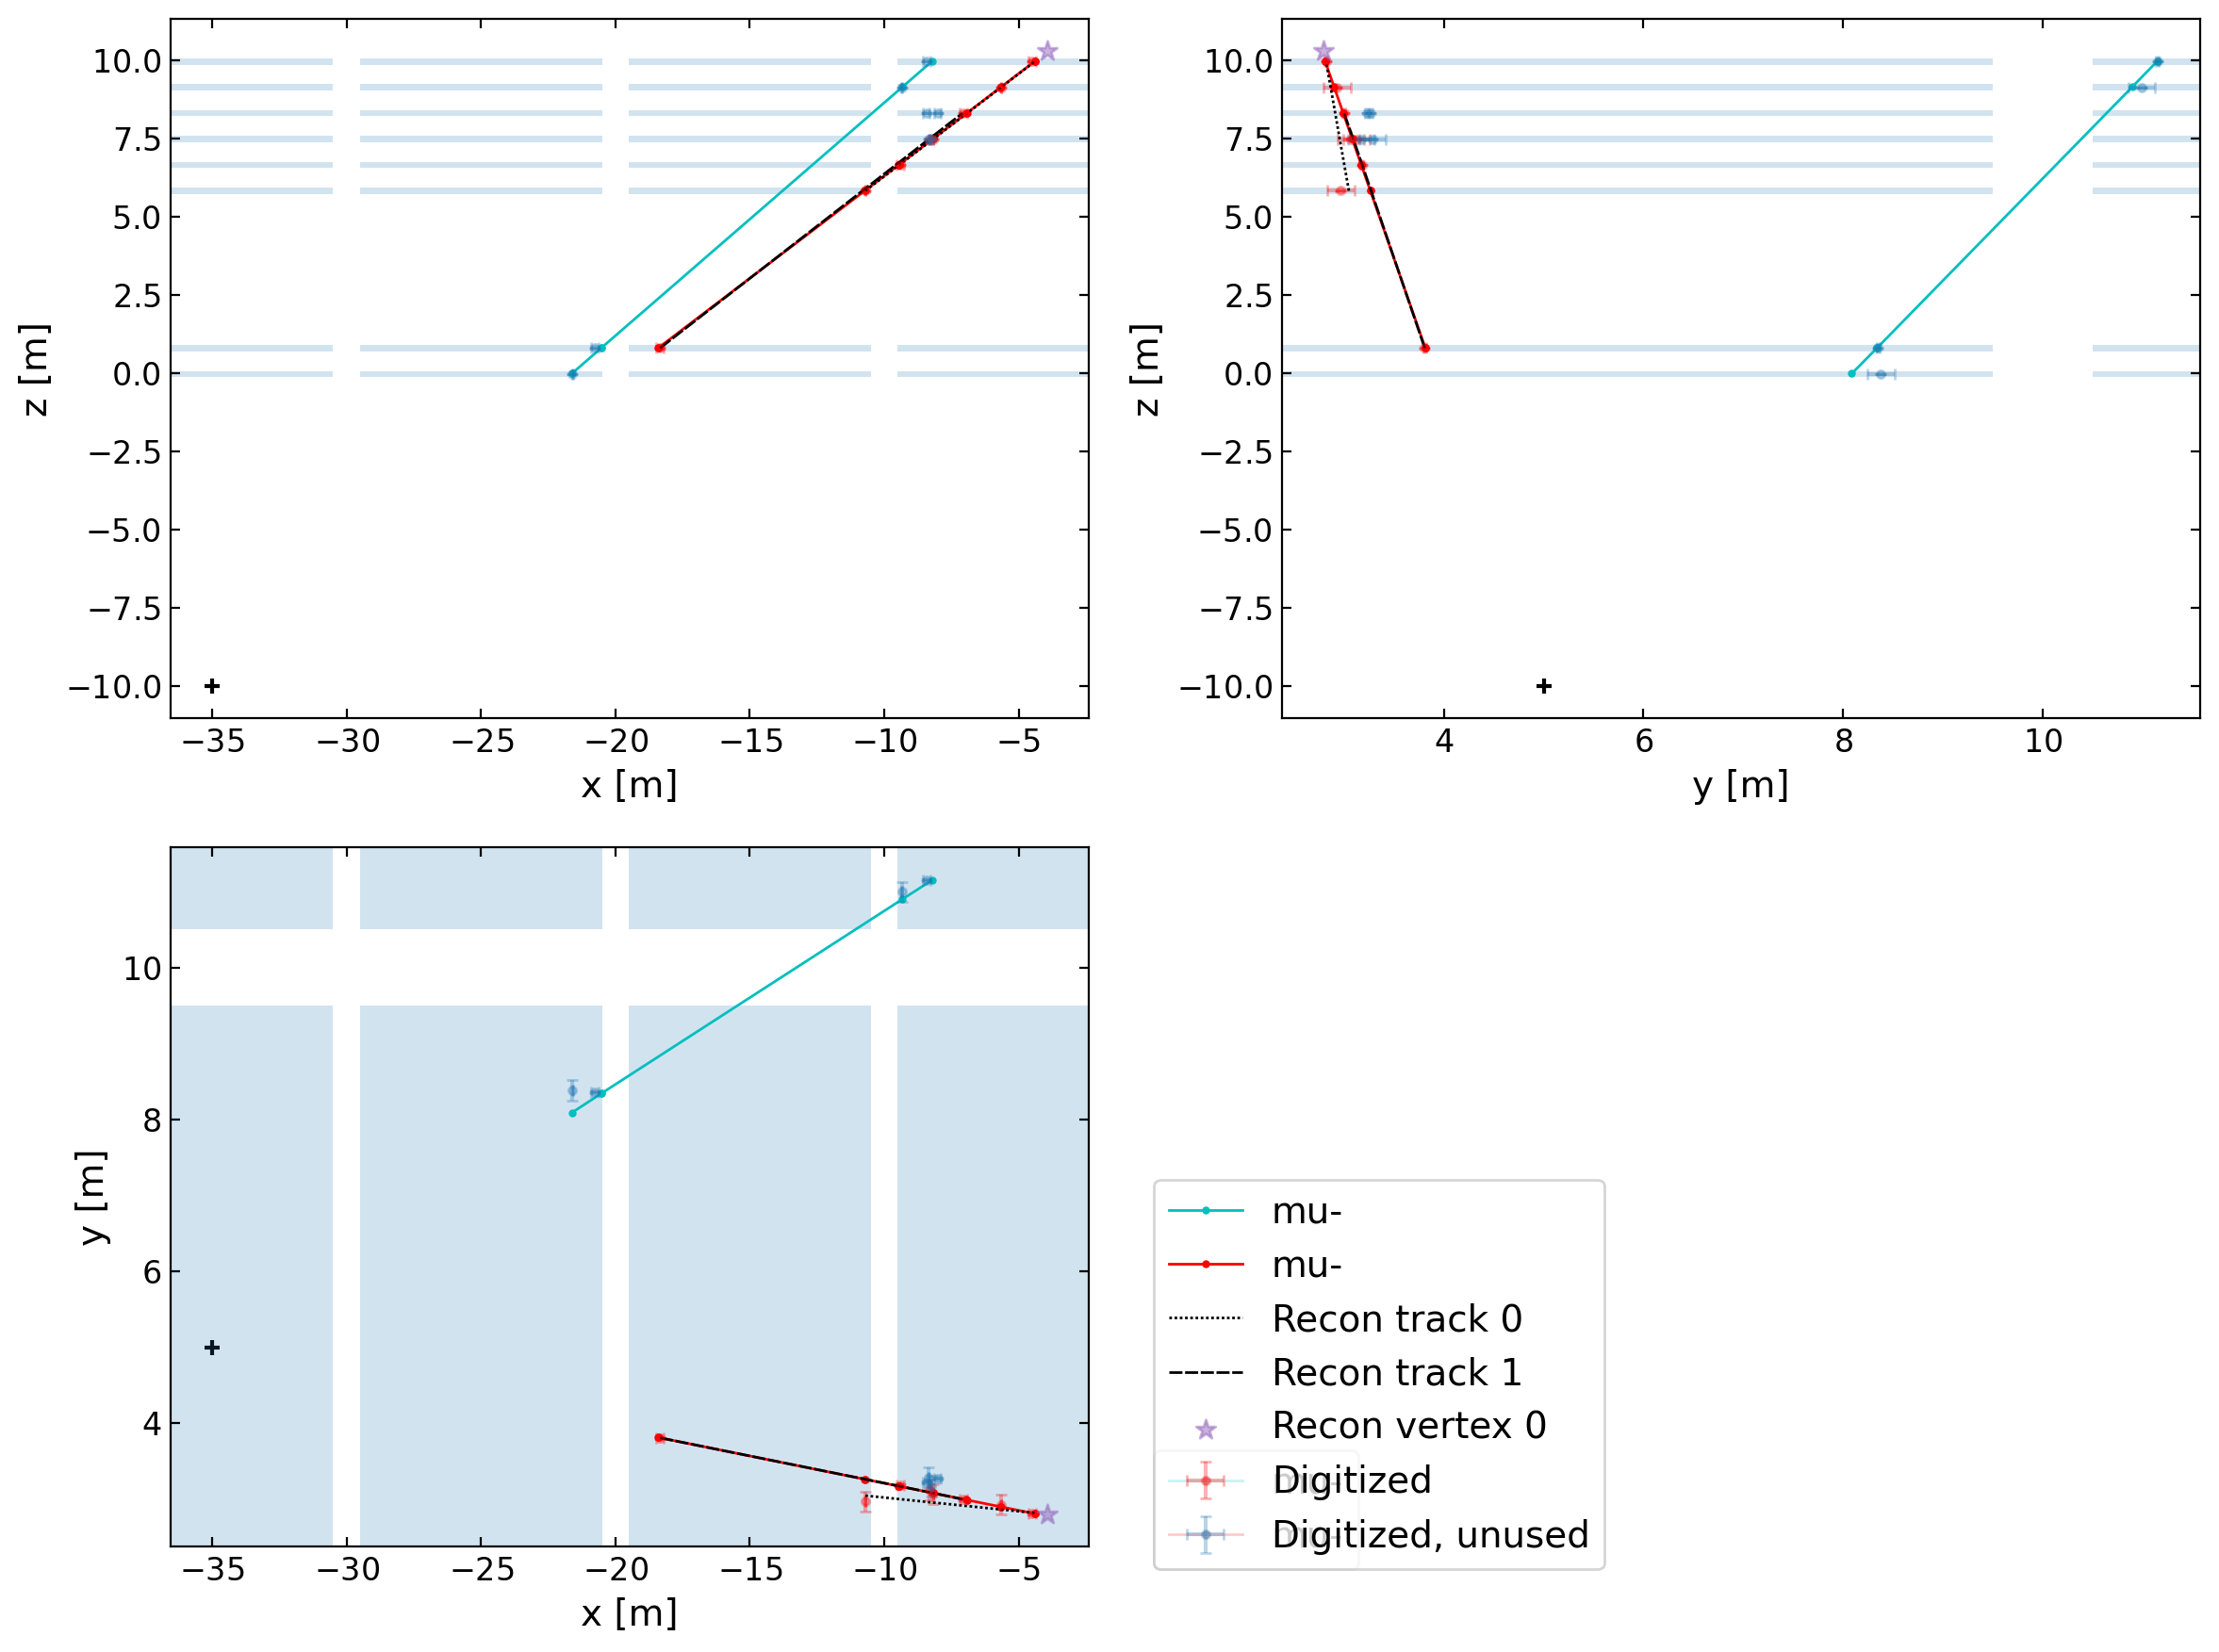

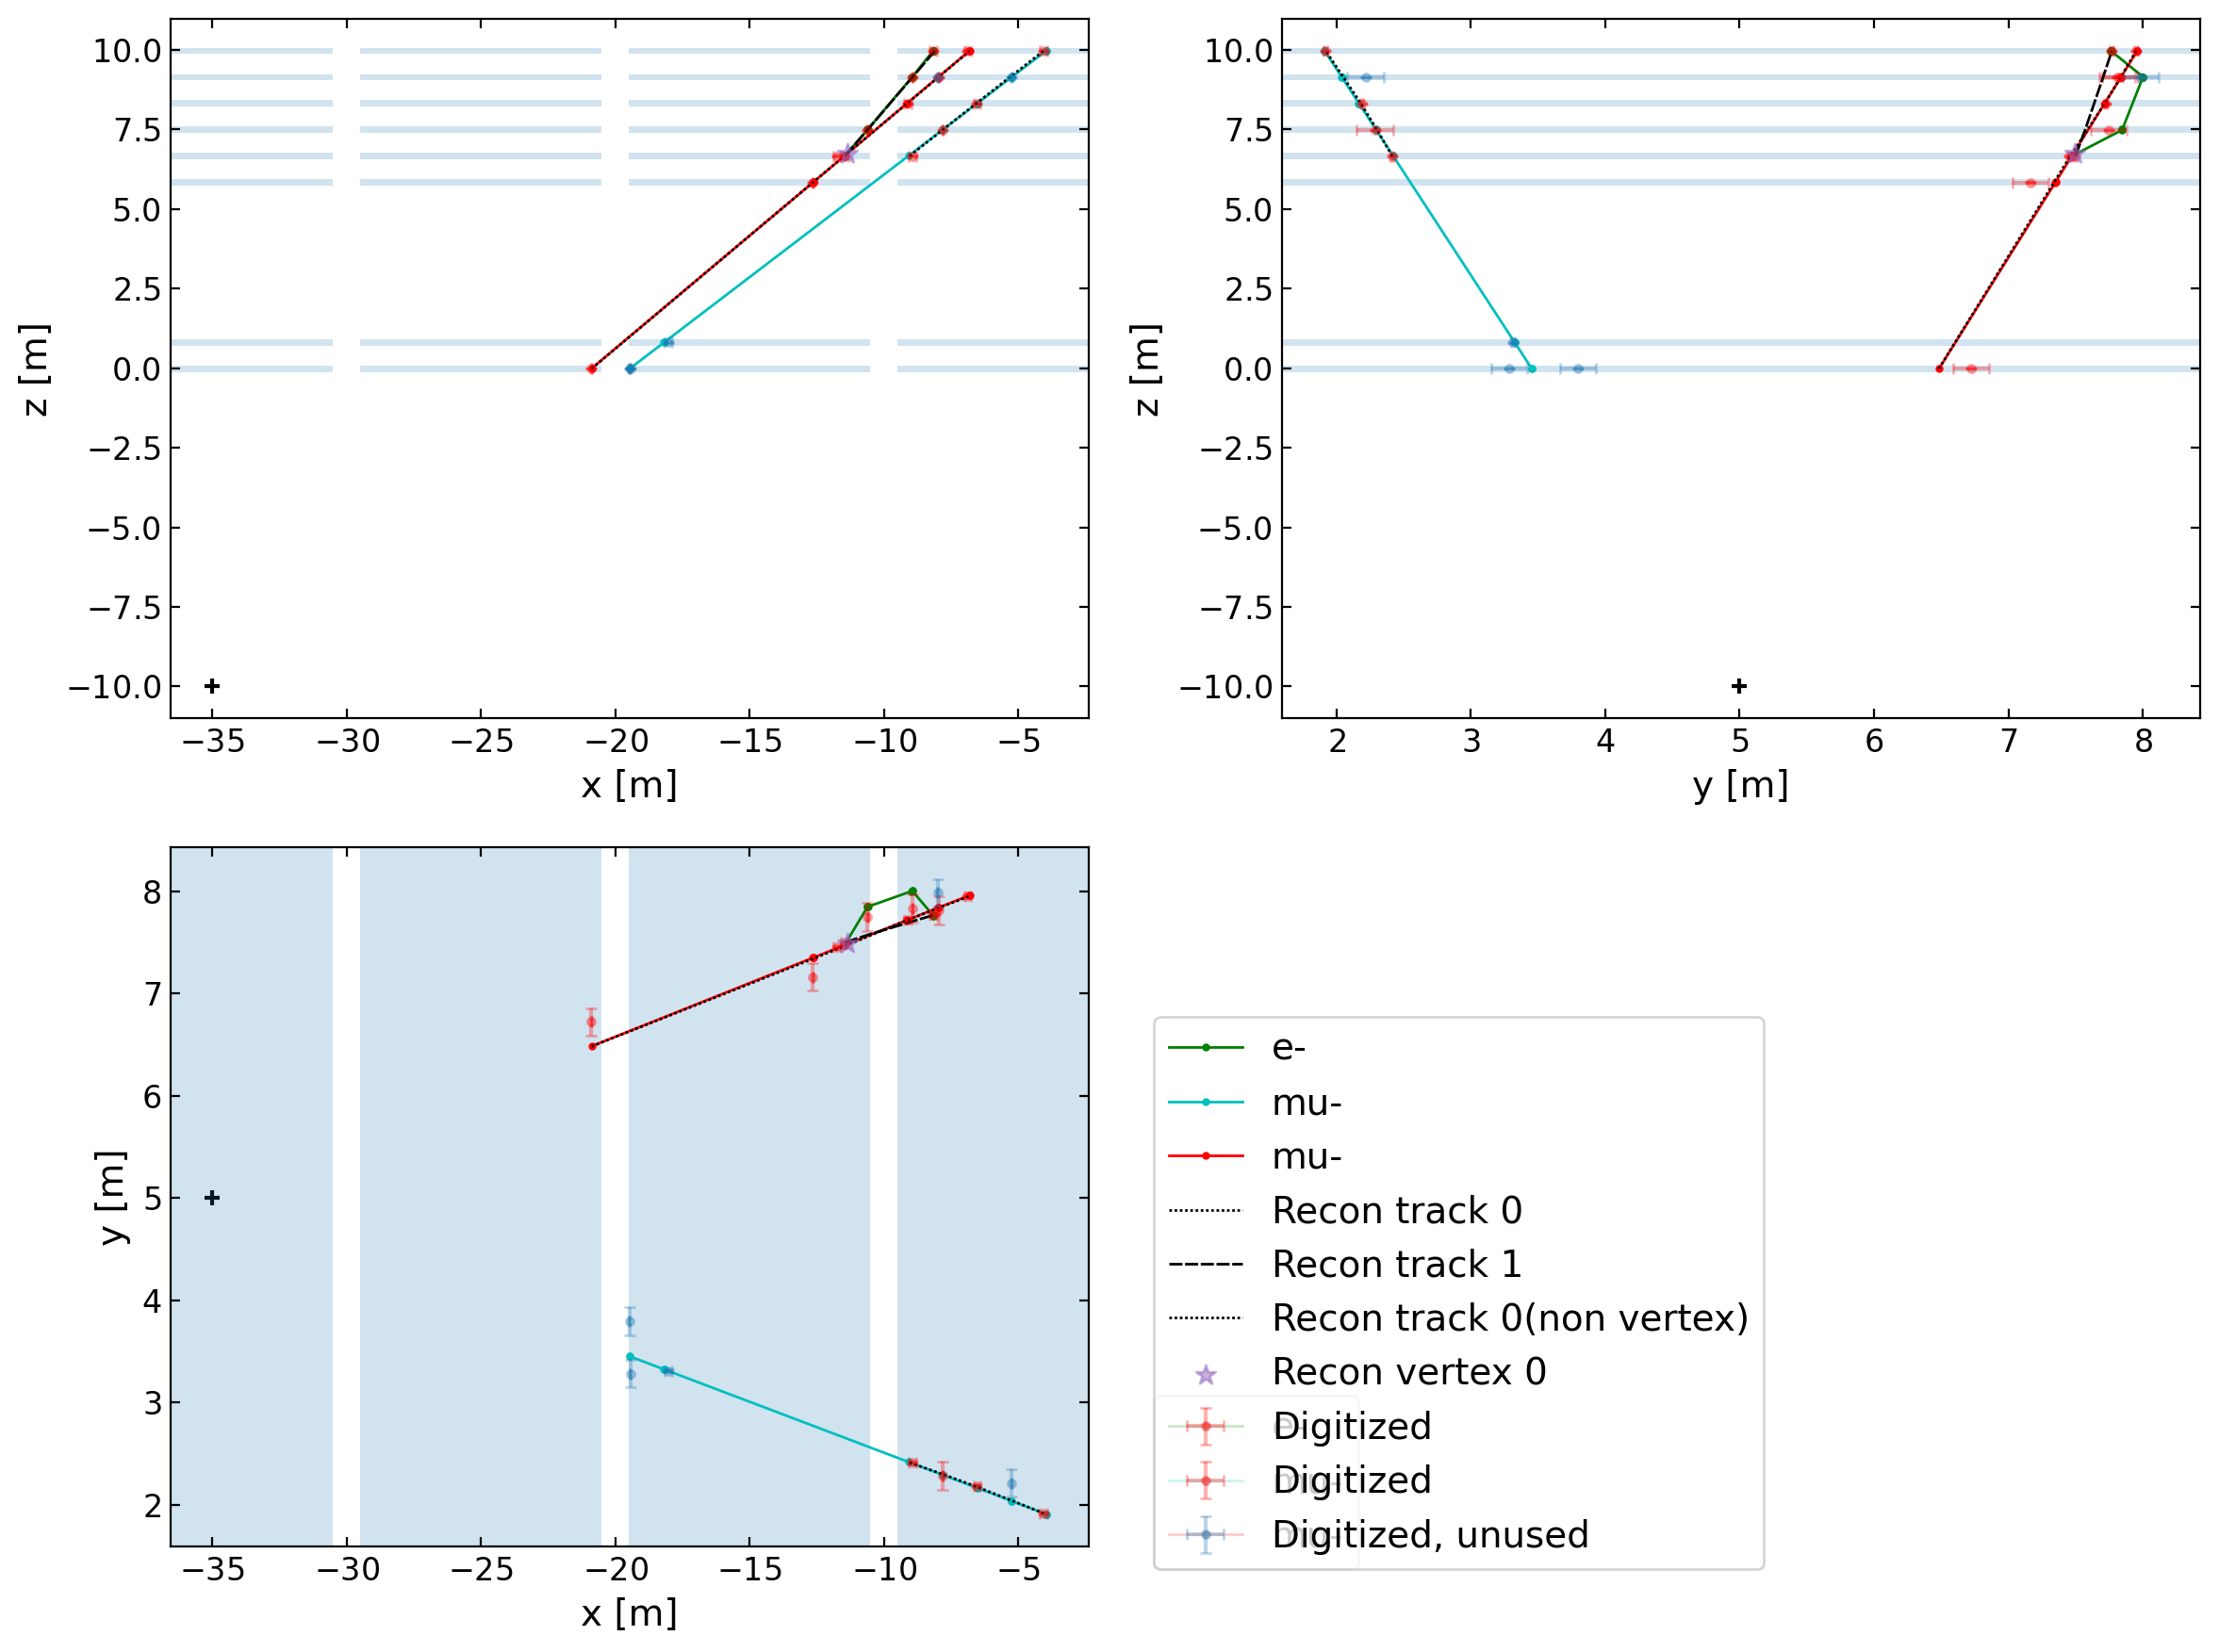

In [23]:
for j in range(10,33):
    
    # ev.EventNumber = Entry_failed[j]
    ev.EventNumber = Entry[mask_plot][j]
    if mask_reconstructible[ev.EventNumber]:


        # Plot truth
        fig,axs=plt.subplots(2,2,figsize=(12,9))
        fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=True, disp_first_hit=False);
        # Plot the truth vertex
        axs=fig.axes
        axs[0].scatter(vertex_DET[0],vertex_DET[2],color="black",marker="+")
        axs[1].scatter(vertex_DET[1],vertex_DET[2],color="black",marker="+")
        axs[2].scatter(vertex_DET[0],vertex_DET[1],color="black",marker="+",label="Vertex Truth ")

        # Plot Reconstruction
        fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True);
        show()

---
### Run the following cell after obtaining data for all input files

In [26]:
Data=[joblib.load(os.path.splitext(filenames[i])[0]+"_res.joblib") for i in range(len(filenames))]

Efficiency: 68% Original
Efficiency: 75% + Bug fix
Efficiency: 89% + Seed mod


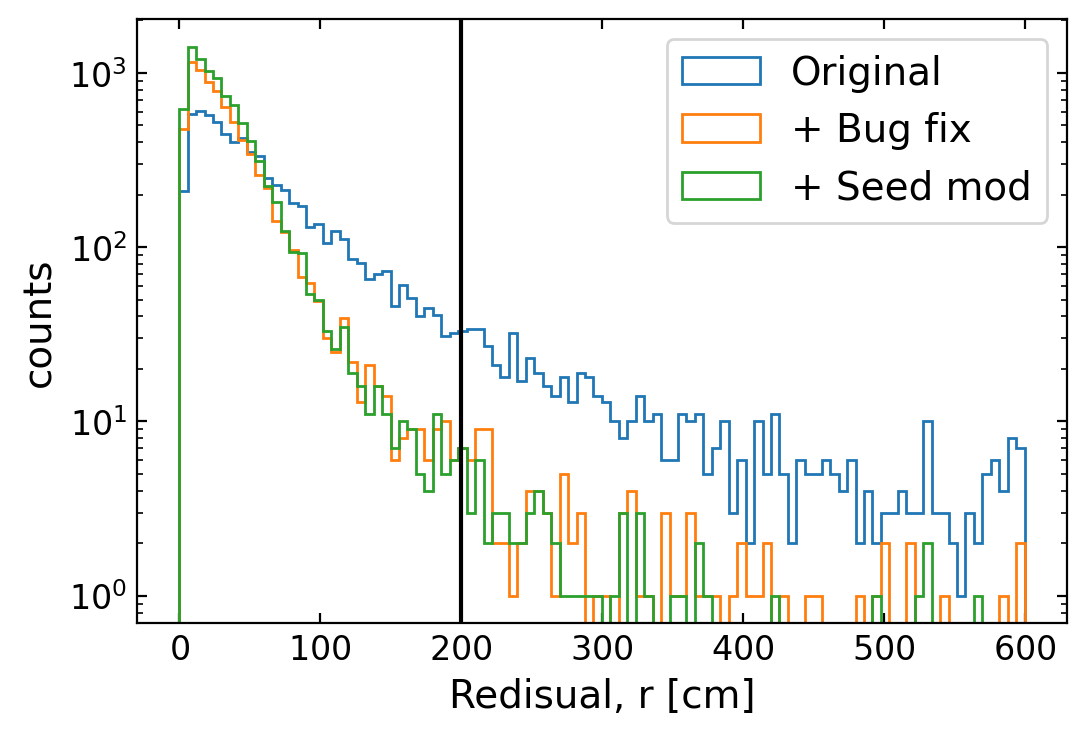

In [40]:
plotlabels = ["Original", "+ Bug fix", "+ Seed mod"]

for idata in range(3):
    data=Data[idata]
    residual = data["residual"]
    residual_r = np.linalg.norm(residual[:,:3],axis=1)
    mask_residual = residual_r<200
    hist(residual_r,range=(0,600),histtype="step",label=plotlabels[idata])
    print(f"Efficiency: {sum(mask_residual)/10000*100:.0f}%",plotlabels[idata])
xlabel("Redisual, r [cm]")
ylabel("counts")
legend()
yscale("log")
axvline(200,color="k")

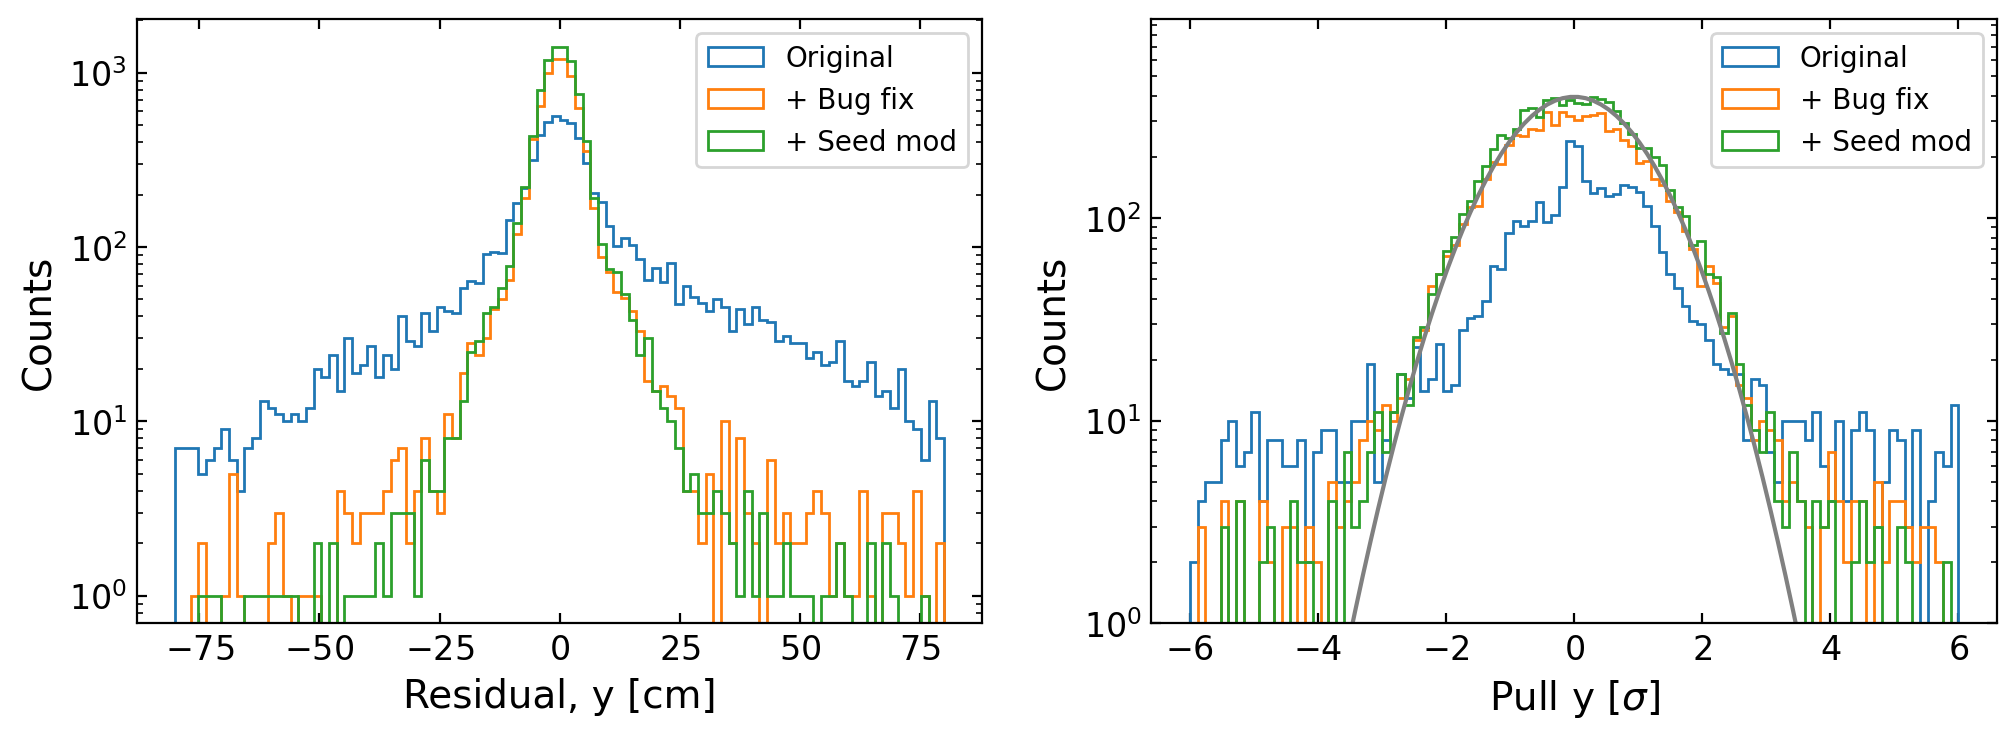

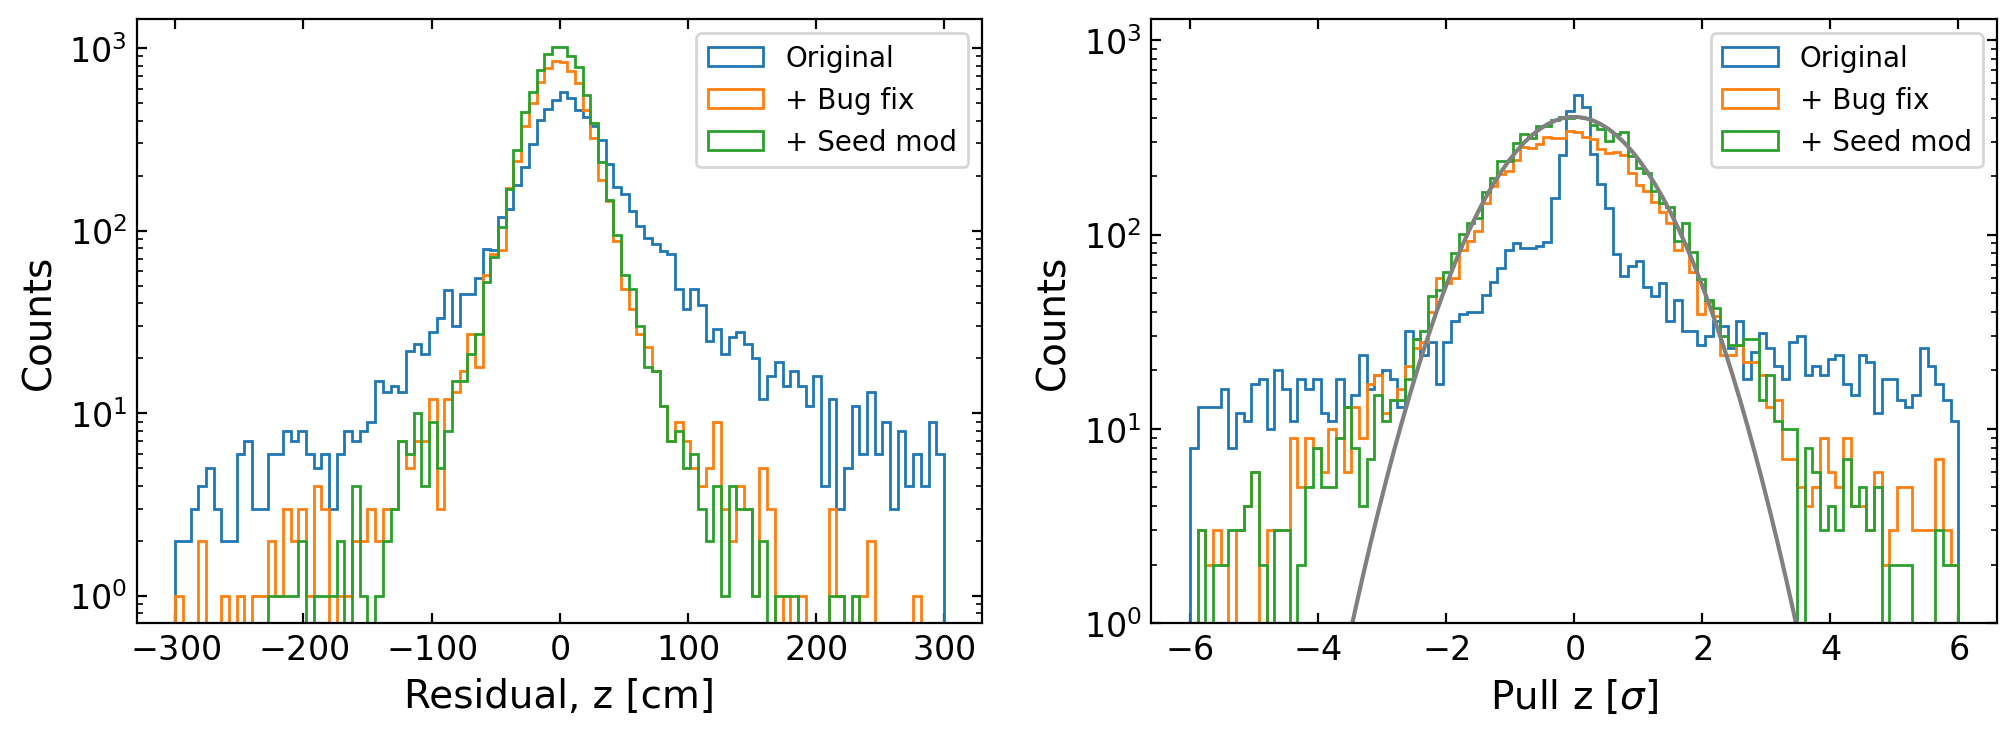

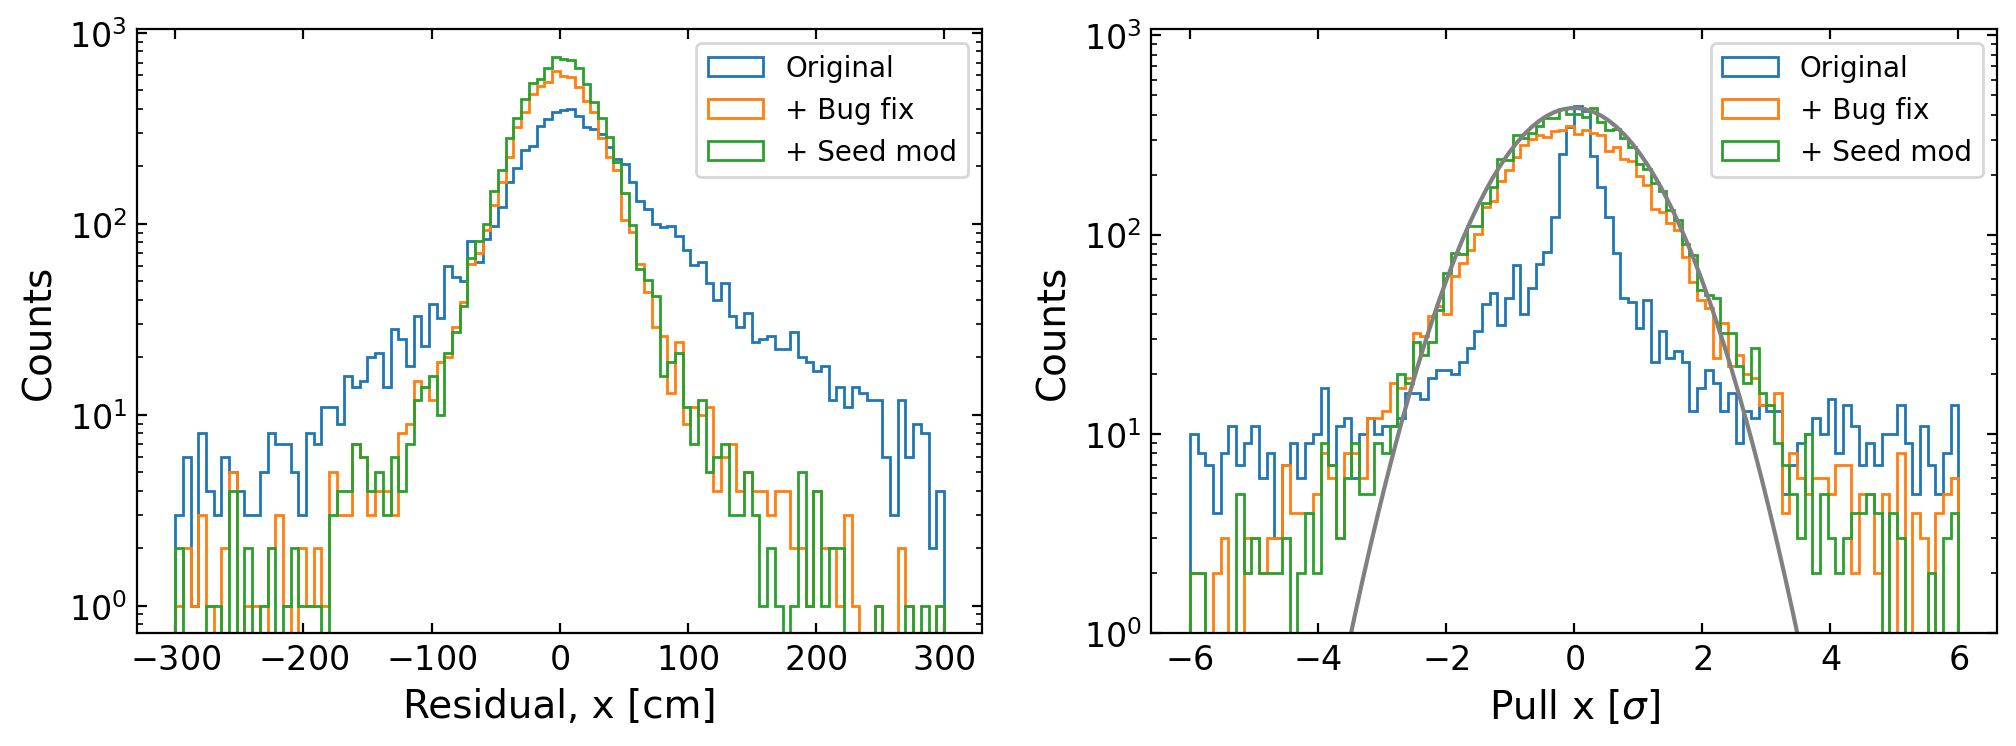

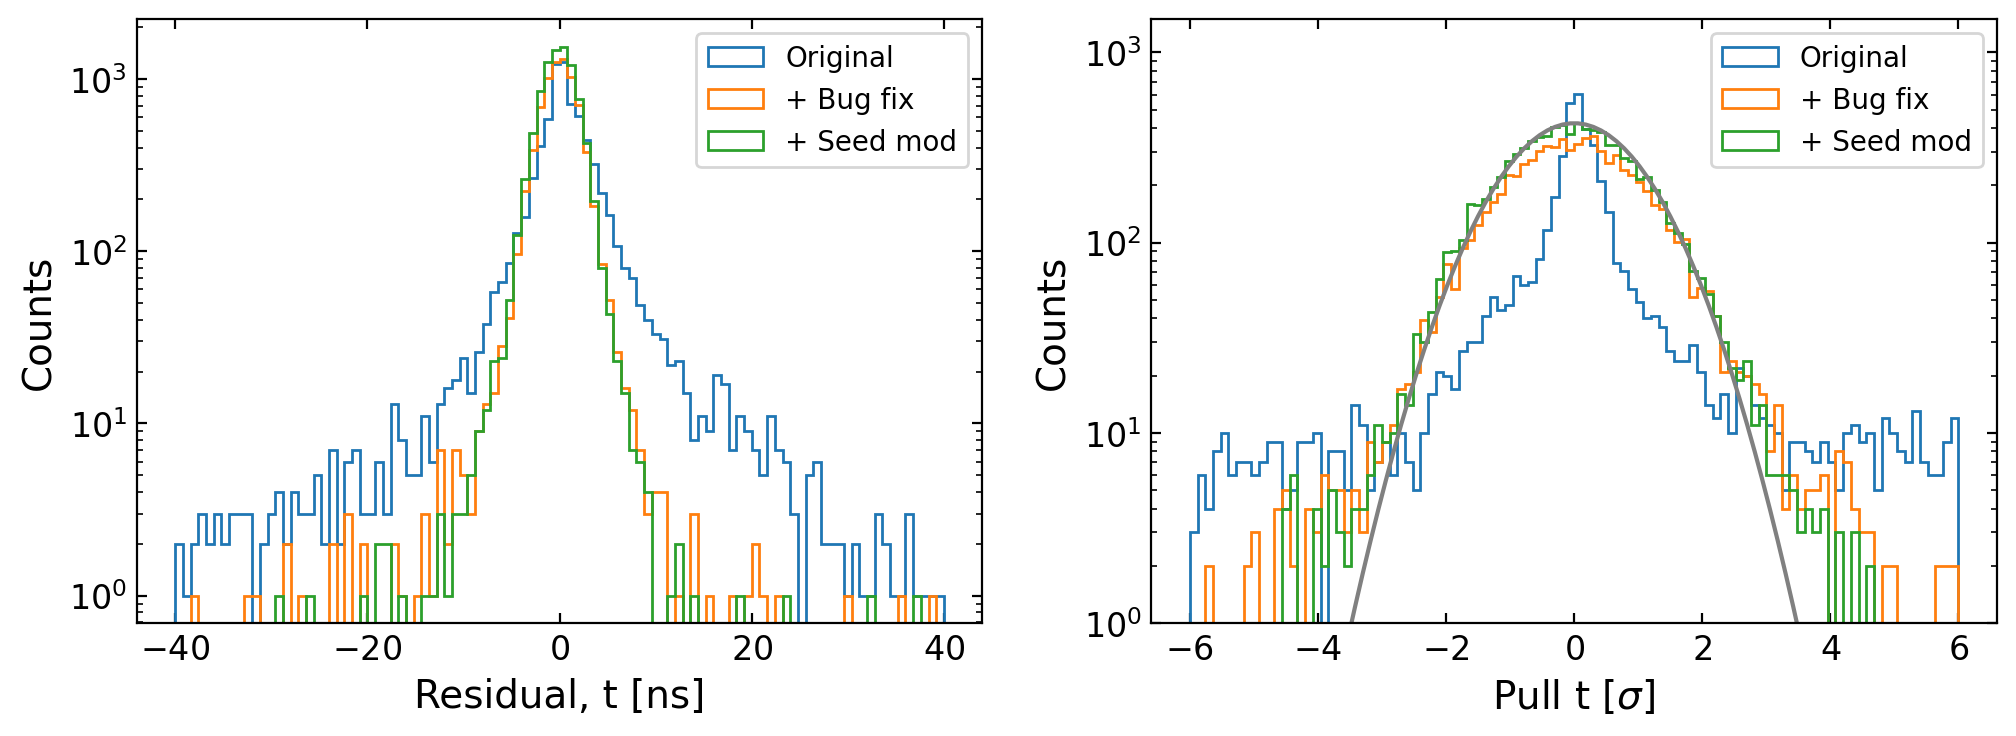

In [27]:
labels=["y [cm]", "z [cm]", "x [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-80,80],[-300,300],[-300,300],[-40,40],[0,900]]

plotlabels = ["Original", "+ Bug fix", "+ Seed mod"]

# for i in [3,4]:
for i in [0,1,2,3]:
    fig, axs=subplots(1,2,figsize=(12,4))
    for idata in range(3):
        data=Data[idata]
        residual = data["residual"]
        unc = data["uncertainty"]
        Vertices_cov    =data["cov"]
        
        # efficiency = sum((residual[:,4]<200))/10000
        # print("Efficiency "+plotlabels[idata]+":", f"{efficiency:.2f}")
        
        sca(axs[0])
        n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i],label=plotlabels[idata],histtype="step");    
        sca(axs[1])
        if i==4:
            # unc_i = 1/residual[:,4]*np.sqrt(residual[:,1]**2*unc[:,1]**2 + residual[:,2]**2*unc[:,2]**2 + residual[:,0]**2*unc[:,0]**2 )
            unc_i=[]
            for ievent in range(len(Vertices_cov)):
                cov = Vertices_cov[ievent][:3,:3]
                # cov =np.diag(np.diag(cov))
                delta_r = residual[ievent,:3]
                unc_i.append(sqrt(delta_r@cov@delta_r)/residual[ievent,4])            
        else:
            unc_i =unc[:,i]
        pull = util.pull(residual[:,i],0,unc_i)
            
        n0,ibins,_ = hist(pull,range=[-6,6],label=plotlabels[idata],histtype="step"); 
        ibins=util.Utils.center(ibins)
        if idata==2:
            plot(ibins,util.Utils.Gauss(ibins,max(n0),0,1),color="grey")
        
    legend(fontsize=10)
    
    sca(axs[0])
    xlabel("Residual, "+labels[i])
    ylabel("Counts")
    yscale("log")
    legend(fontsize=10)
    sca(axs[1])
    xlabel("Pull "+labels[i].split(" ")[0]+r" [$\sigma$]")
    ylabel("Counts")
    yscale("log")  
    ylim(bottom=1)
    show()